# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we use a network with softmax output.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from viewer import Viewer

In [2]:
# create gym environment
env = gym.make('CartPole-v0')

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [3]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.00868904 -0.04986263 -0.01674886 -0.04742614]
sample action: 0


Let us see how the environment looks when we just take random actions.

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



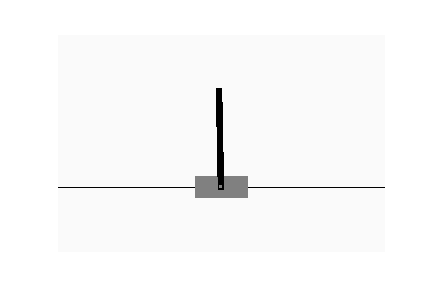
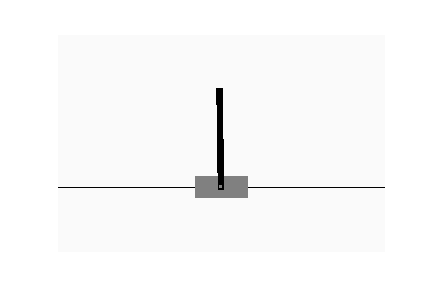
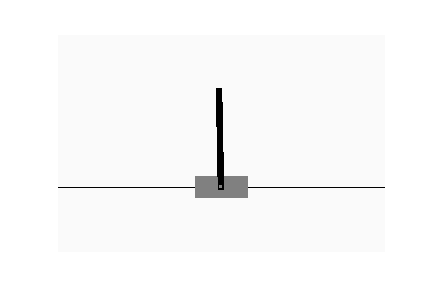
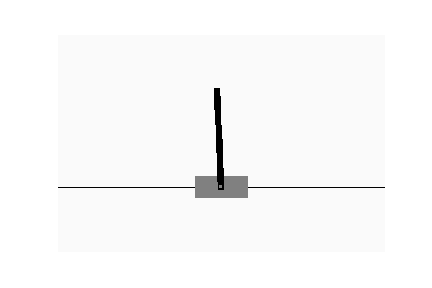
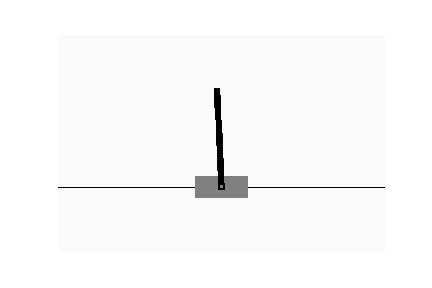
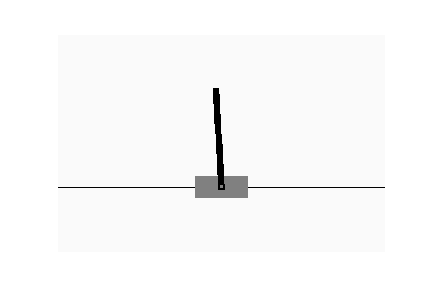
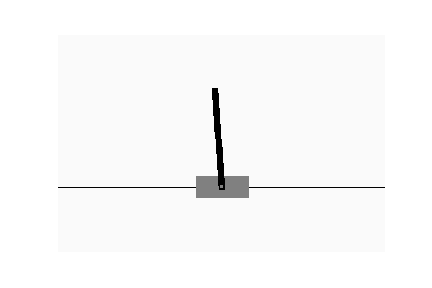
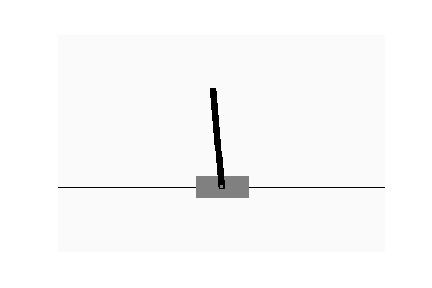
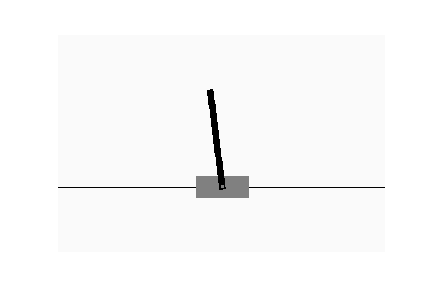
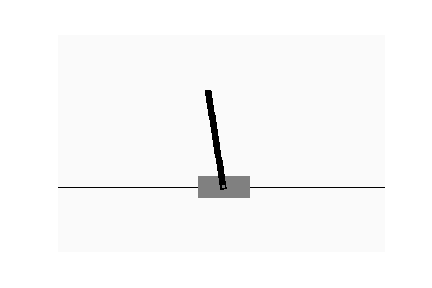
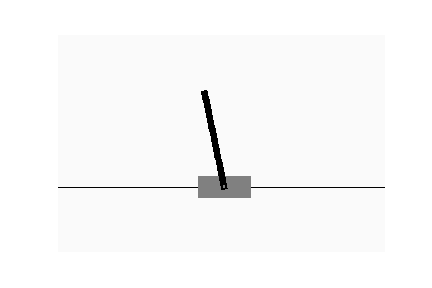
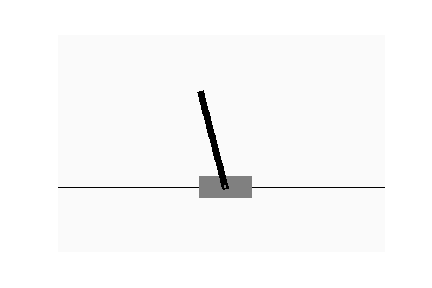
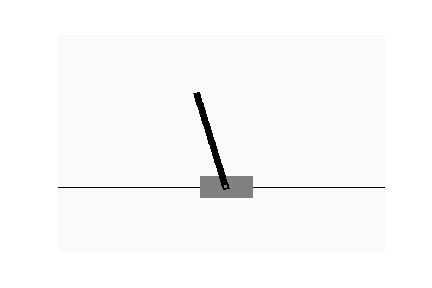
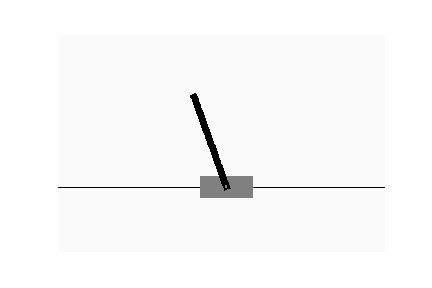
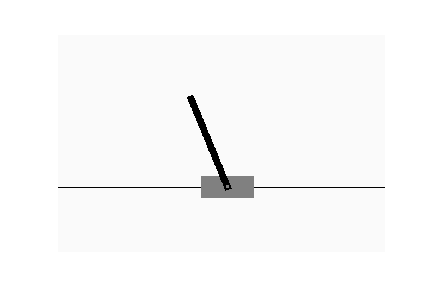
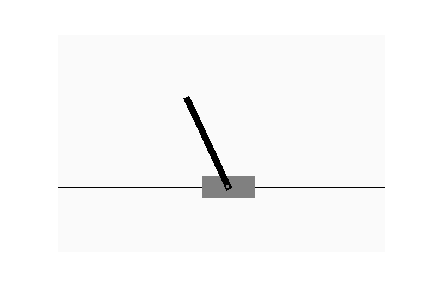
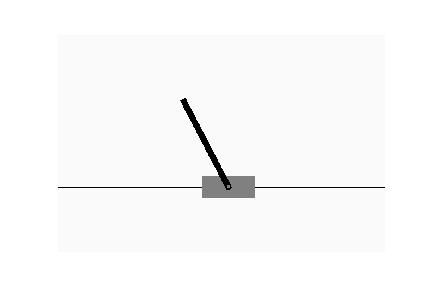
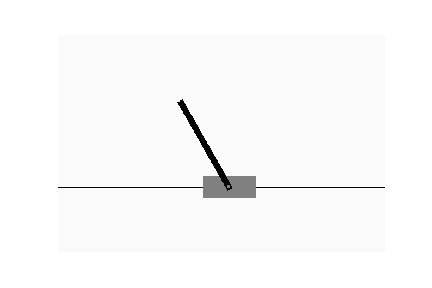
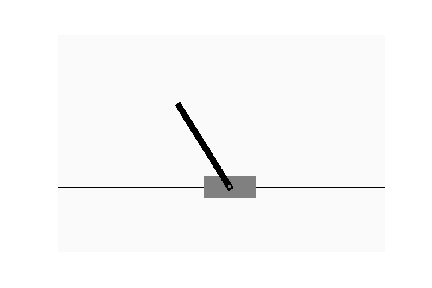
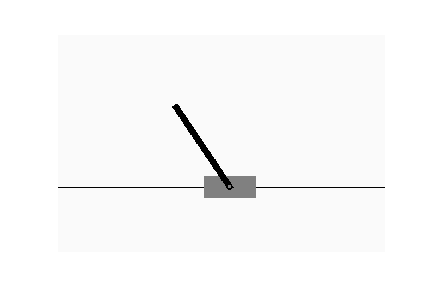
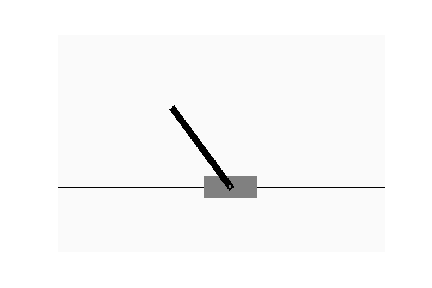
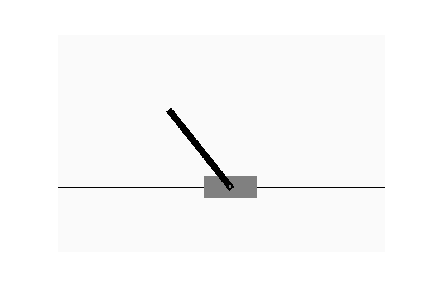
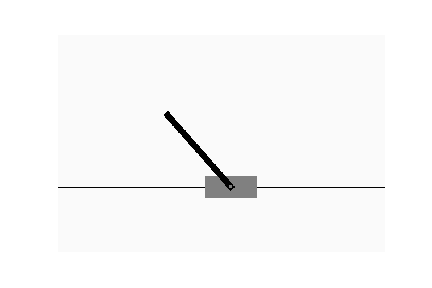
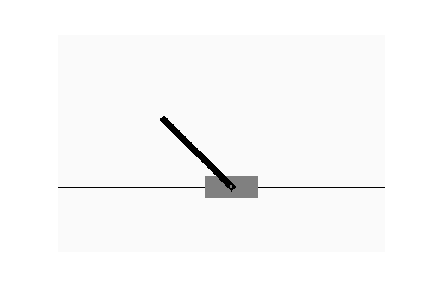
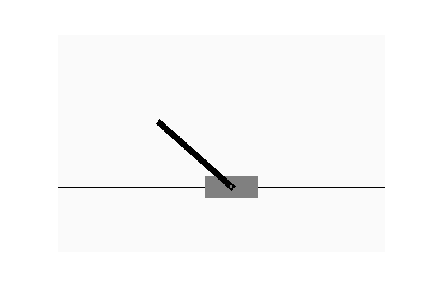
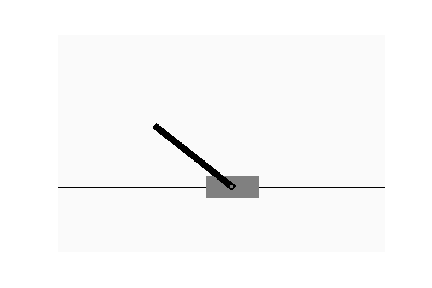
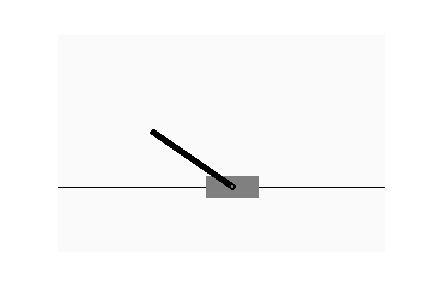
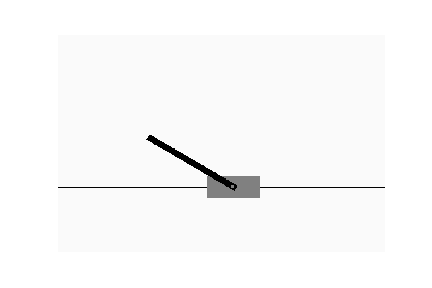
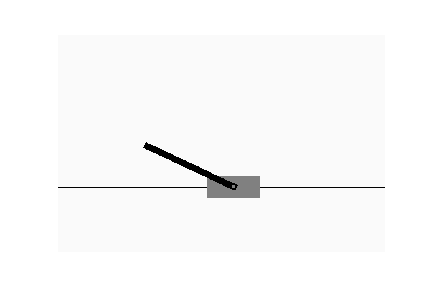
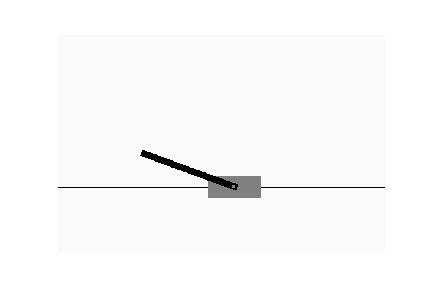
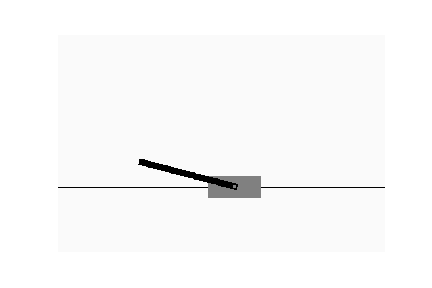
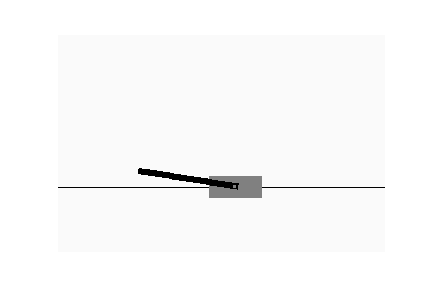
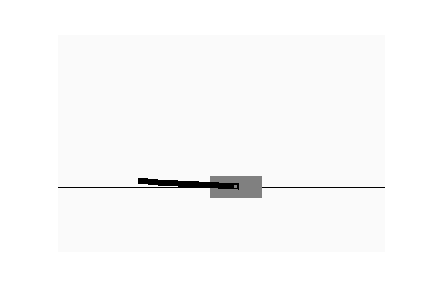
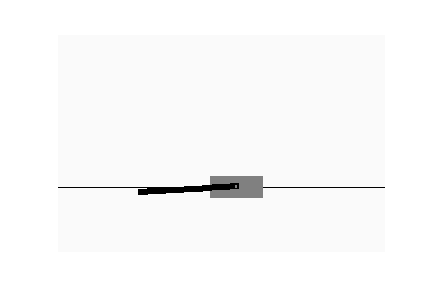
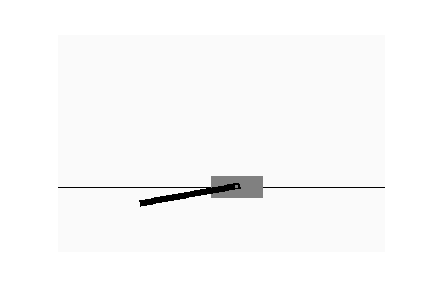
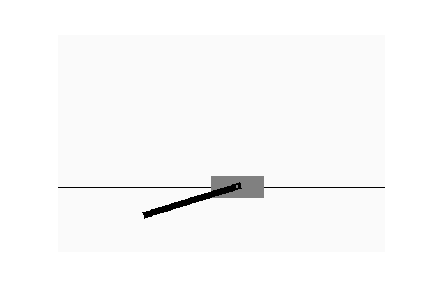
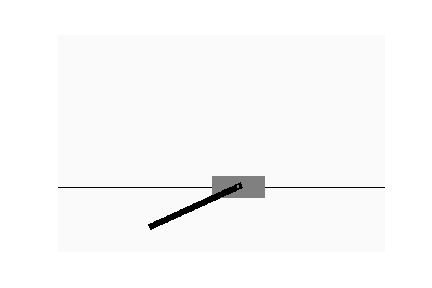
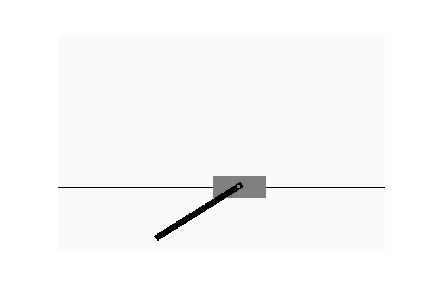
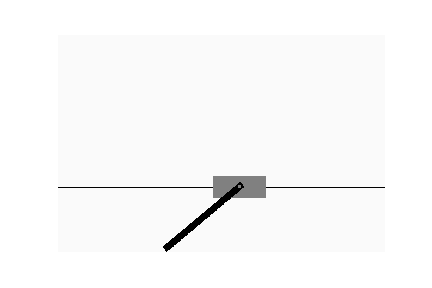
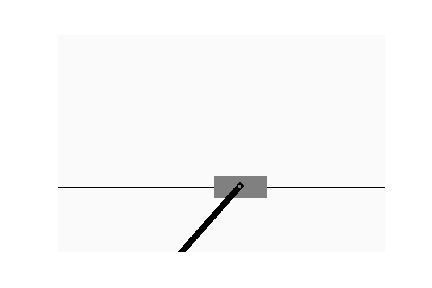
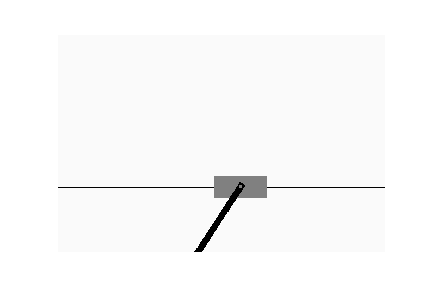
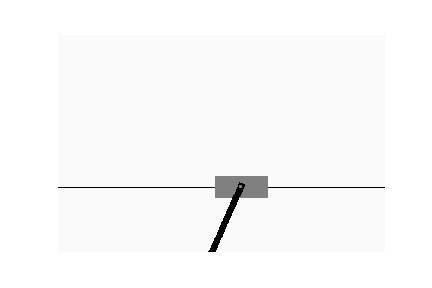
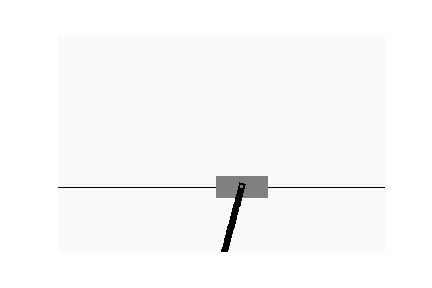
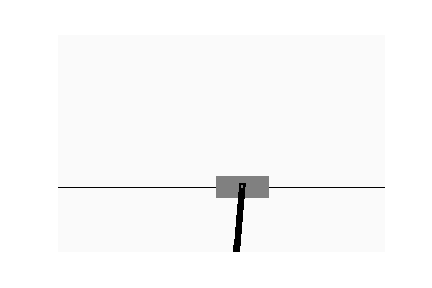
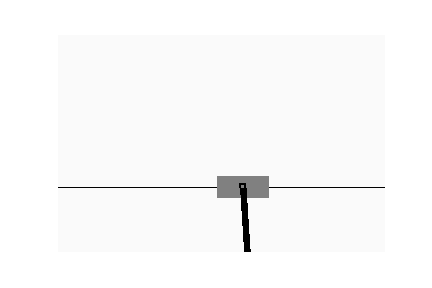
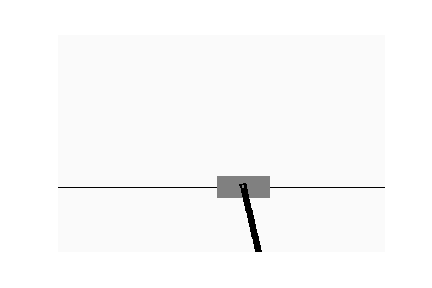
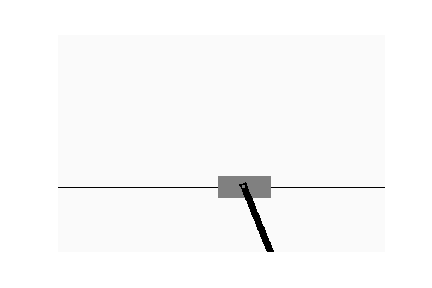
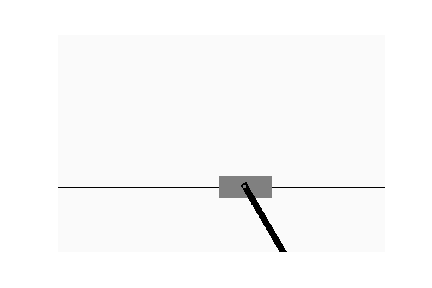
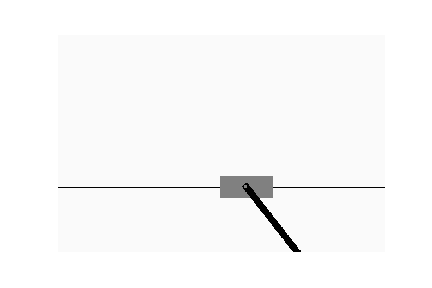
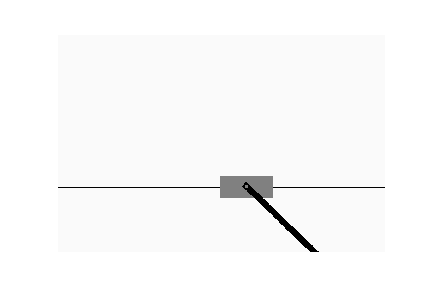
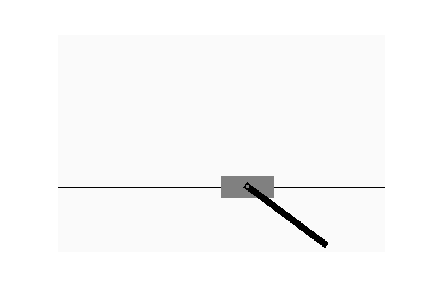
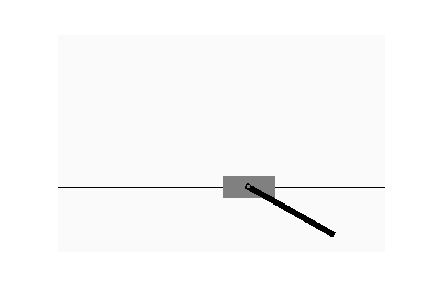
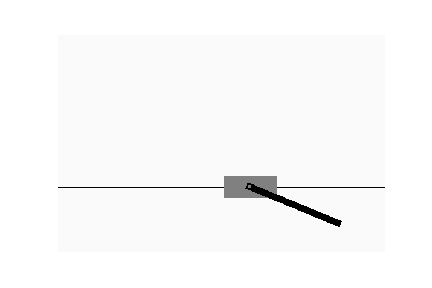
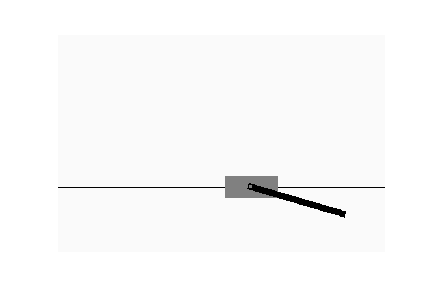
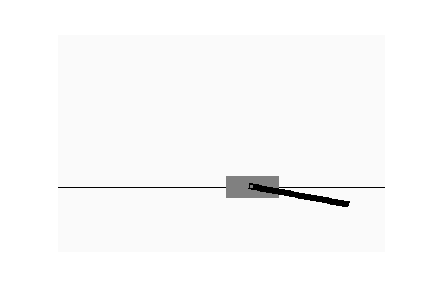
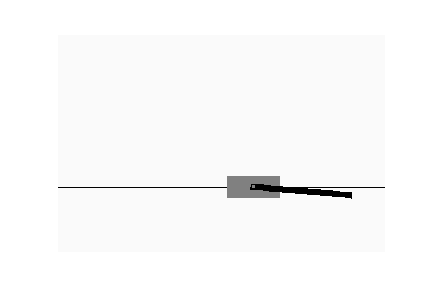
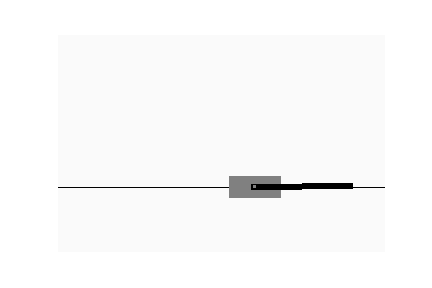
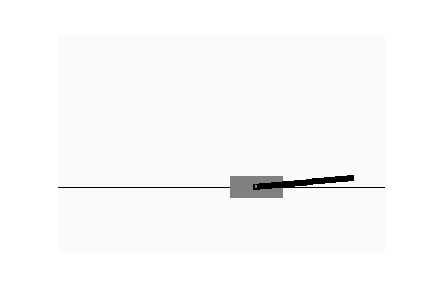
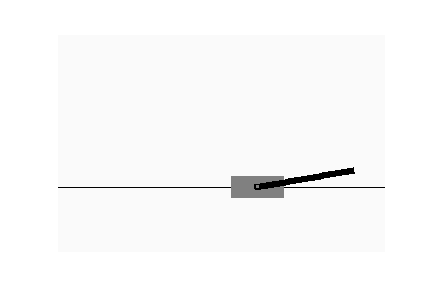
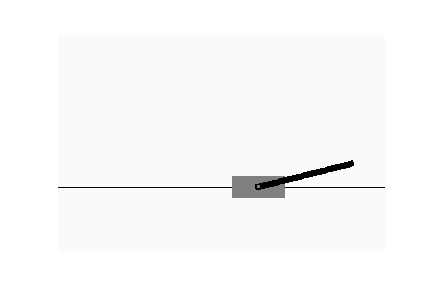
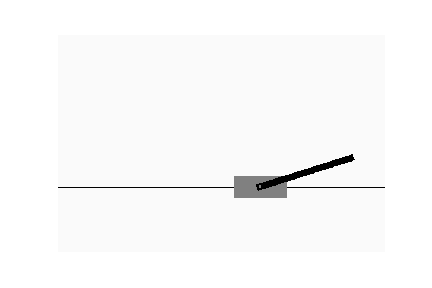
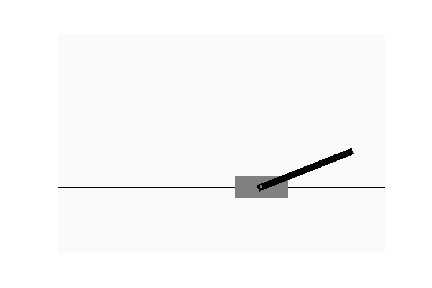
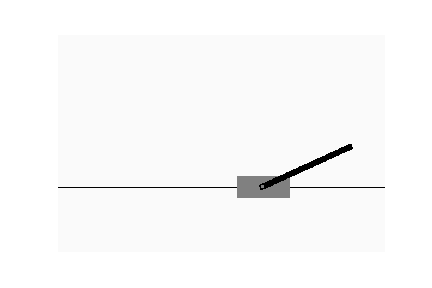
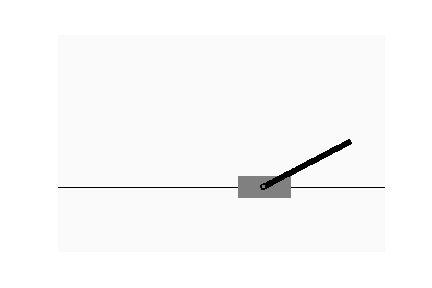
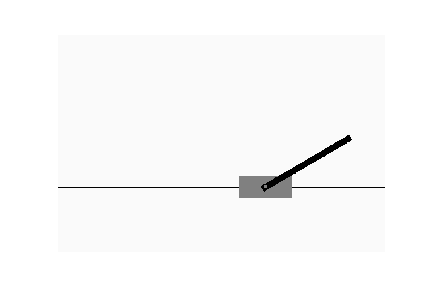
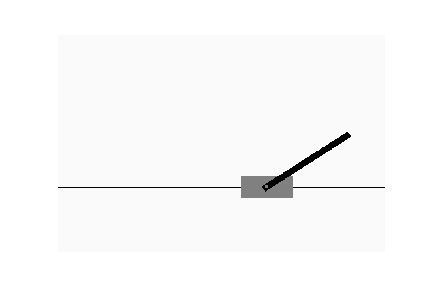
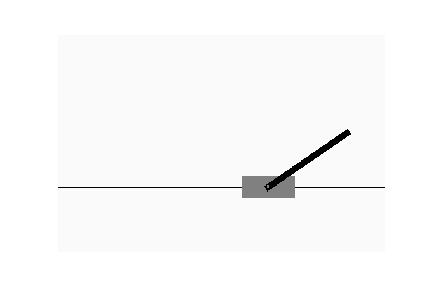
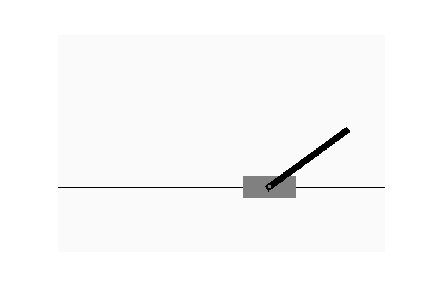
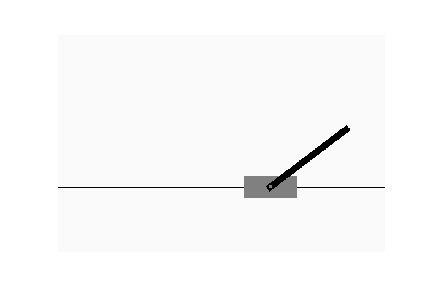
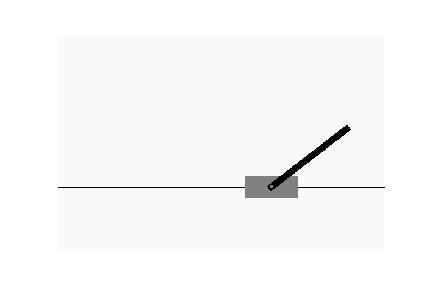
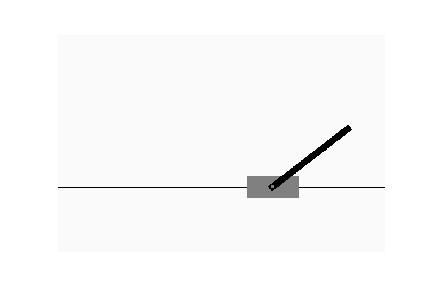
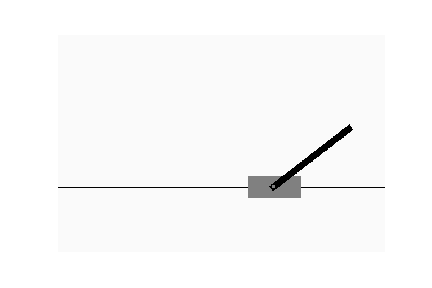
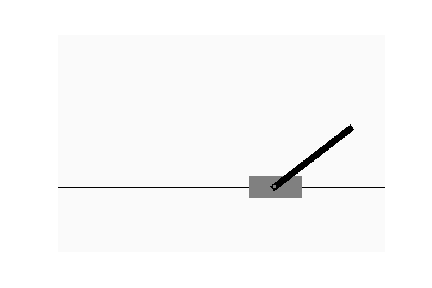
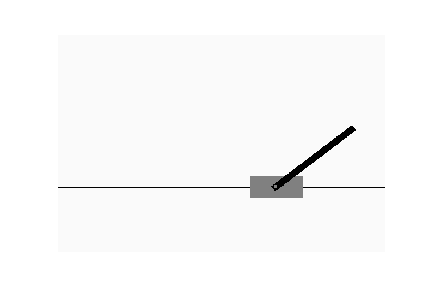
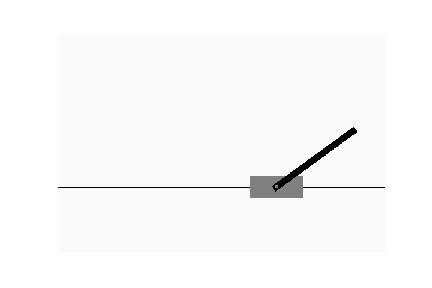
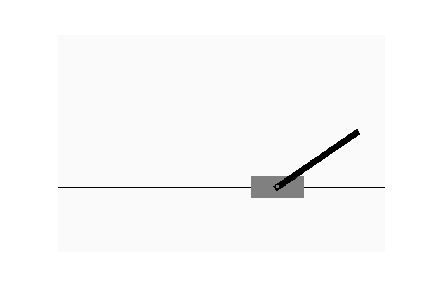
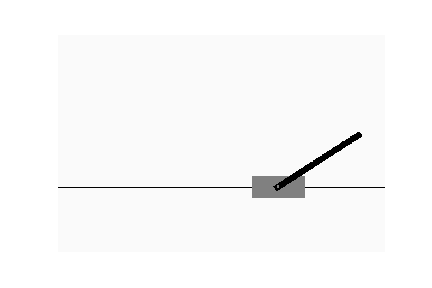
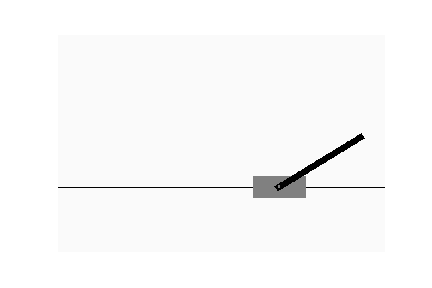
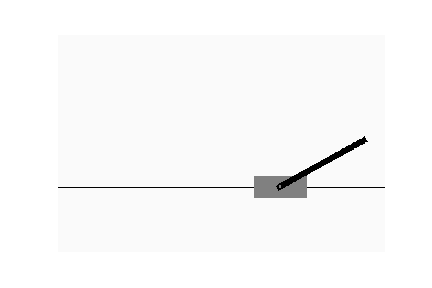
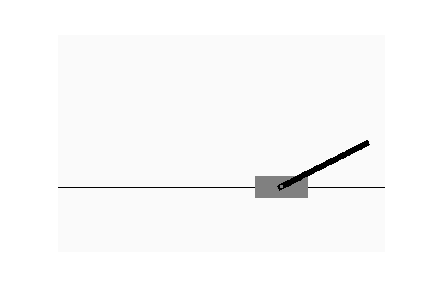
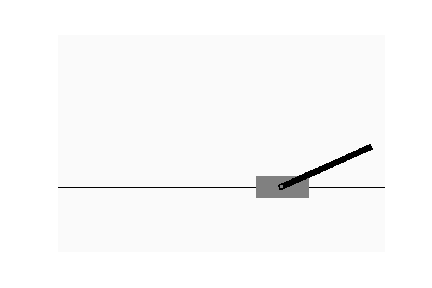
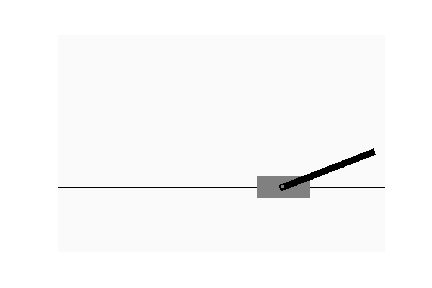
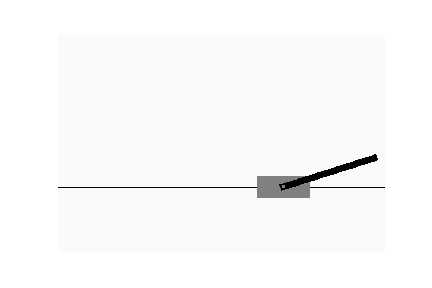
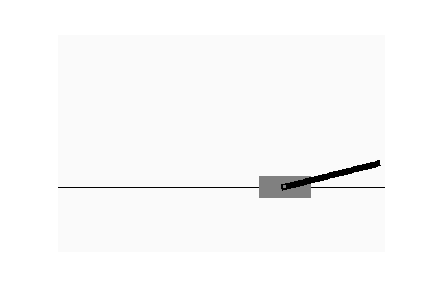
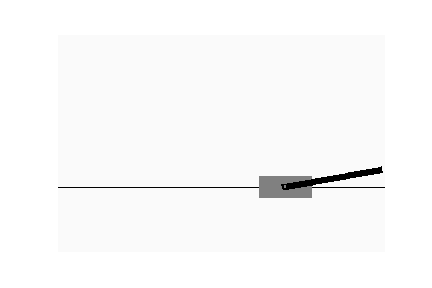
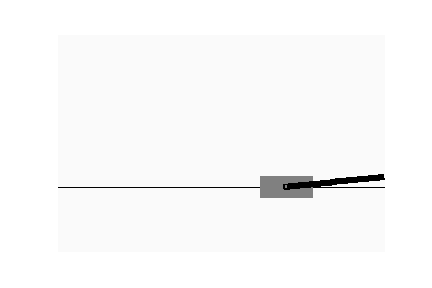
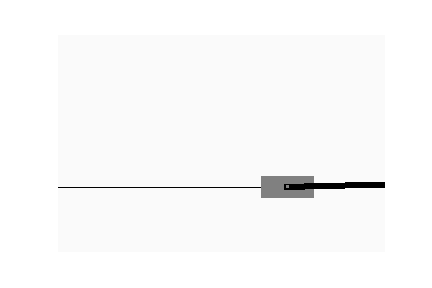
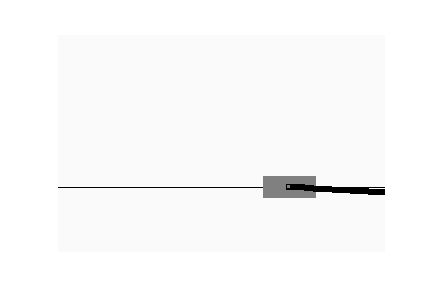
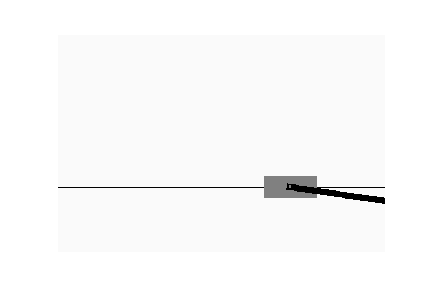
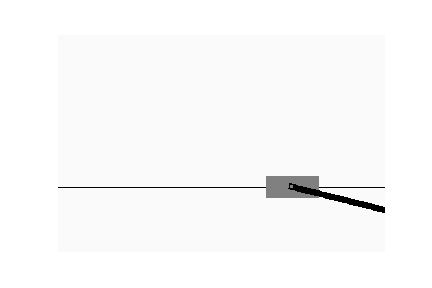
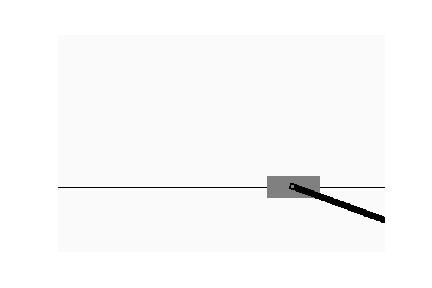
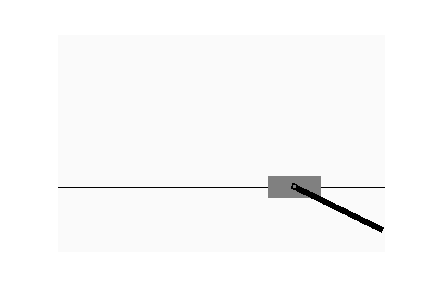
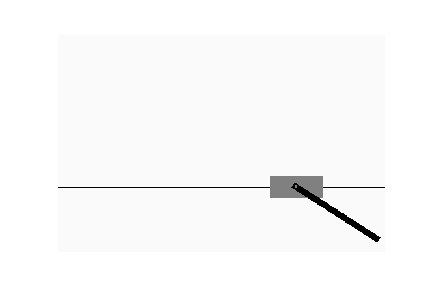
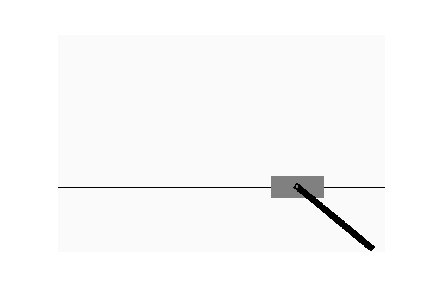
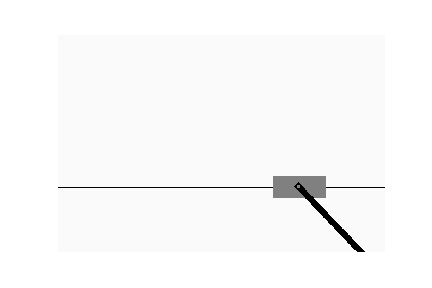
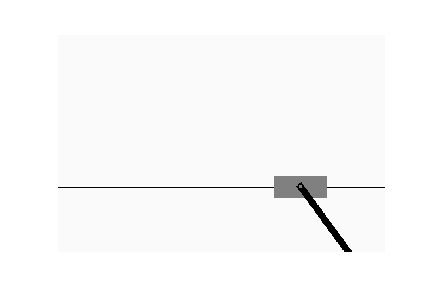
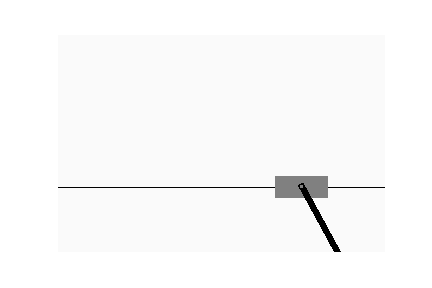
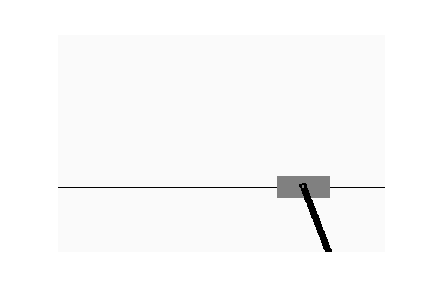
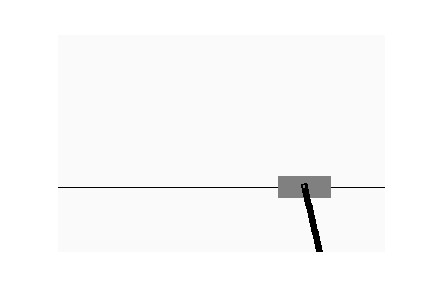
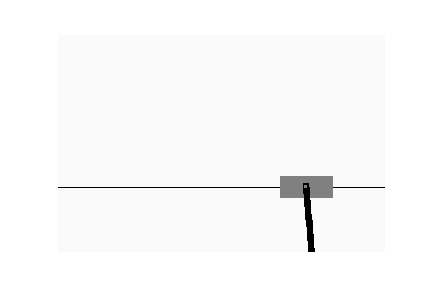
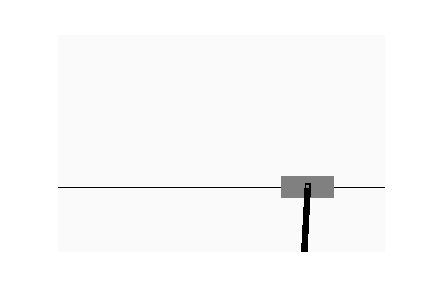
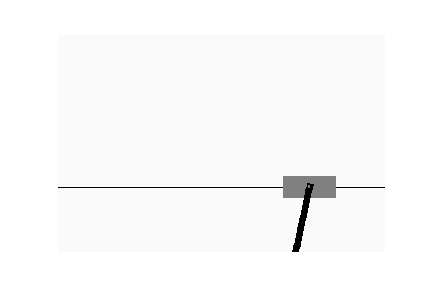
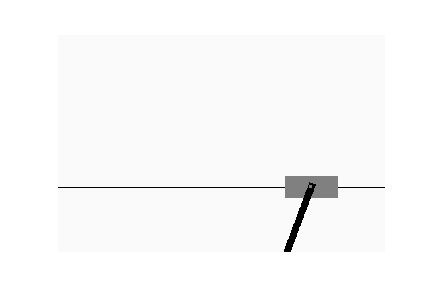
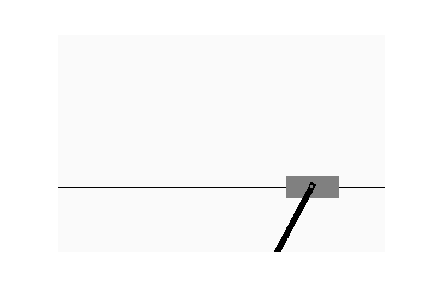
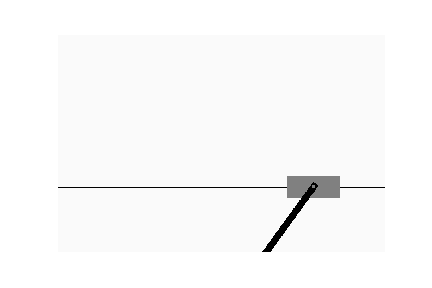
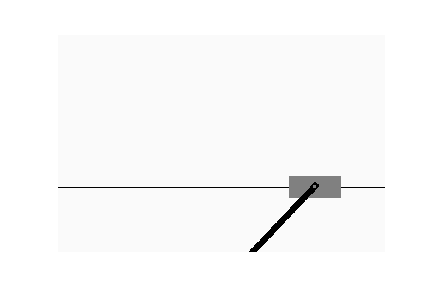
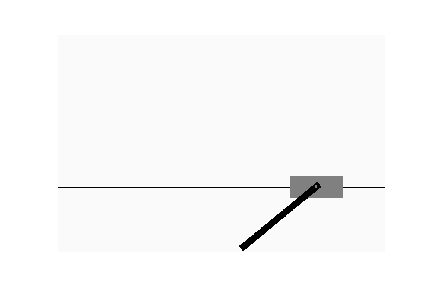
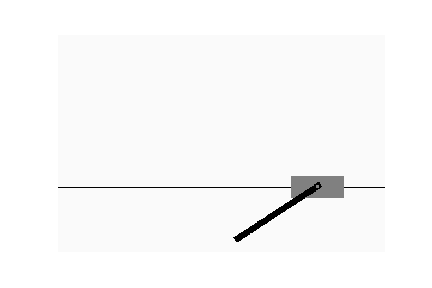
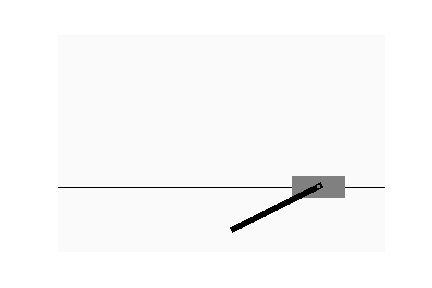
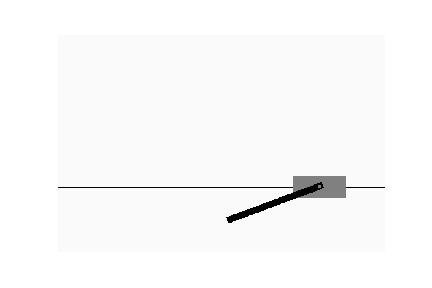
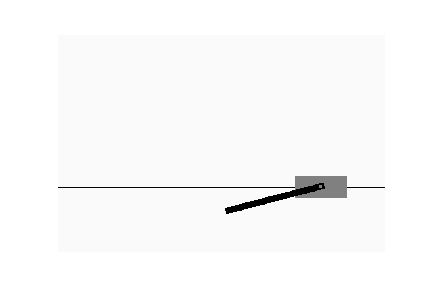
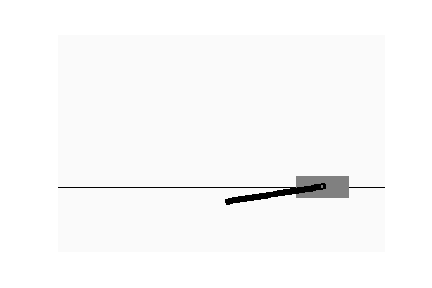
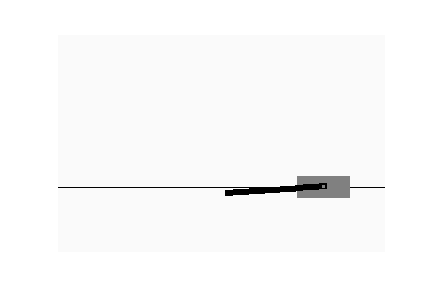
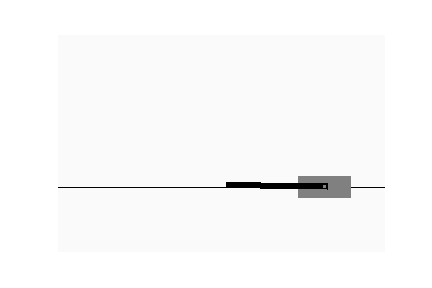
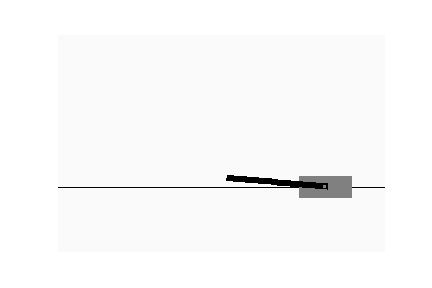
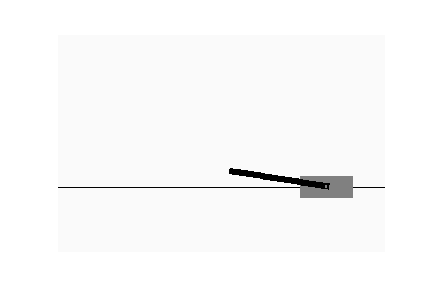
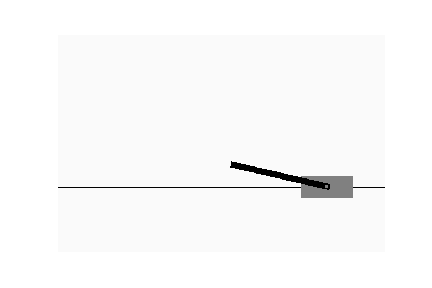
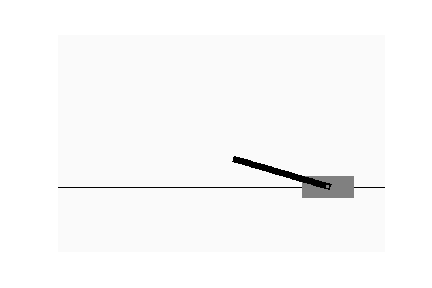
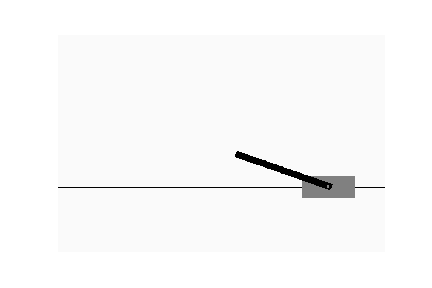
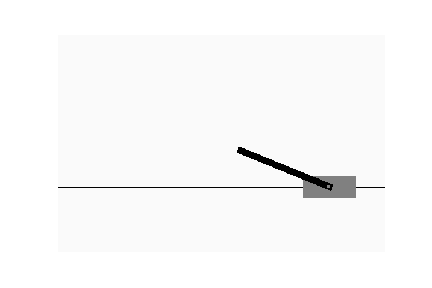
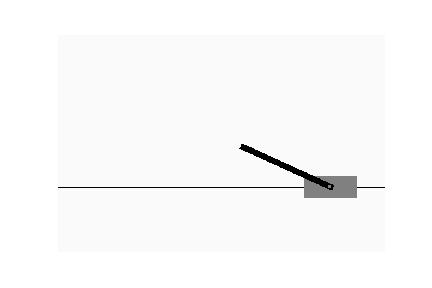
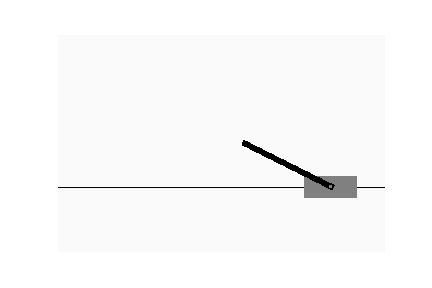
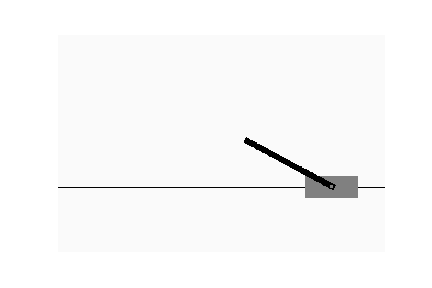
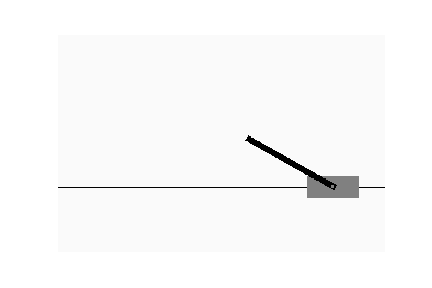
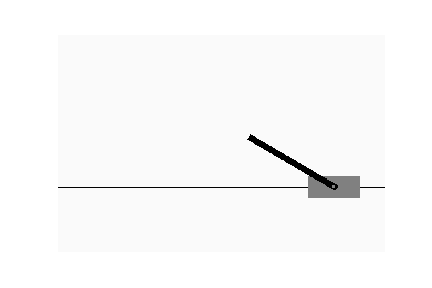
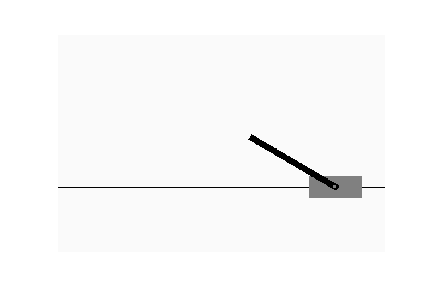
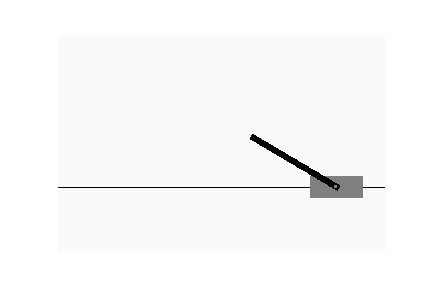
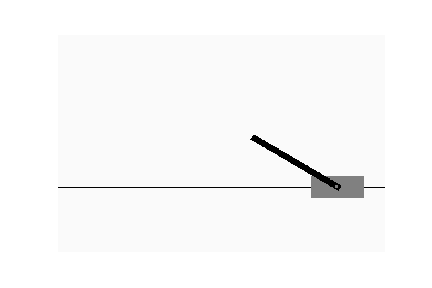
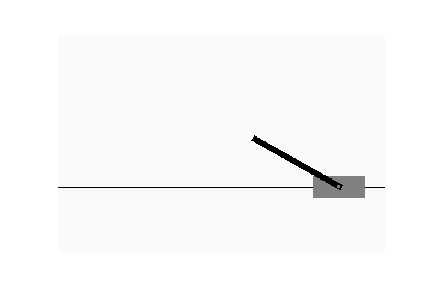
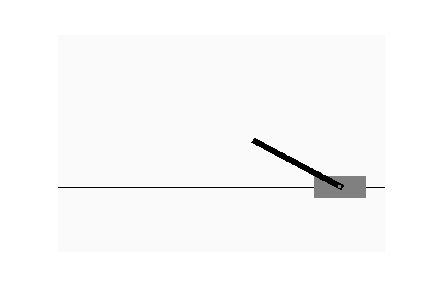
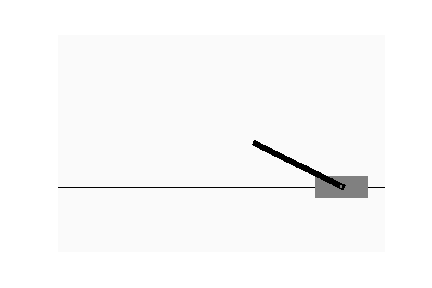
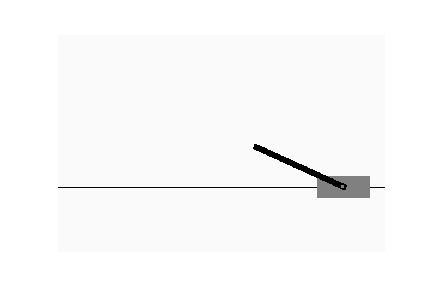
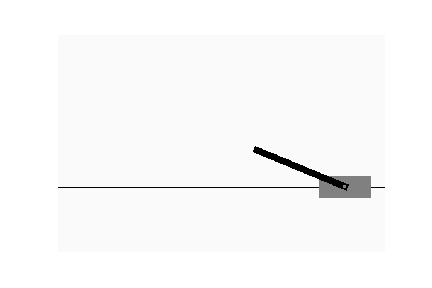
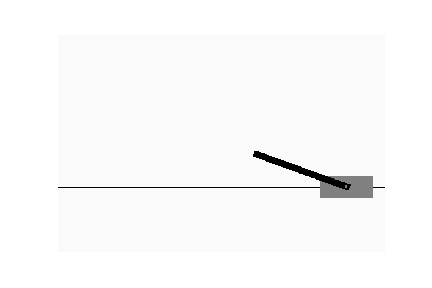
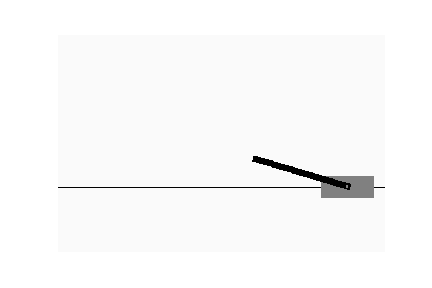
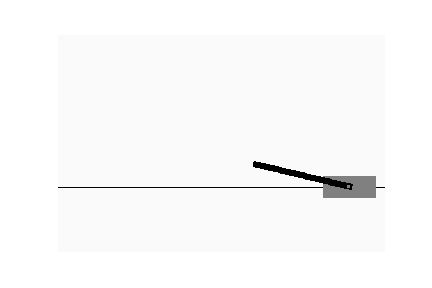
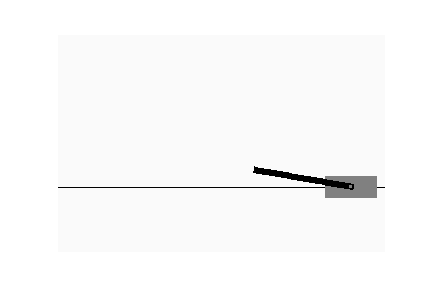
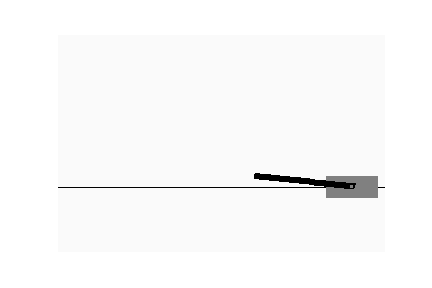
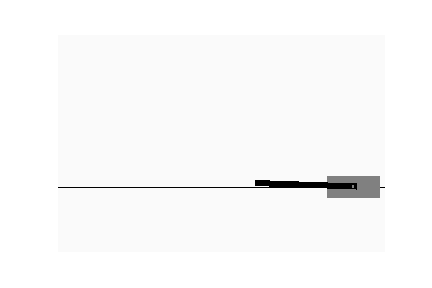
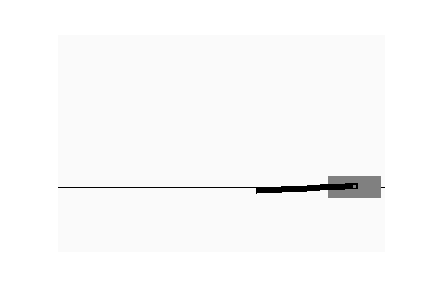
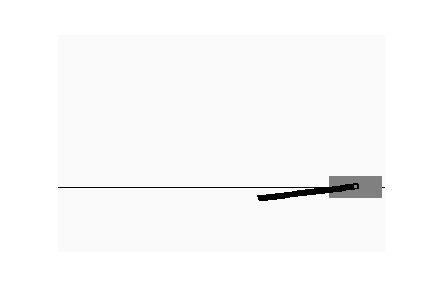
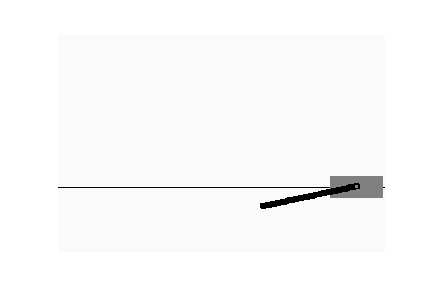
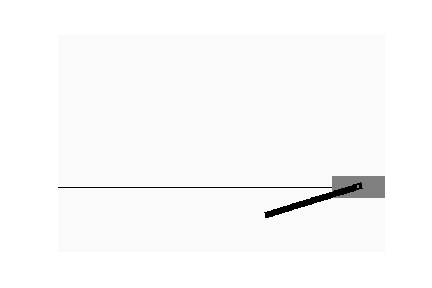
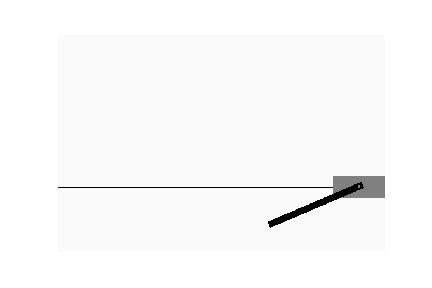
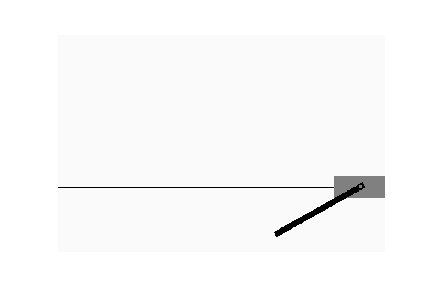
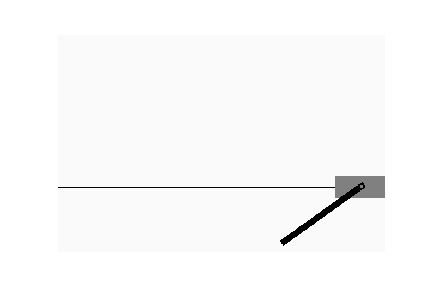
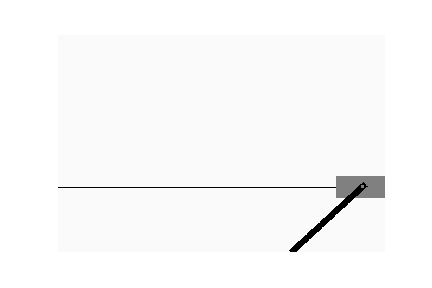
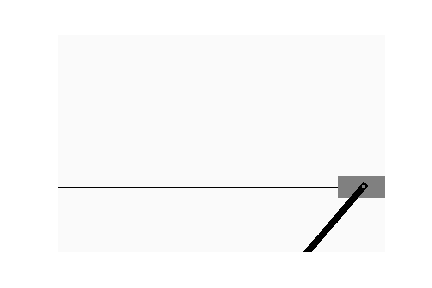
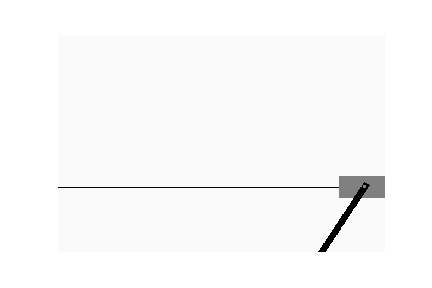
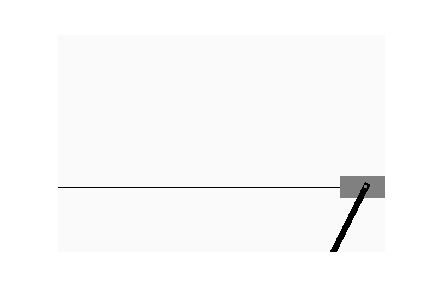
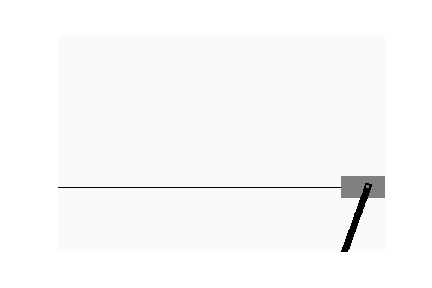
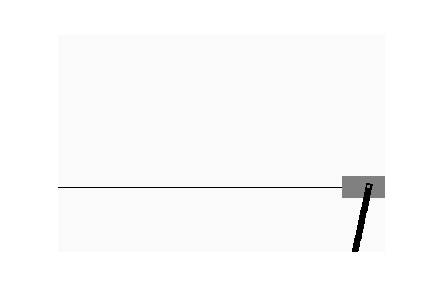
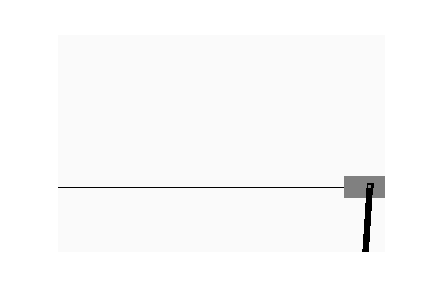
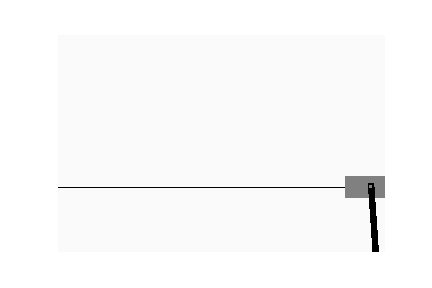
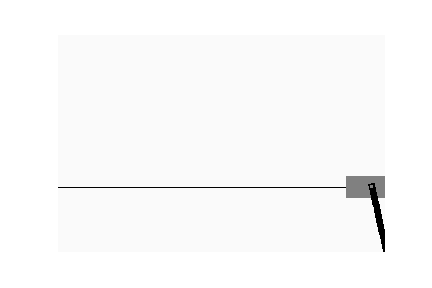
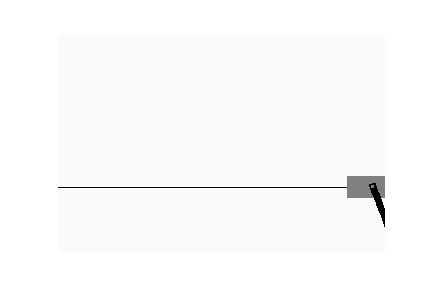
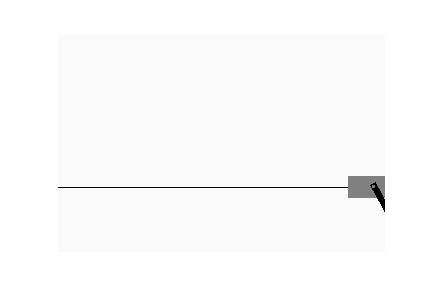
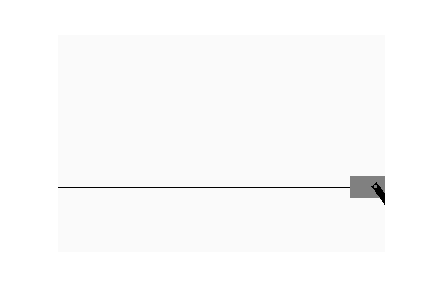
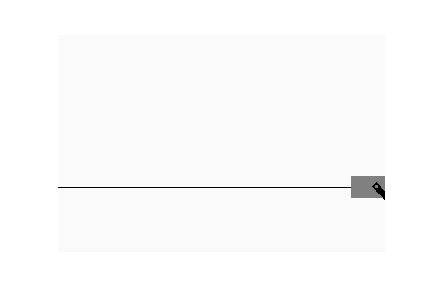
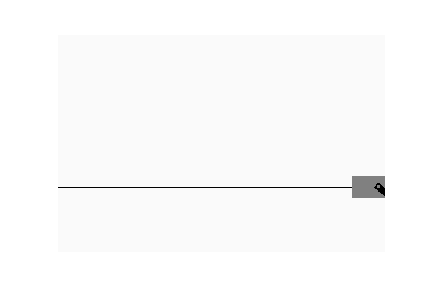
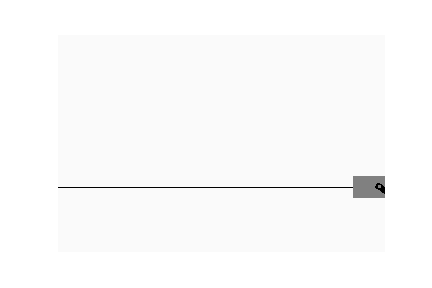
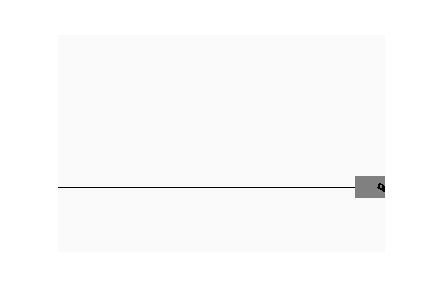
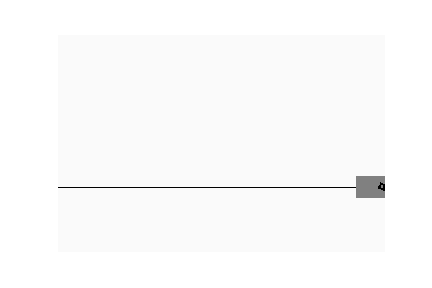
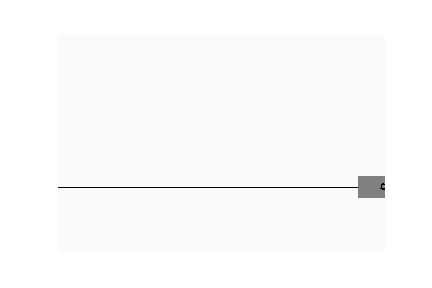
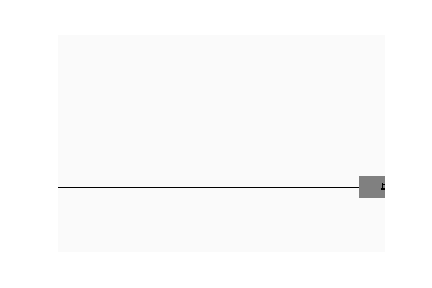
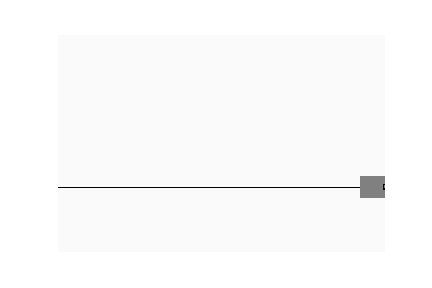
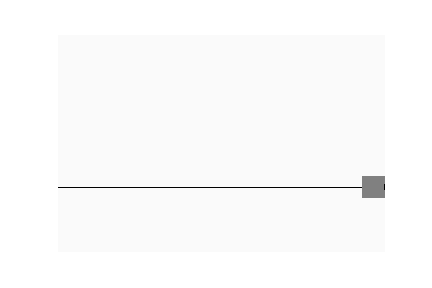
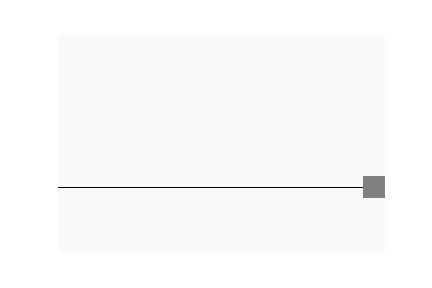
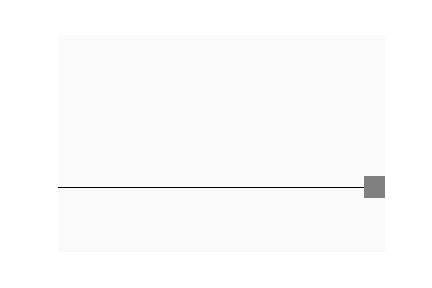
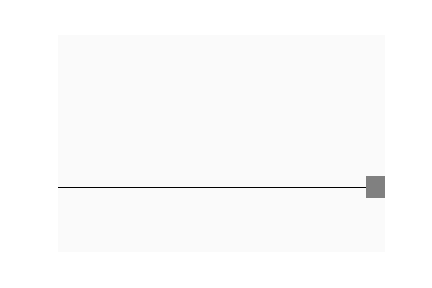
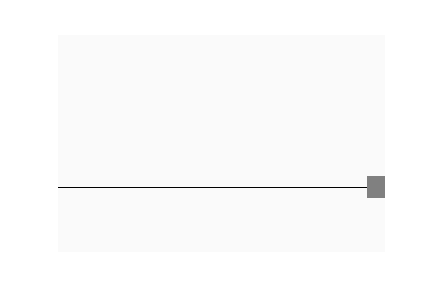
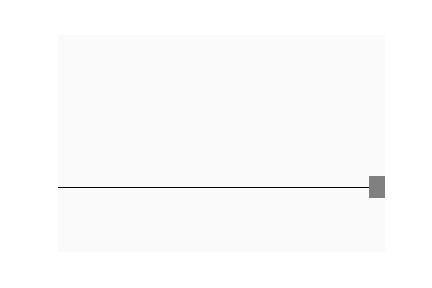
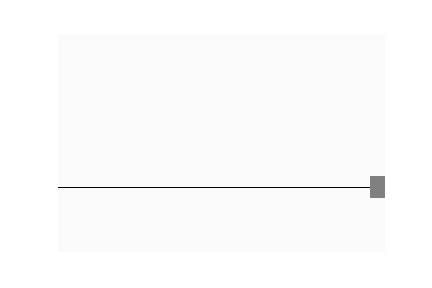
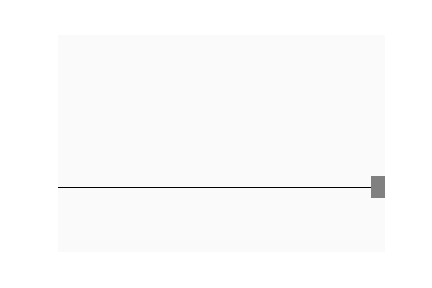
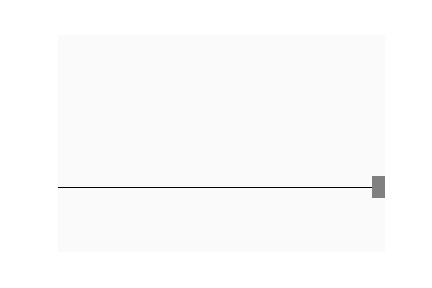
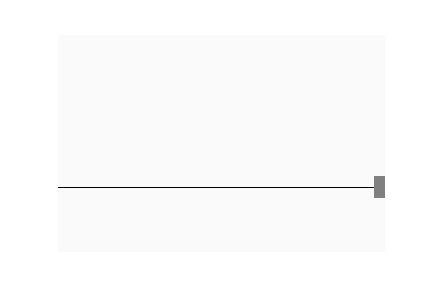
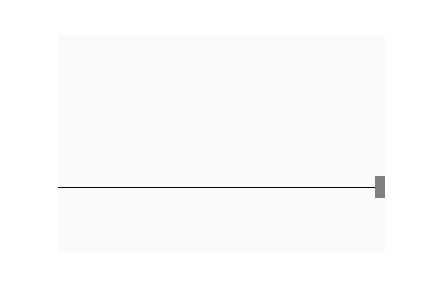
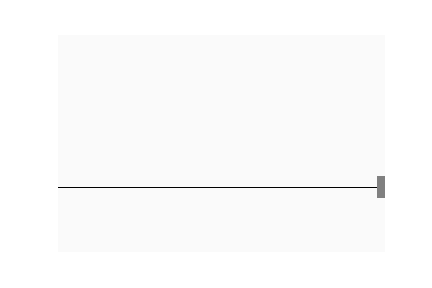
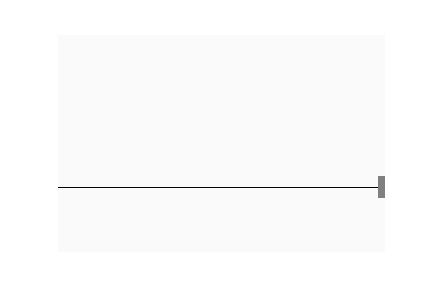
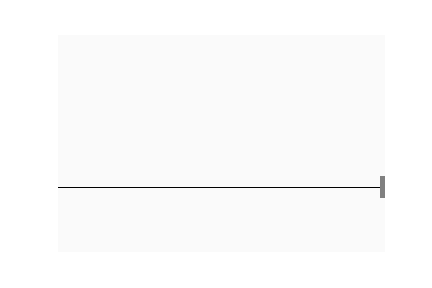
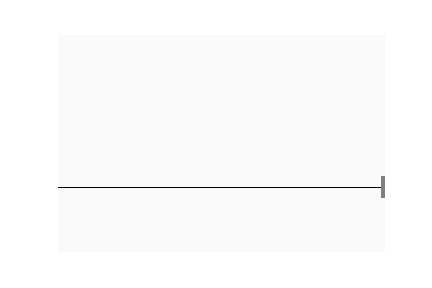
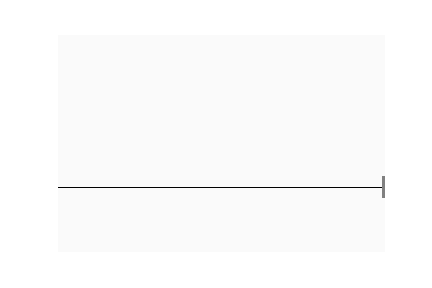
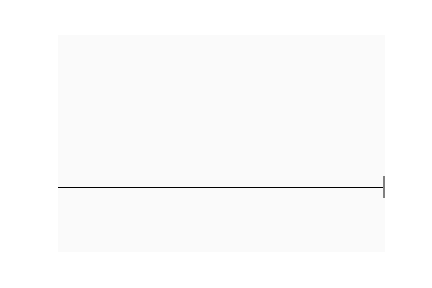
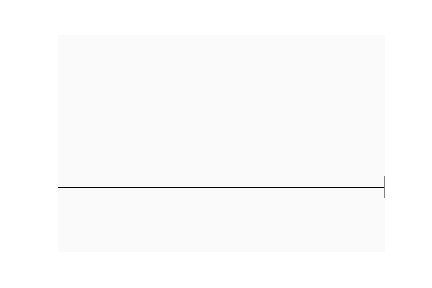
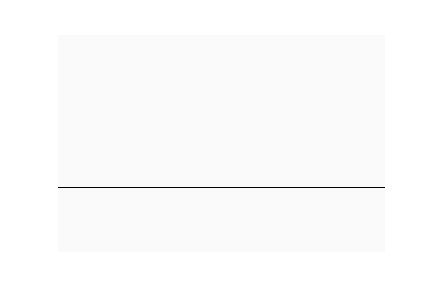
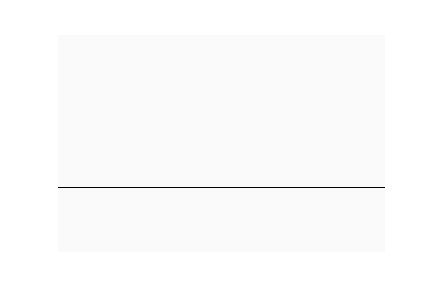
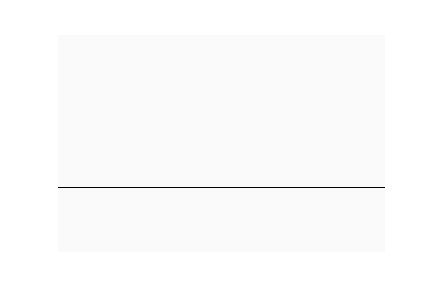
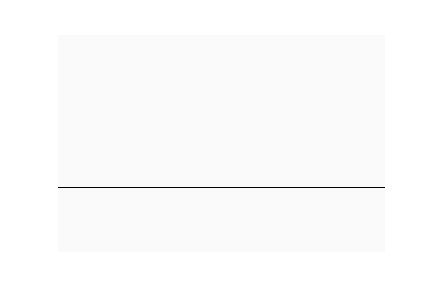
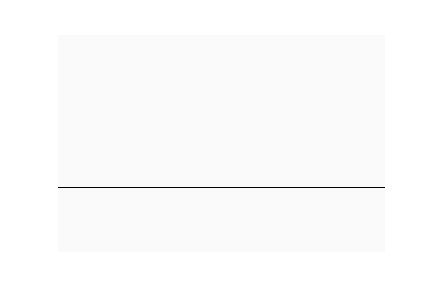
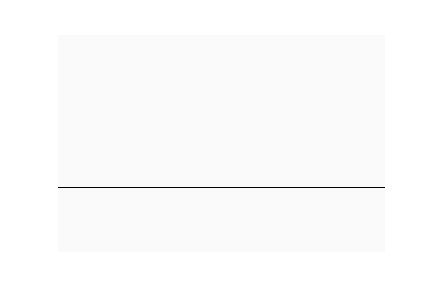
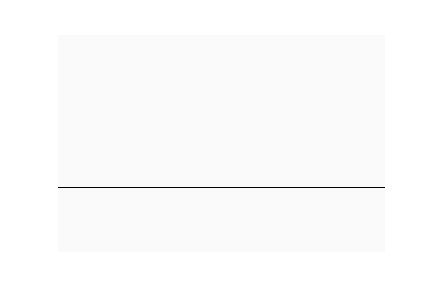
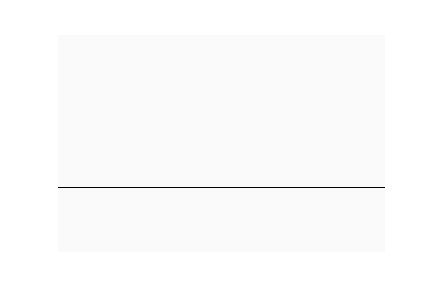
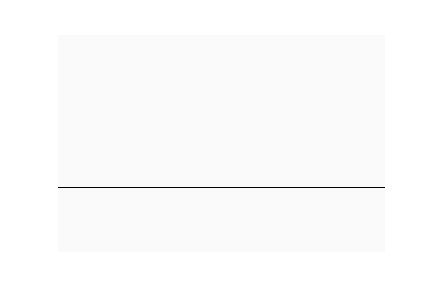
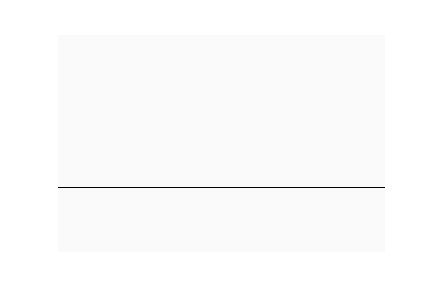
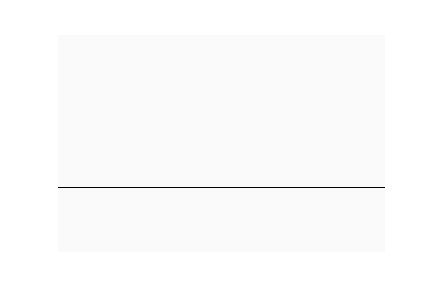
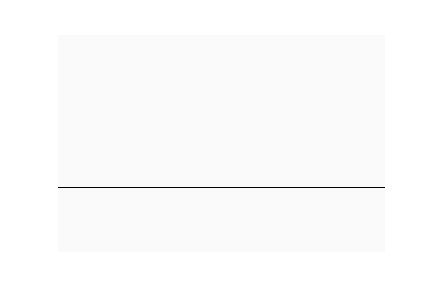
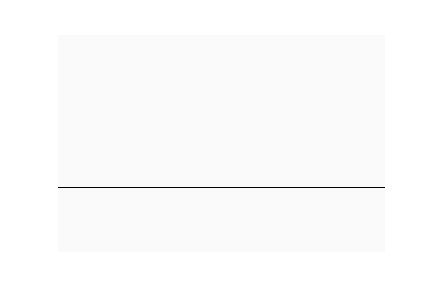
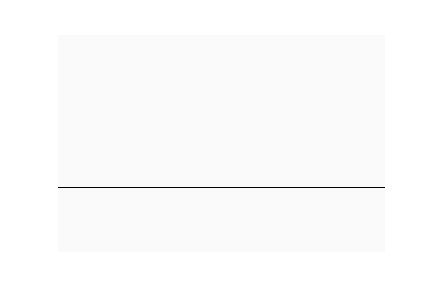
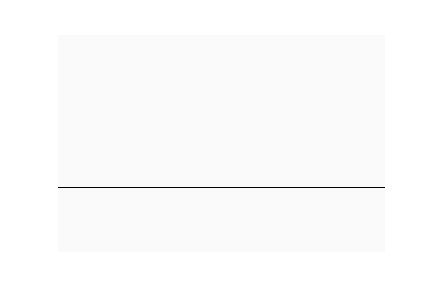
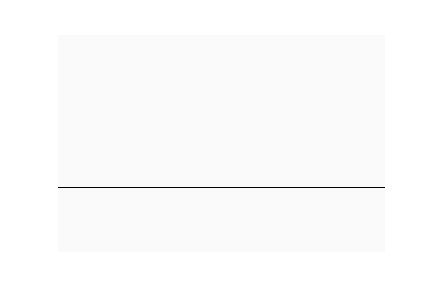

In [4]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render() # display the environment inline in the notebook
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [5]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        x = F.relu(x)
        
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [6]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [7]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [8]:
# training settings

num_episodes = 2000
rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  23.32, mean validation reward:   9.70, mean loss:  8.3826
 200. mean training reward:  20.31, mean validation reward:   9.20, mean loss:  7.2275
 300. mean training reward:  23.39, mean validation reward:   9.30, mean loss:  8.2391
 400. mean training reward:  27.51, mean validation reward:  39.50, mean loss:  9.5780
 500. mean training reward:  33.61, mean validation reward:  64.60, mean loss: 11.4233
 600. mean training reward:  49.96, mean validation reward: 123.50, mean loss: 15.8841
 700. mean training reward:  81.15, mean validation reward:  97.60, mean loss: 20.7243
 800. mean training reward: 117.69, mean validation reward: 144.60, mean loss: 27.7030
 900. mean training reward: 148.36, mean validation reward: 156.00, mean loss: 30.2519
1000. mean training reward: 178.58, mean validation reward: 170.80, mean loss: 33.6073
1100. mean training reward: 138.93, mean validation reward: 139.40, mean loss: 24.8912
1200. mean training reward: 

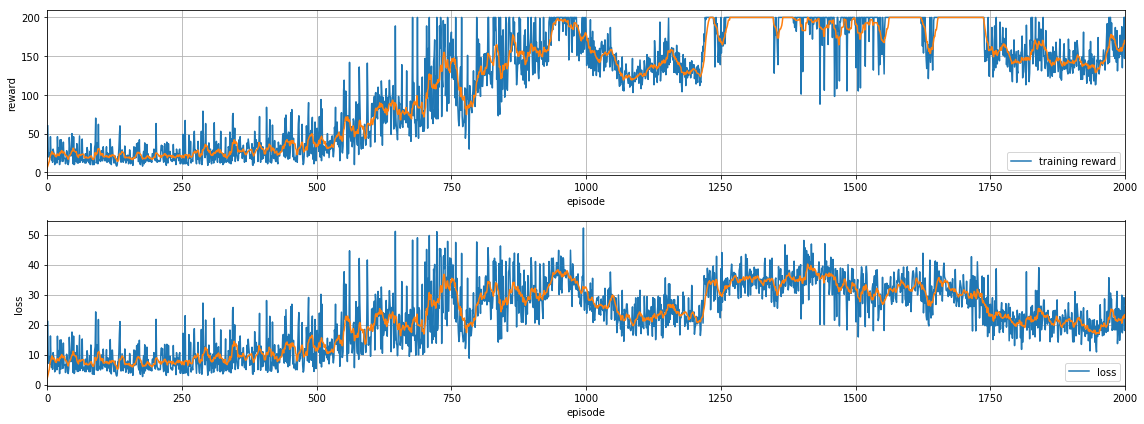

In [9]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



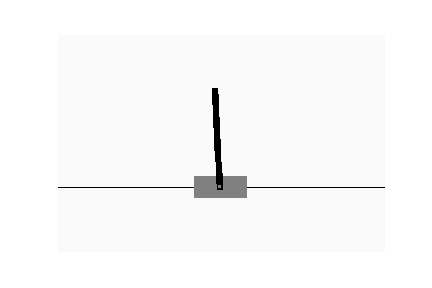
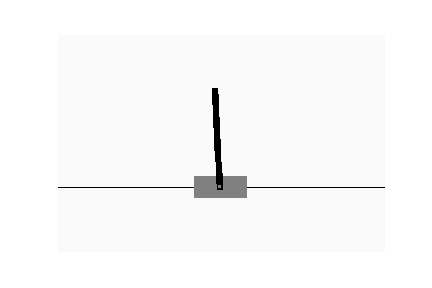
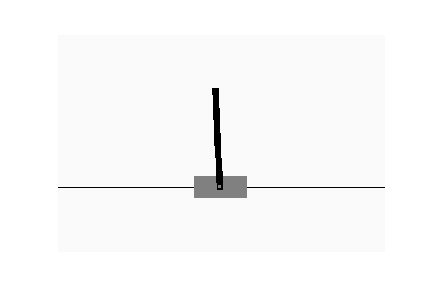
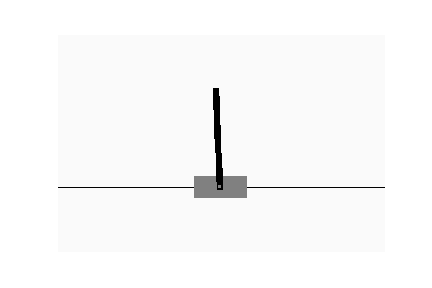
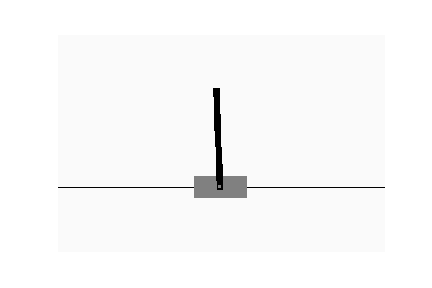
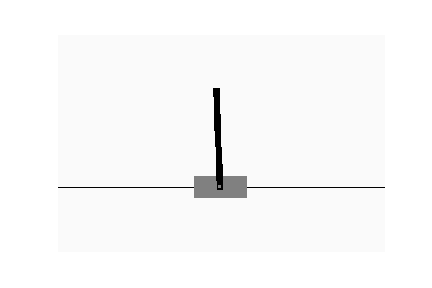
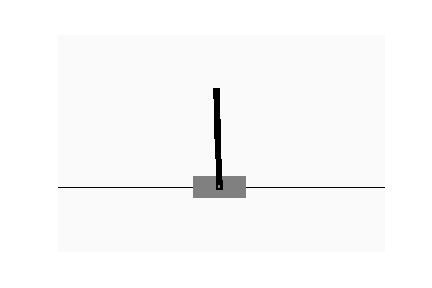
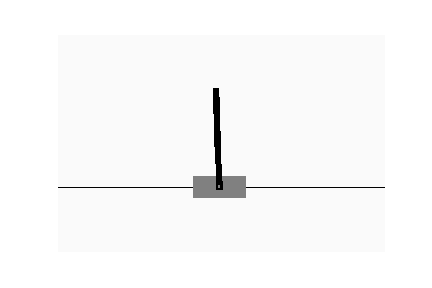
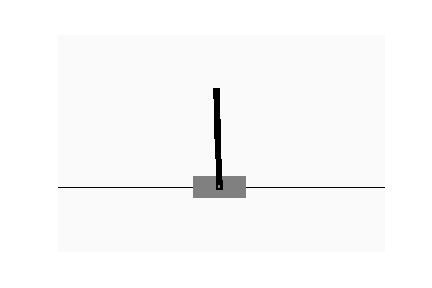
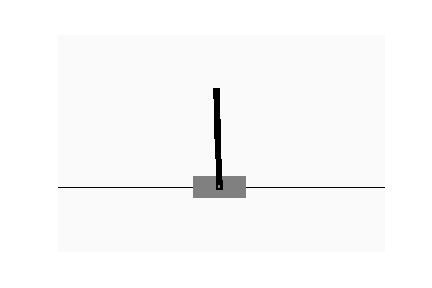
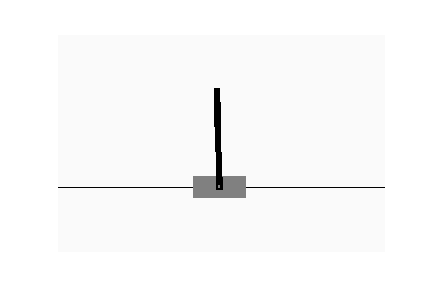
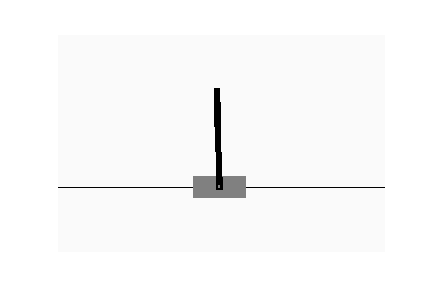
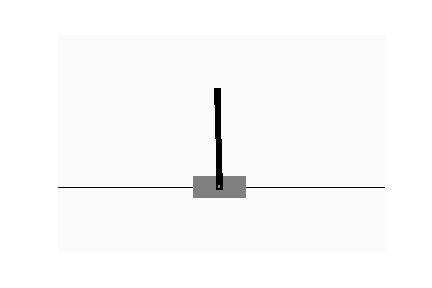
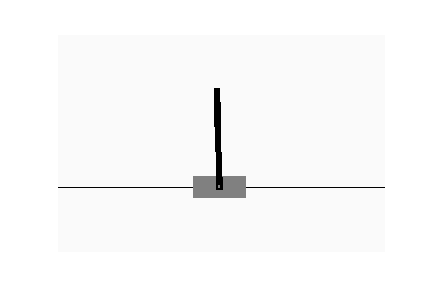
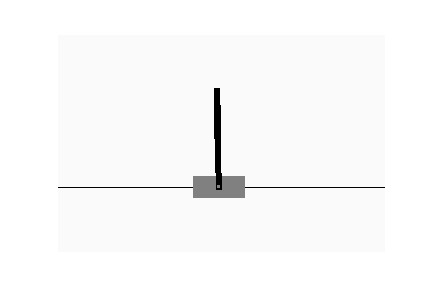
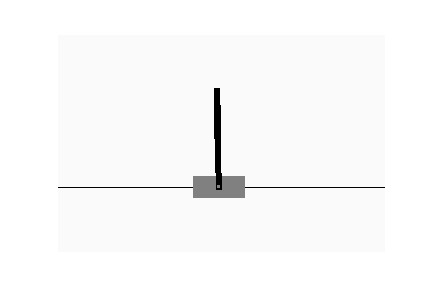
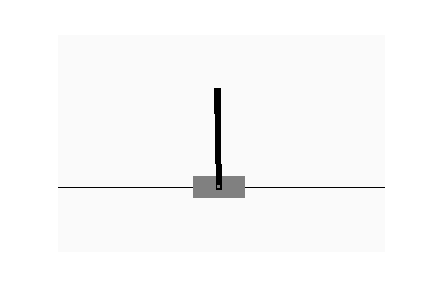
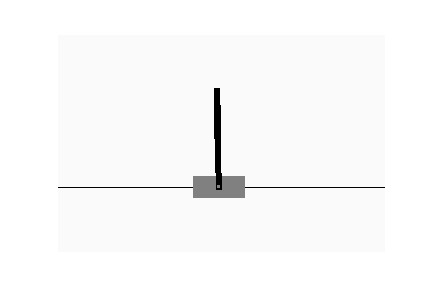
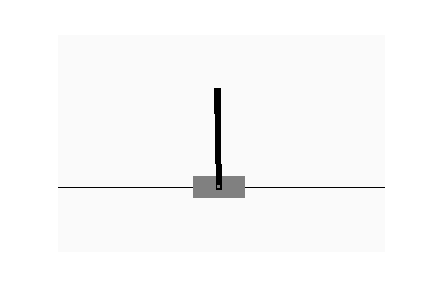
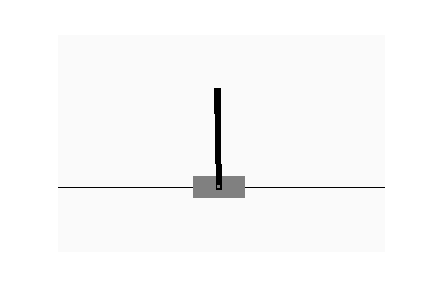
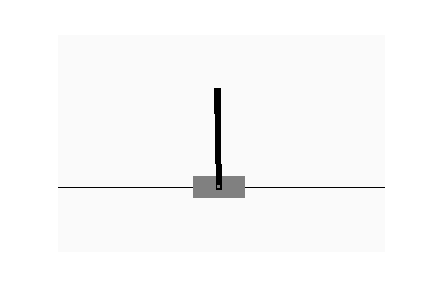
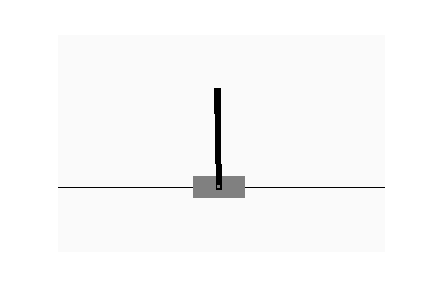
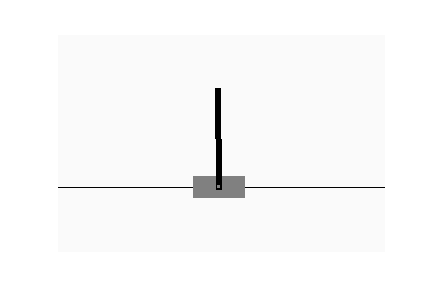
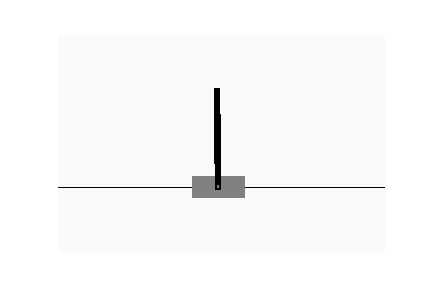
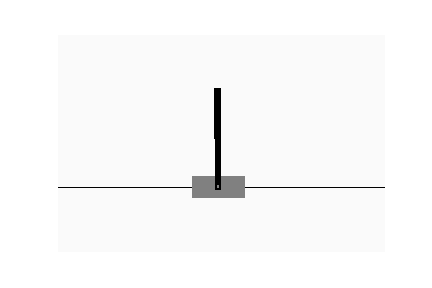
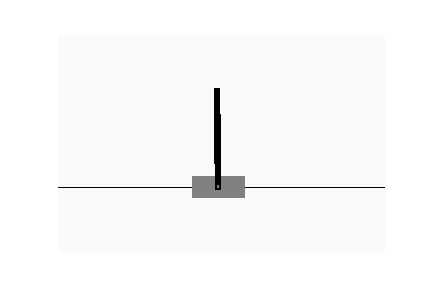
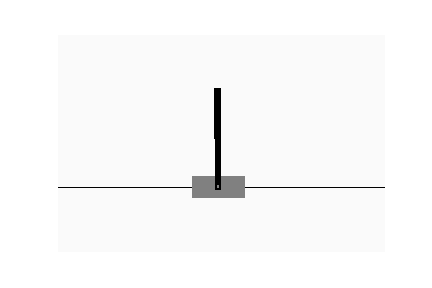
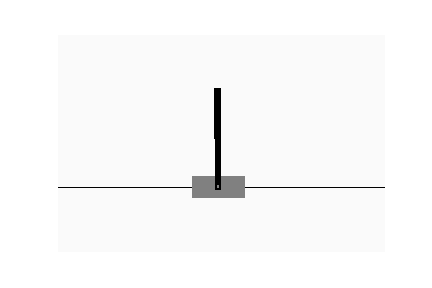
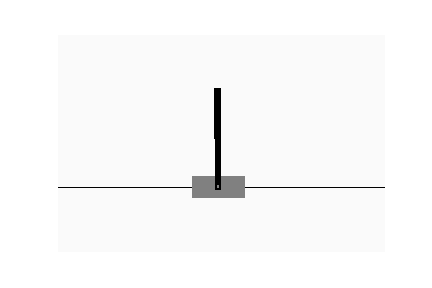
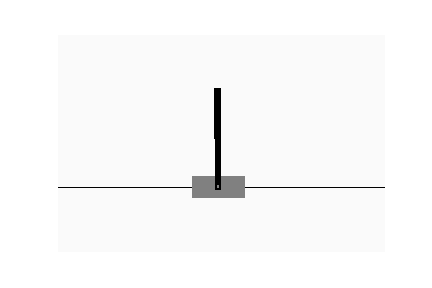
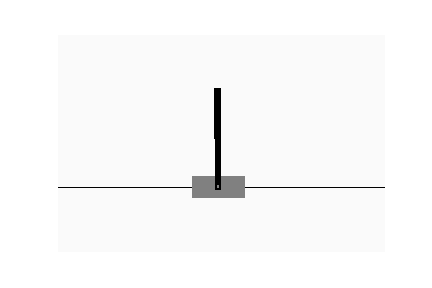
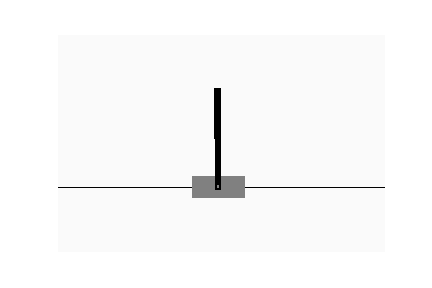
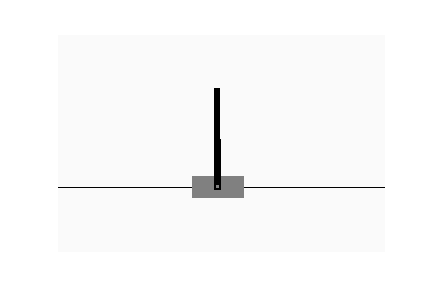
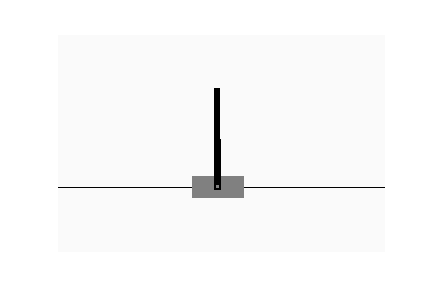
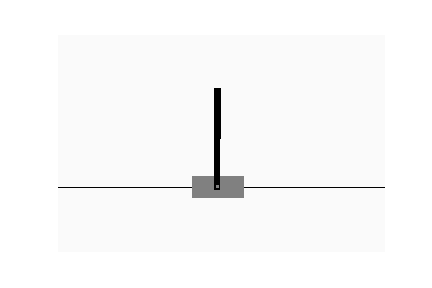
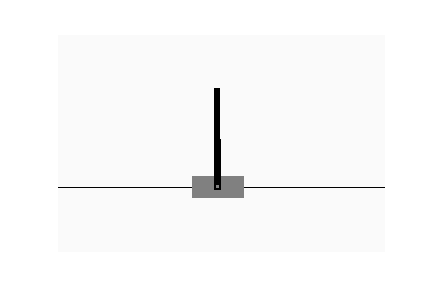
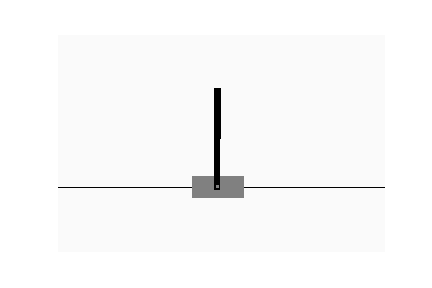
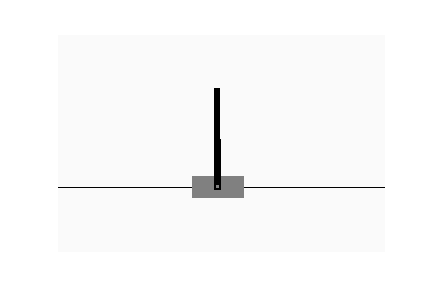
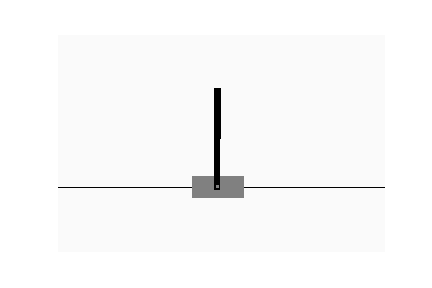
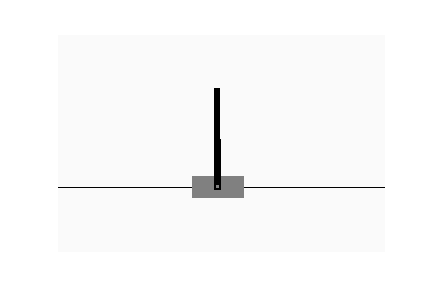
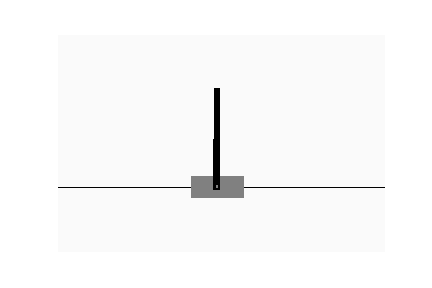
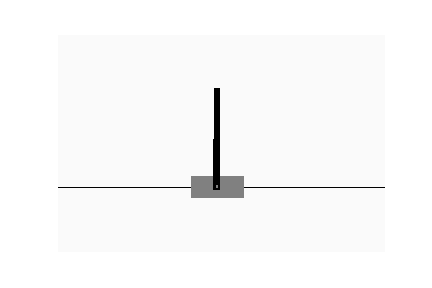
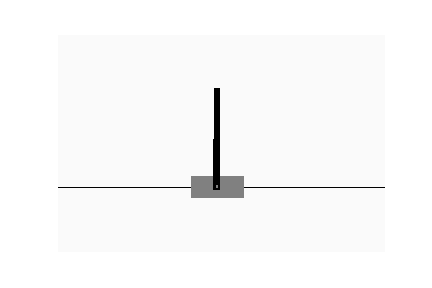
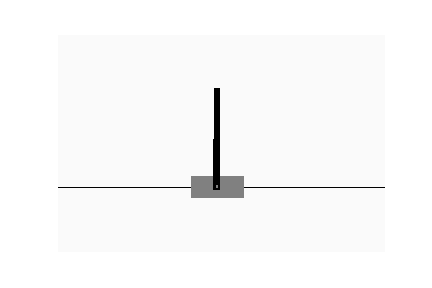
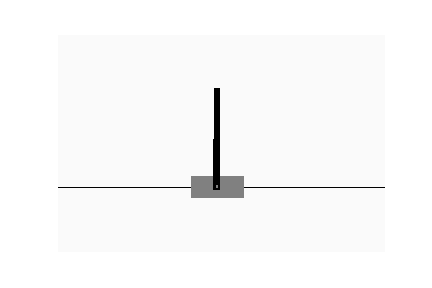
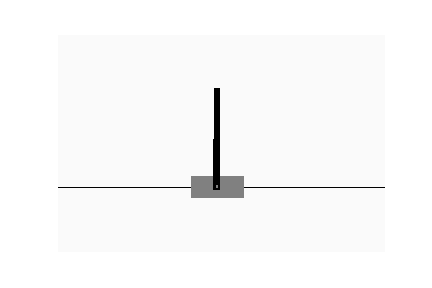
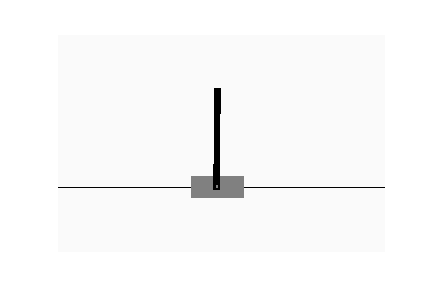
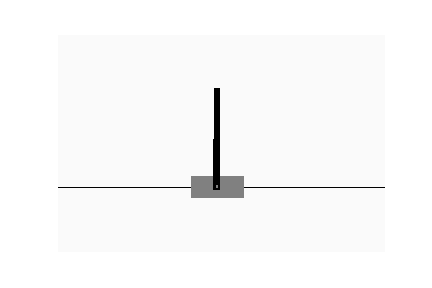
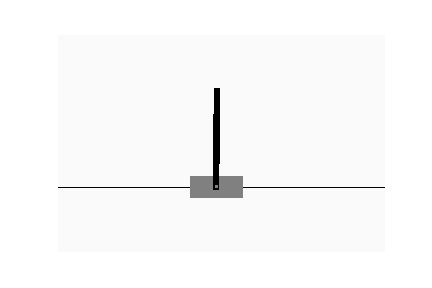
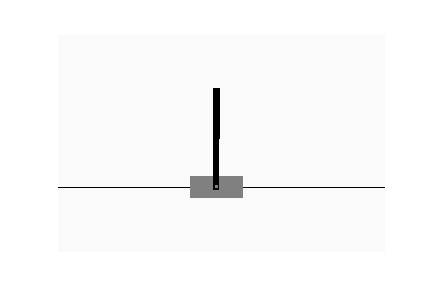
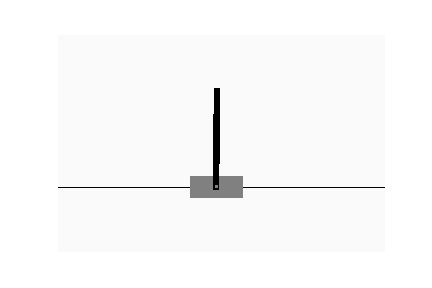
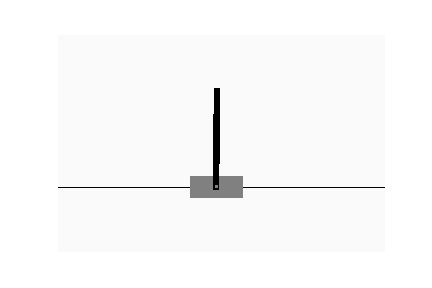
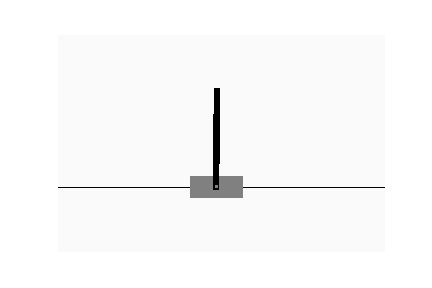
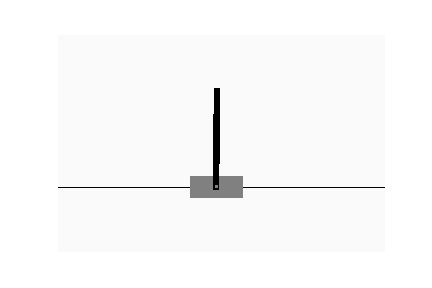
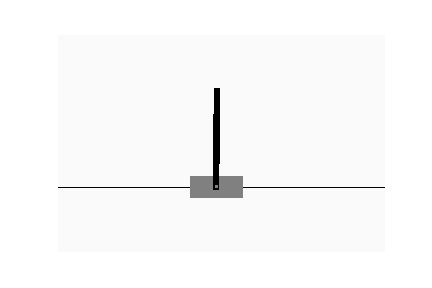
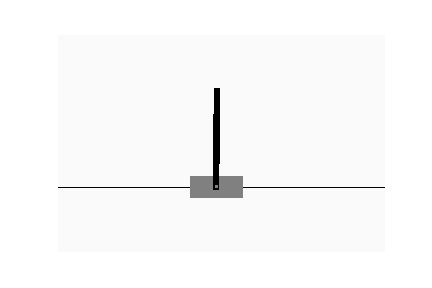
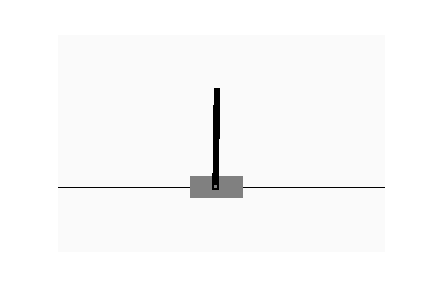
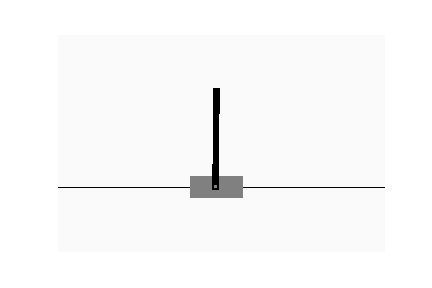
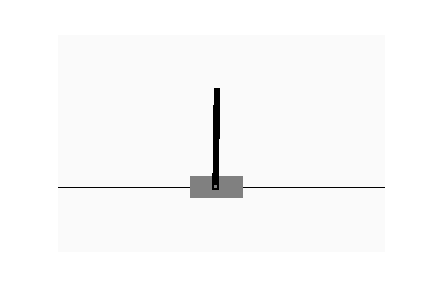
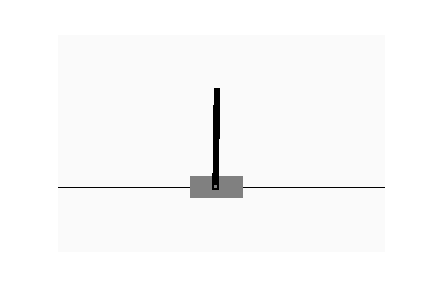
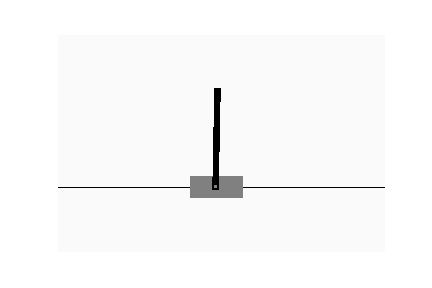
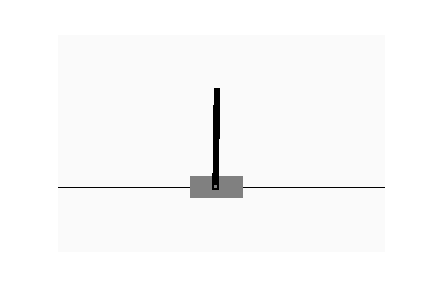
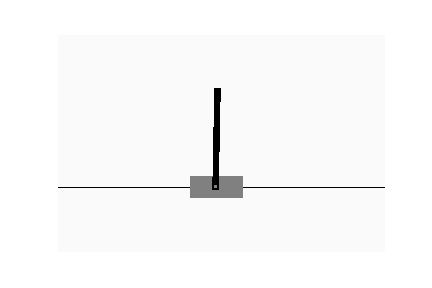
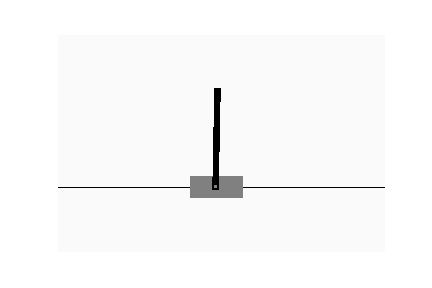
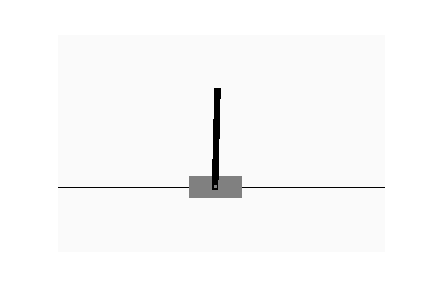
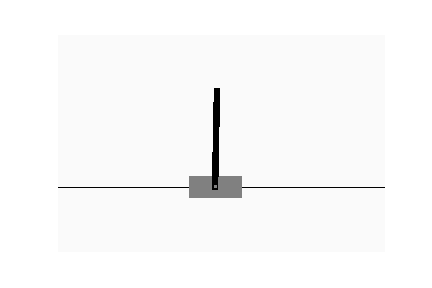
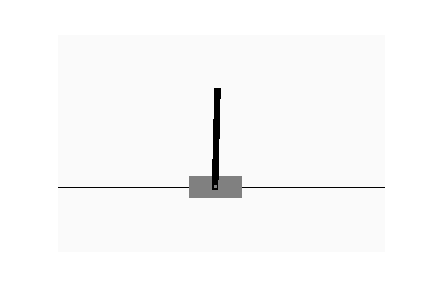
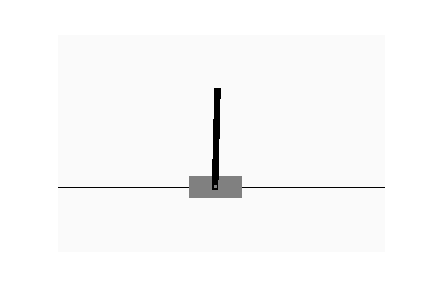
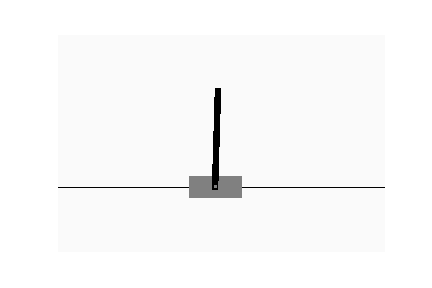
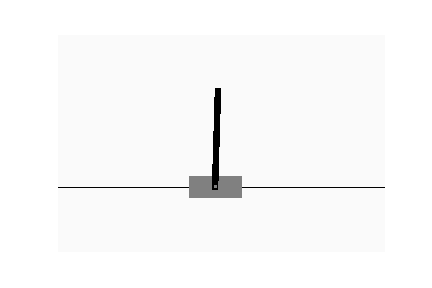
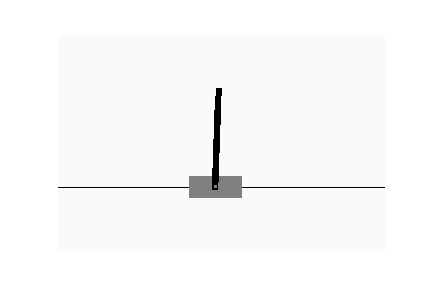
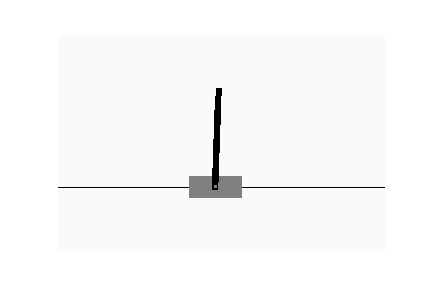
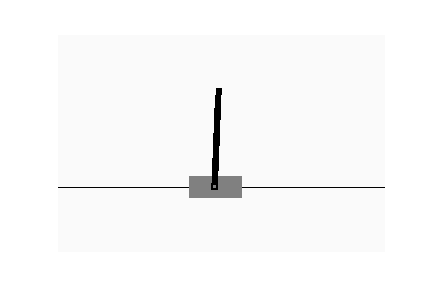
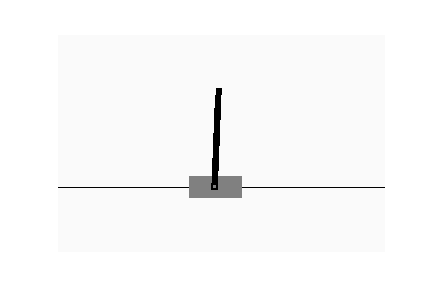
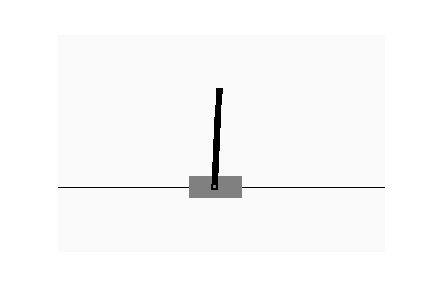
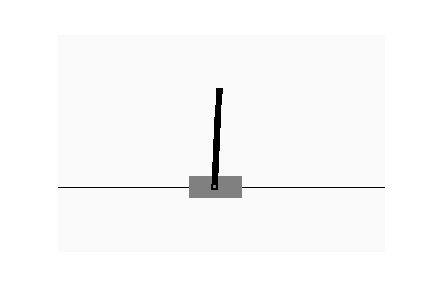
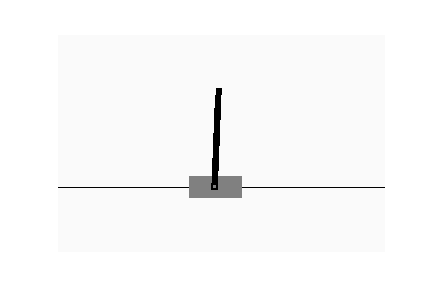
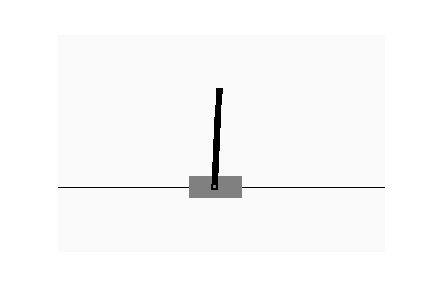
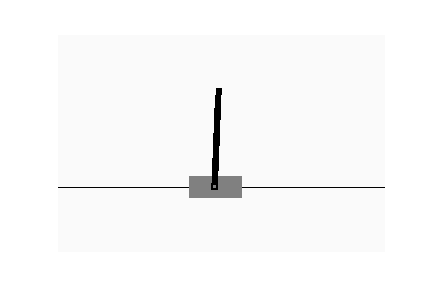
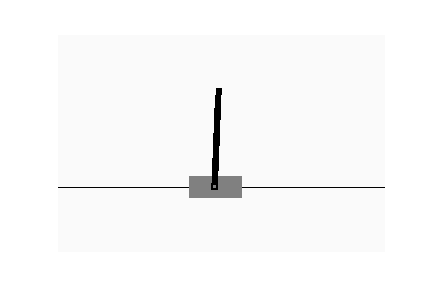
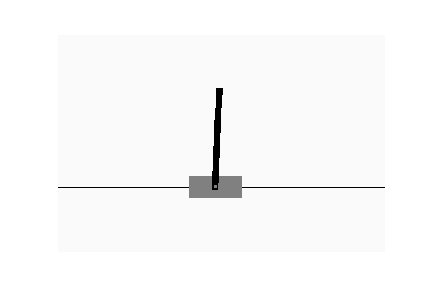
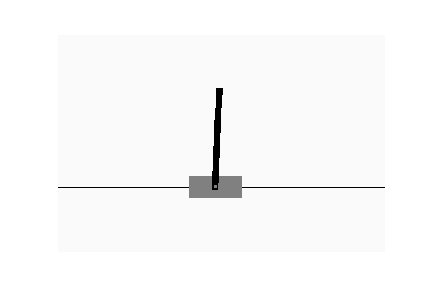
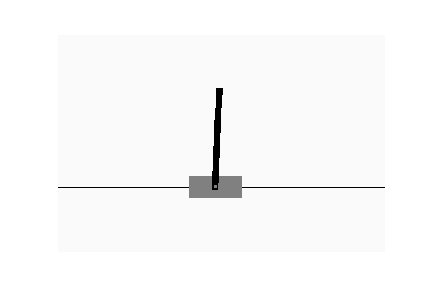
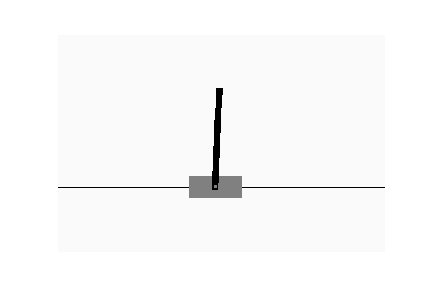
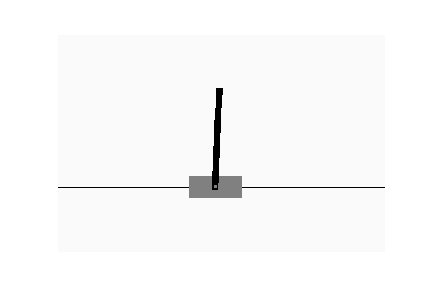
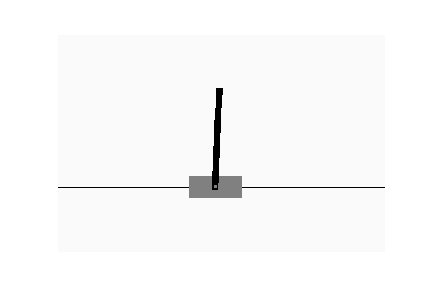
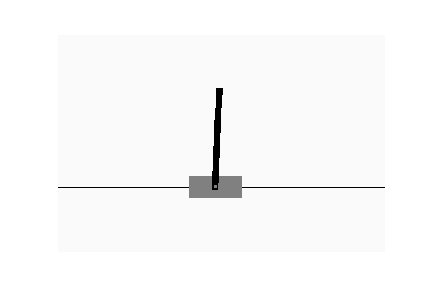
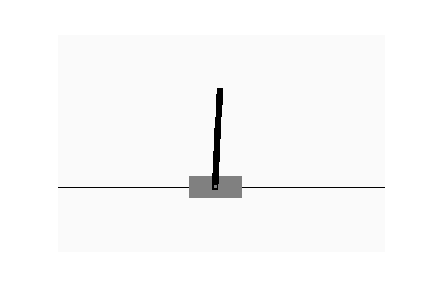
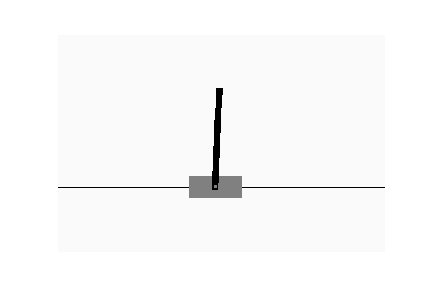
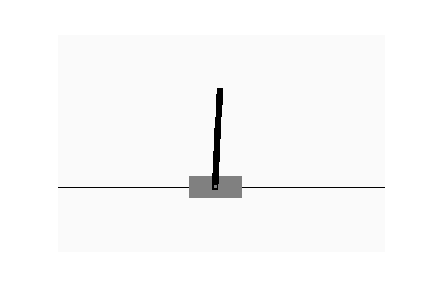
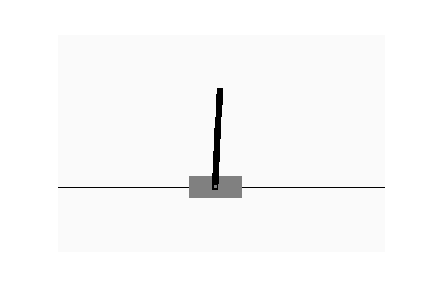
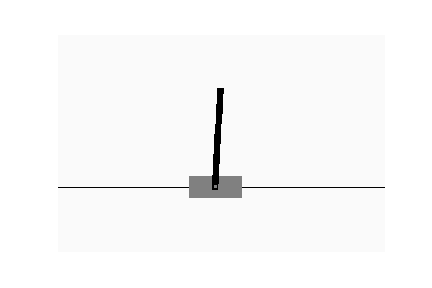
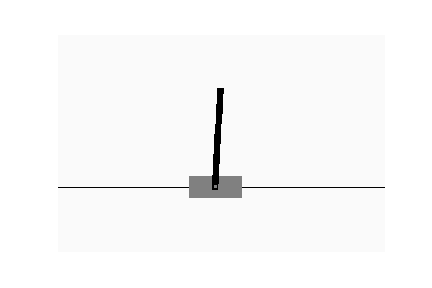
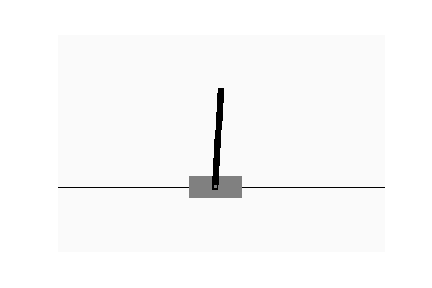
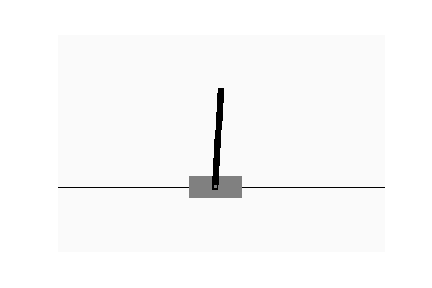
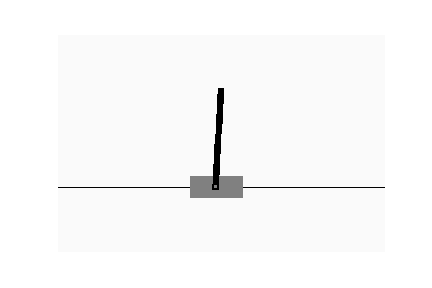
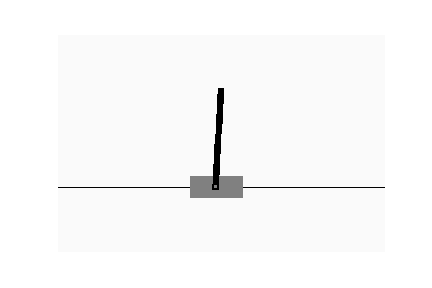
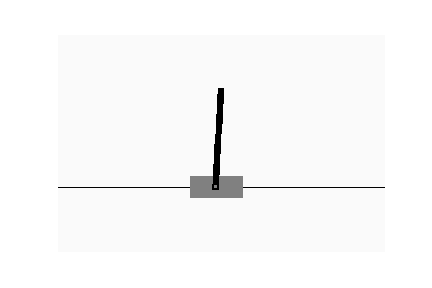
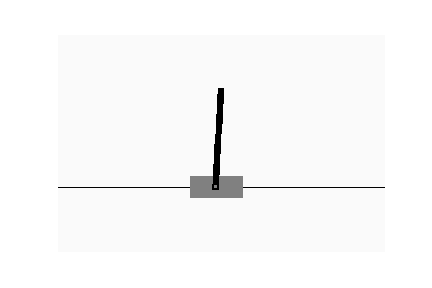
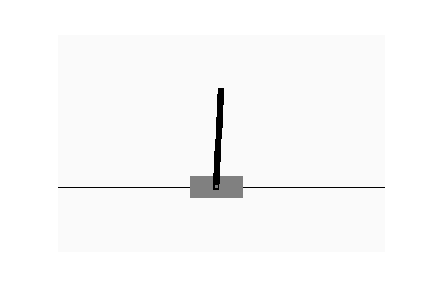
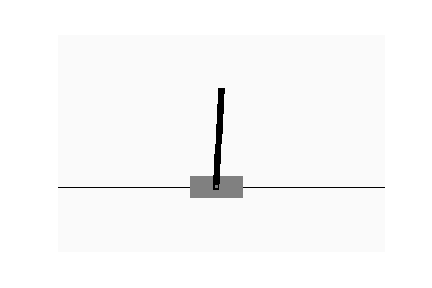
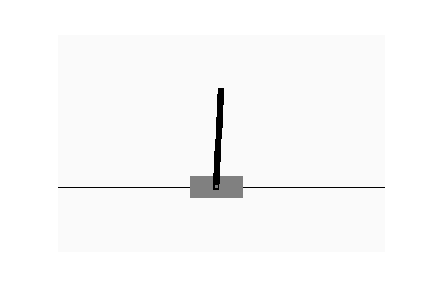
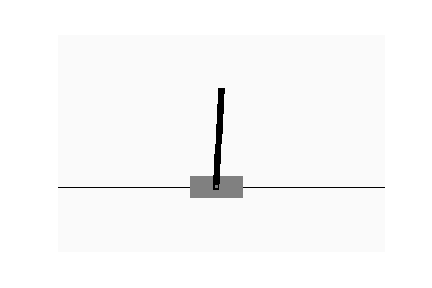
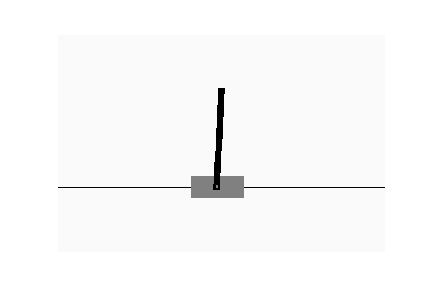
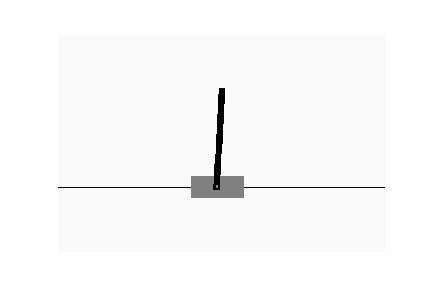
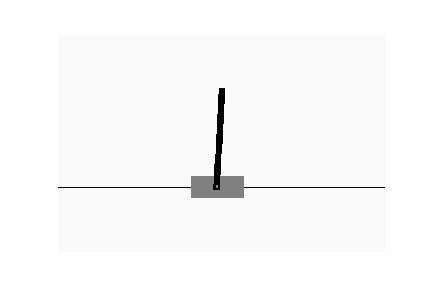
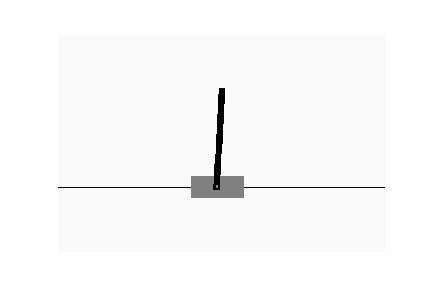
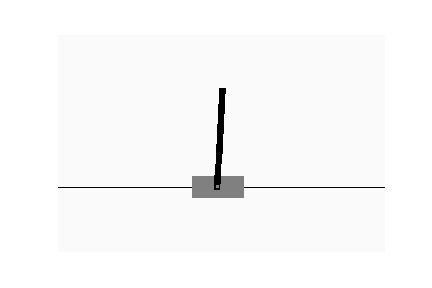
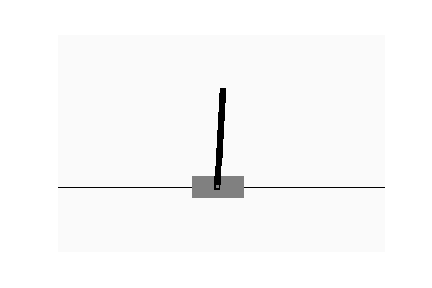
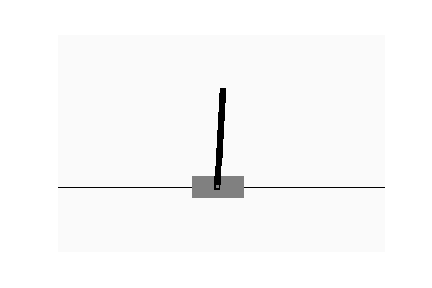
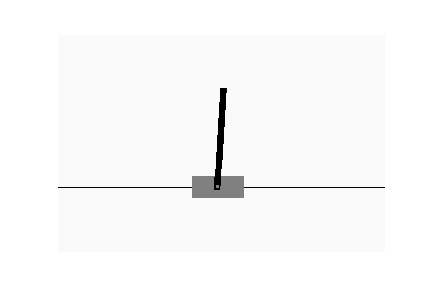
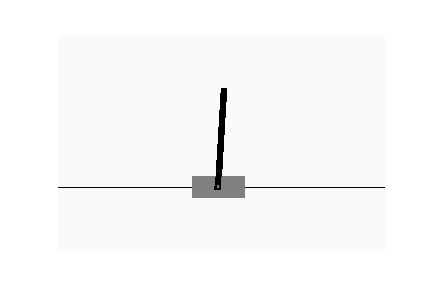
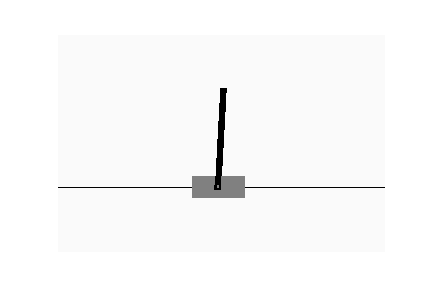
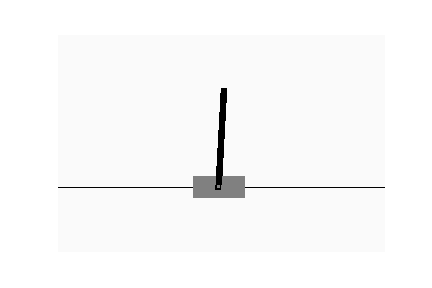
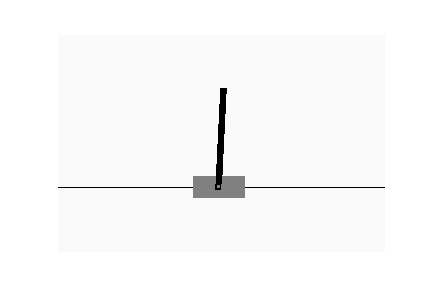
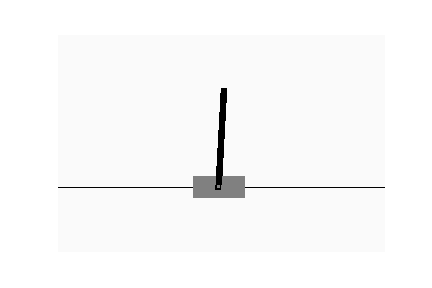
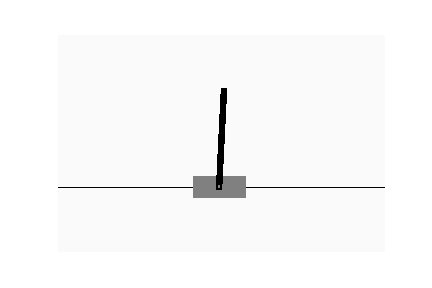
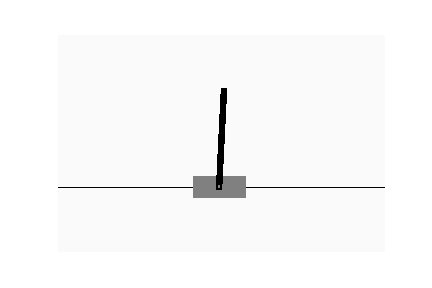
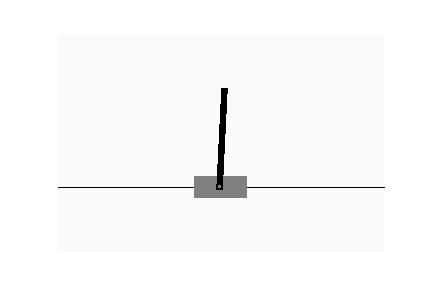
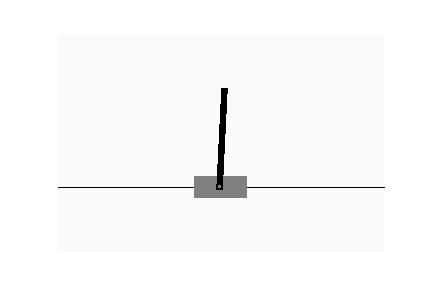
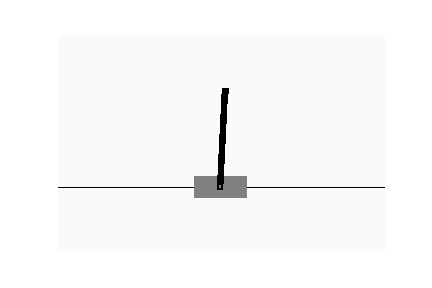
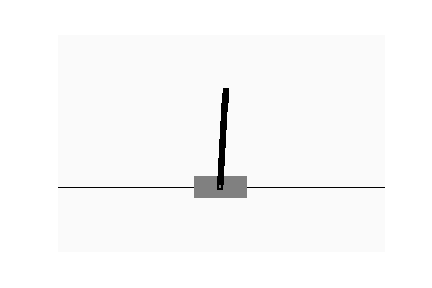
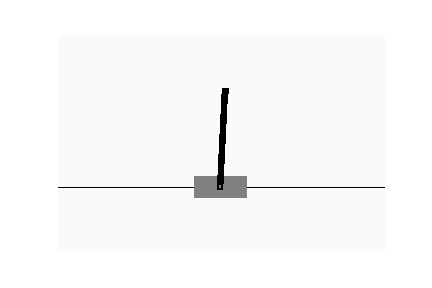
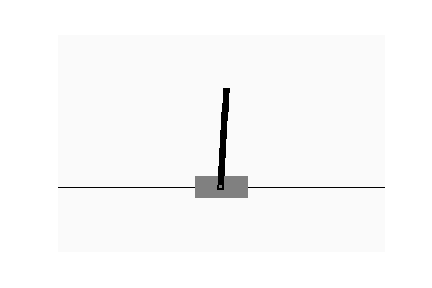
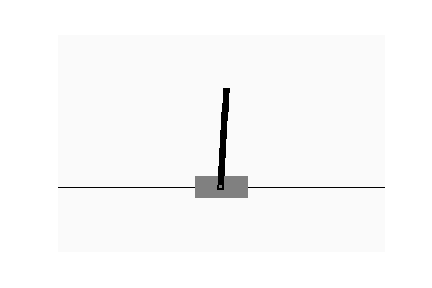
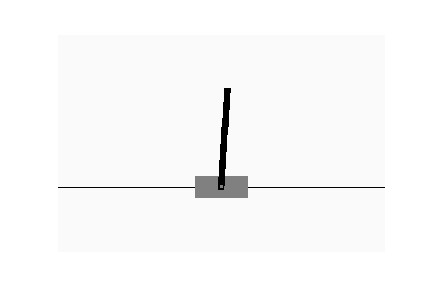
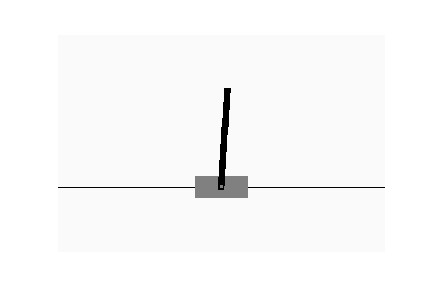
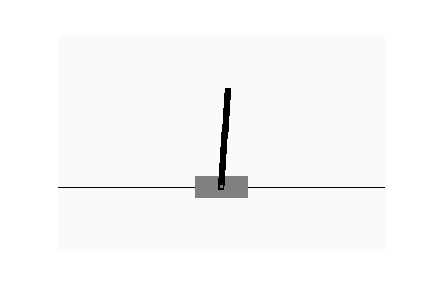
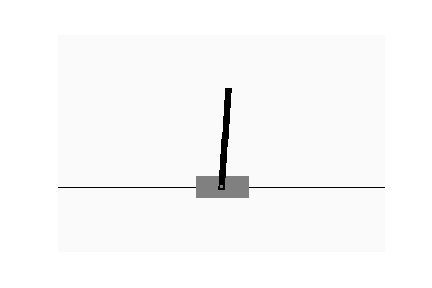
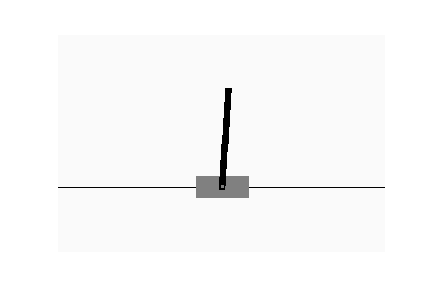
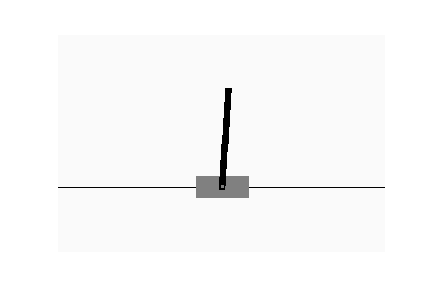
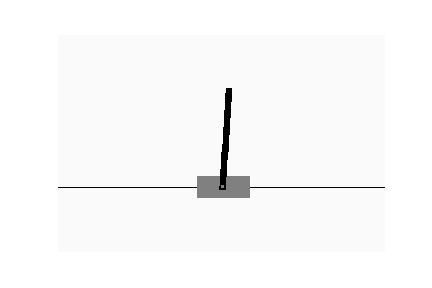
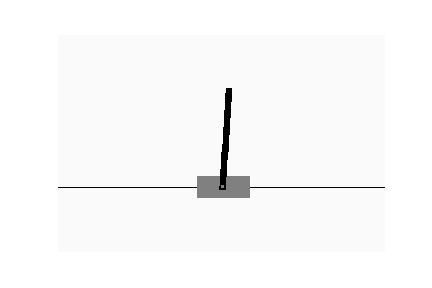
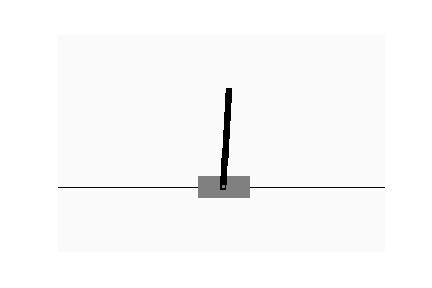
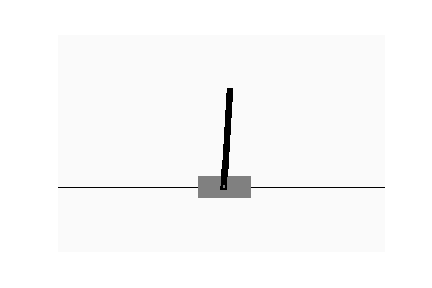
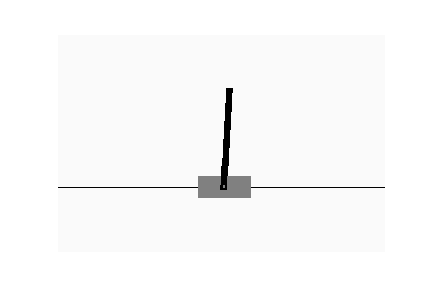
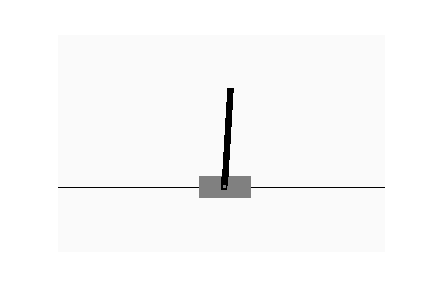
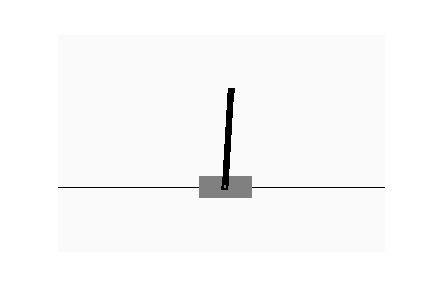
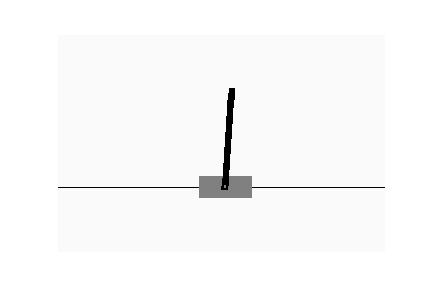
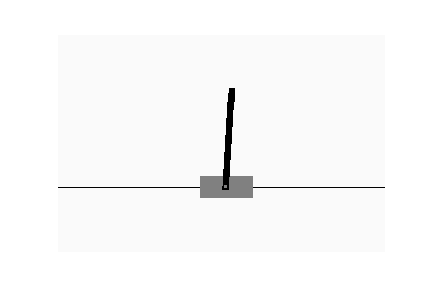
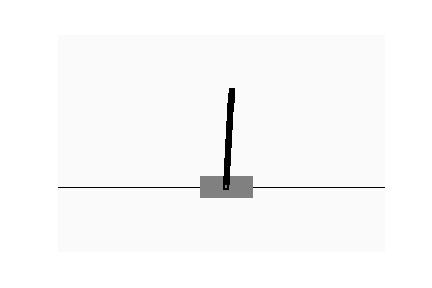
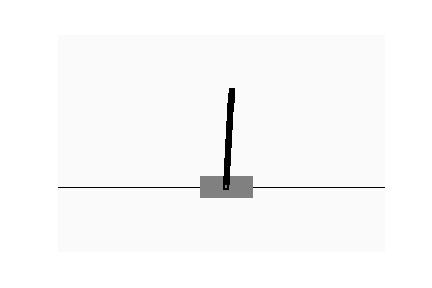
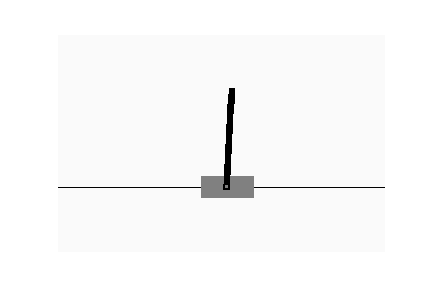
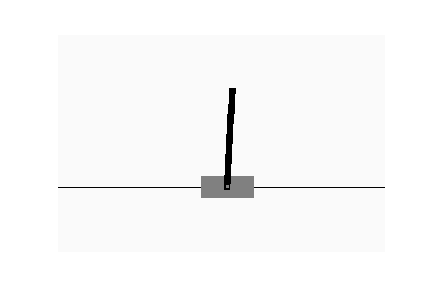
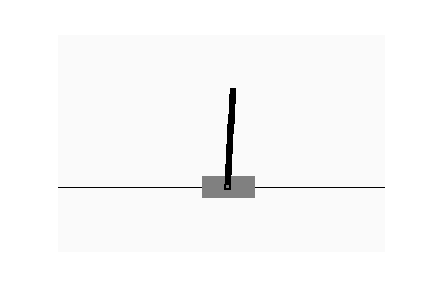
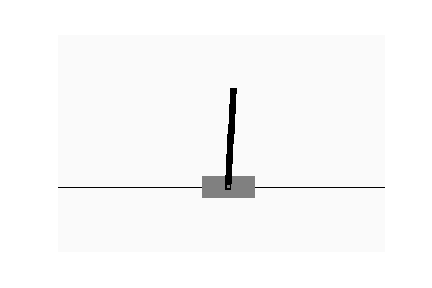
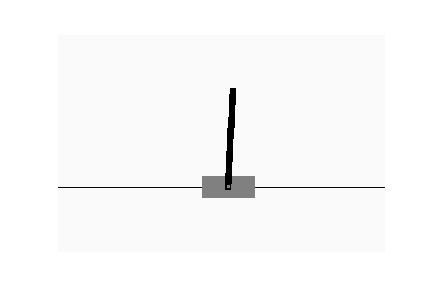
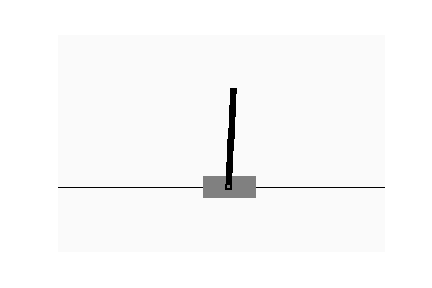
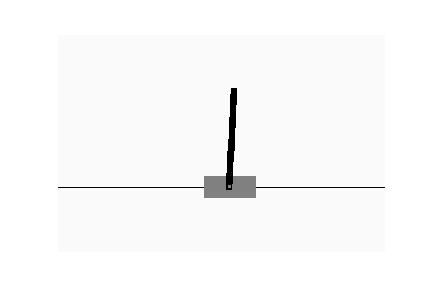
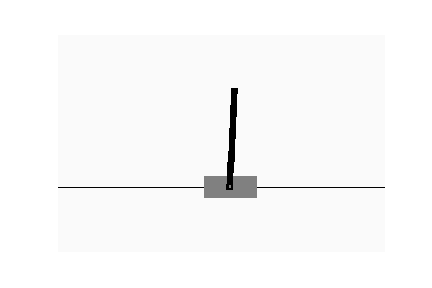
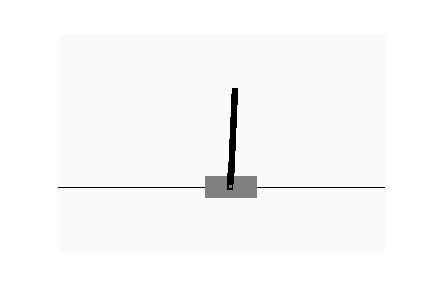
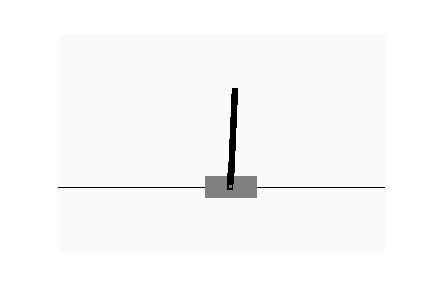
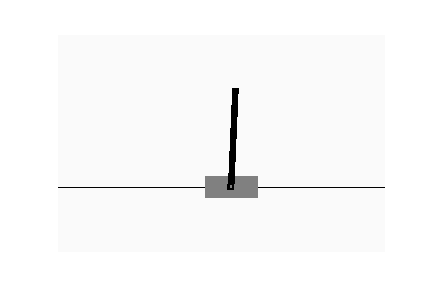
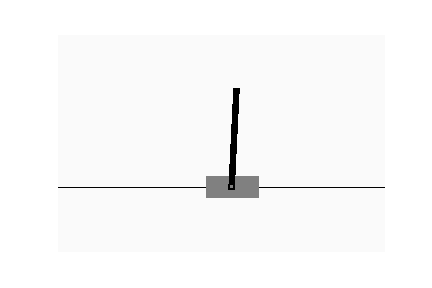
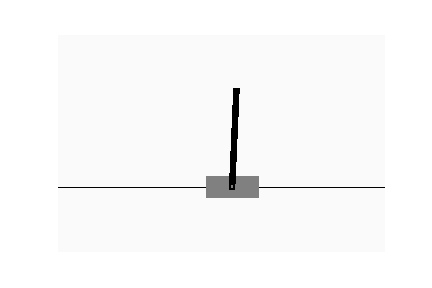
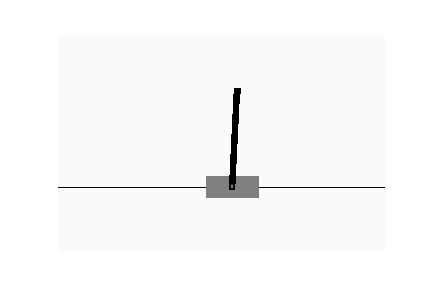
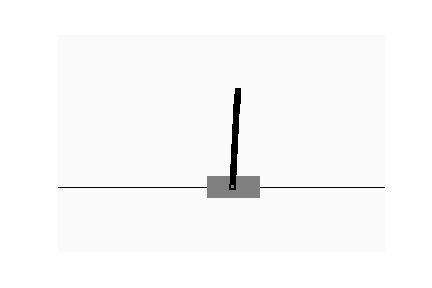
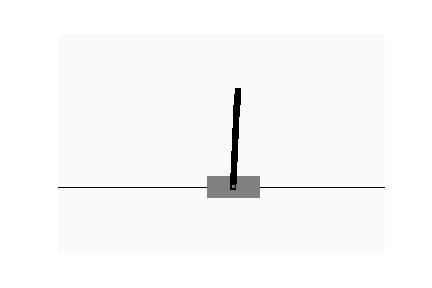
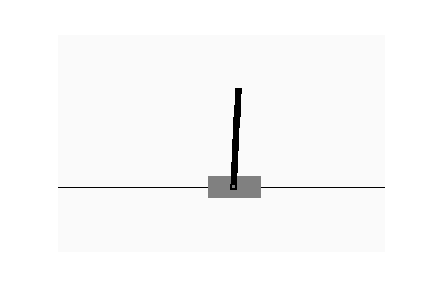
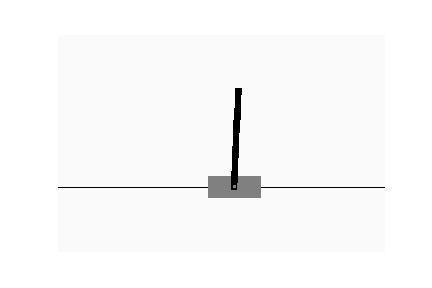
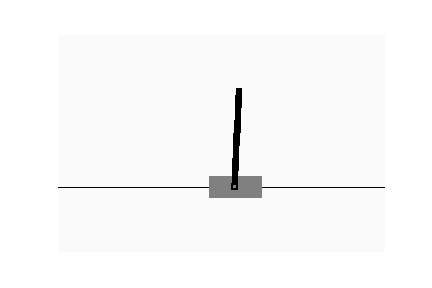
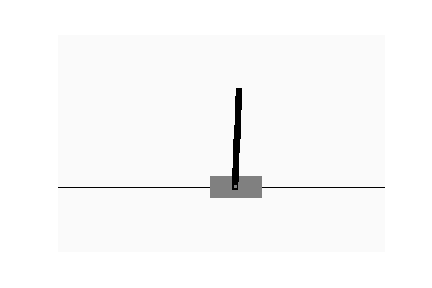
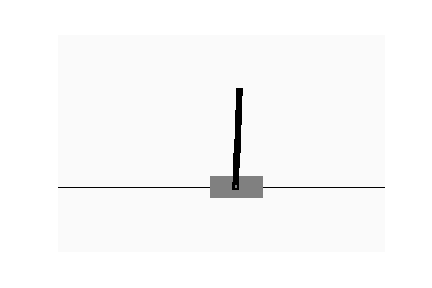
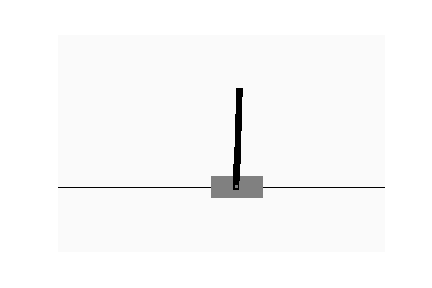
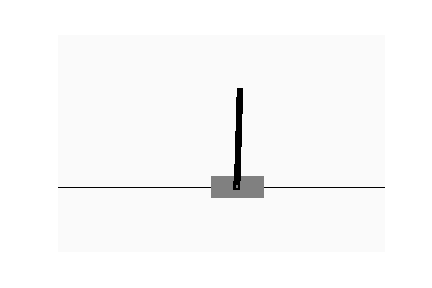
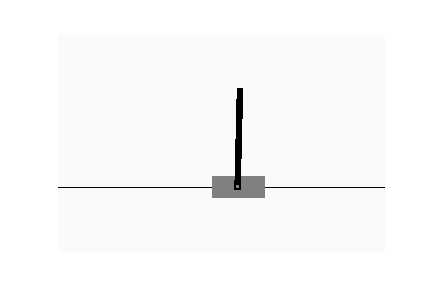
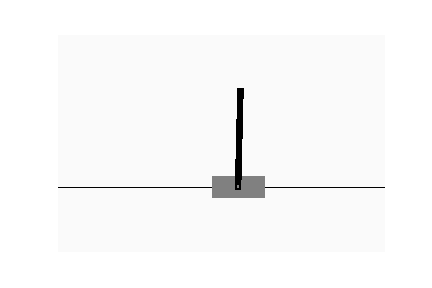
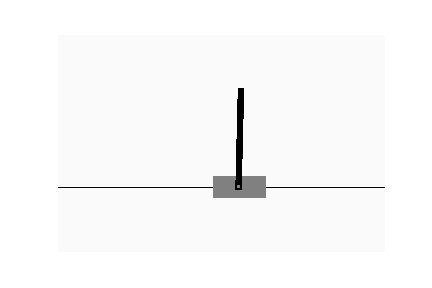
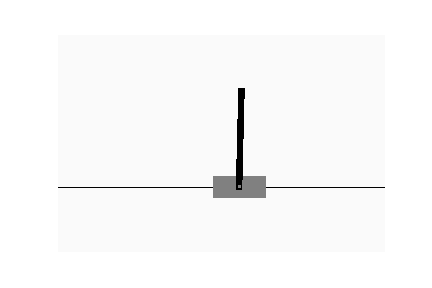
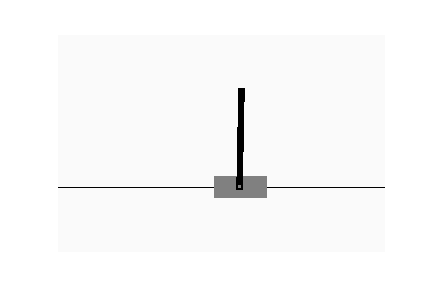
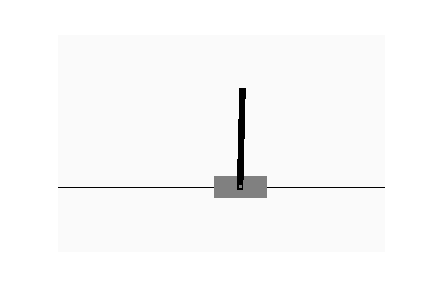
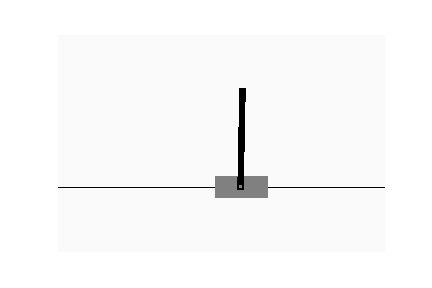
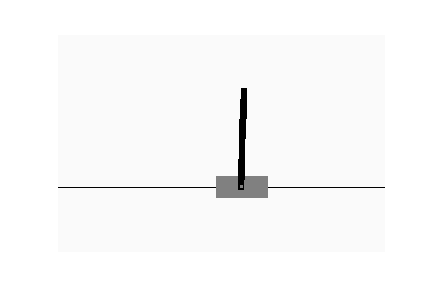
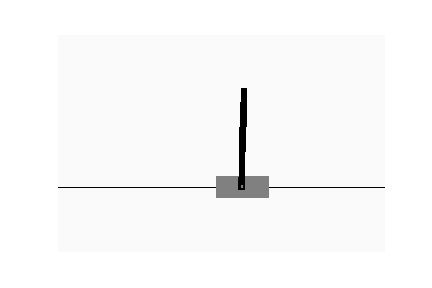
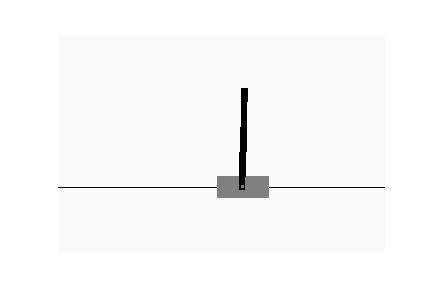
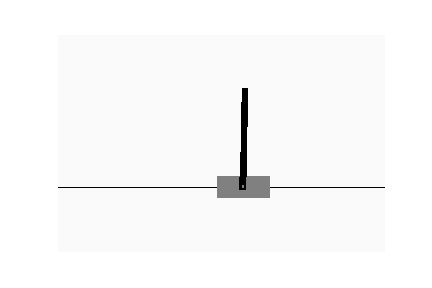
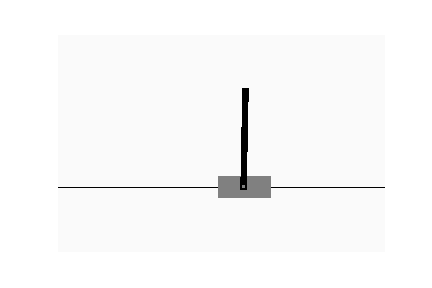
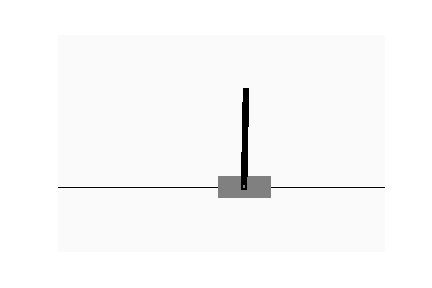
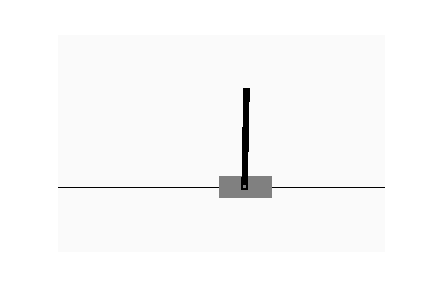
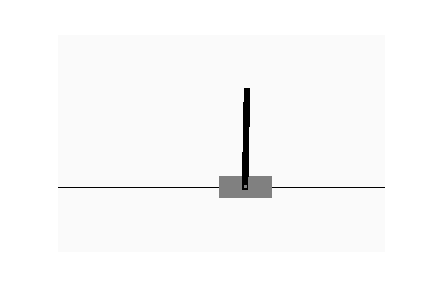
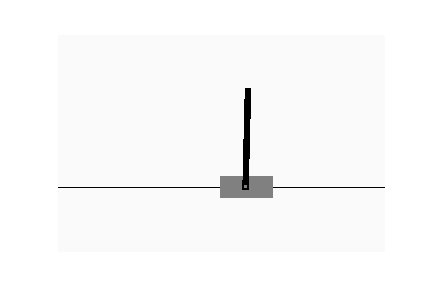
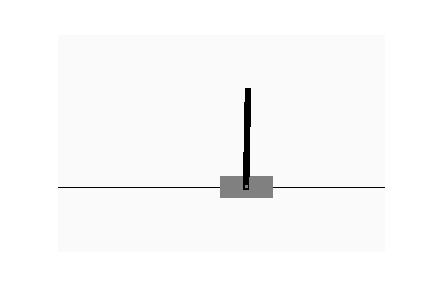
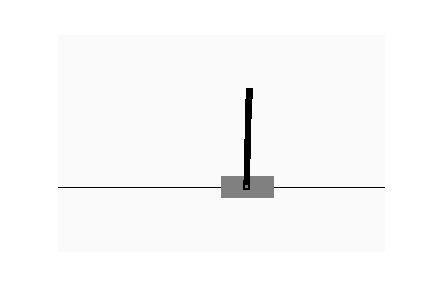
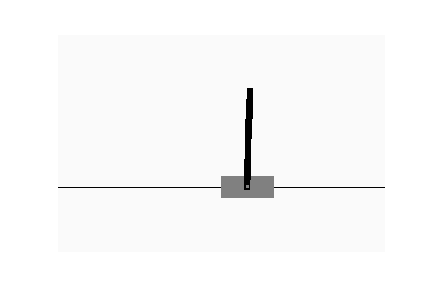
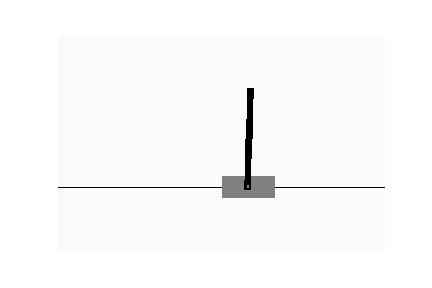
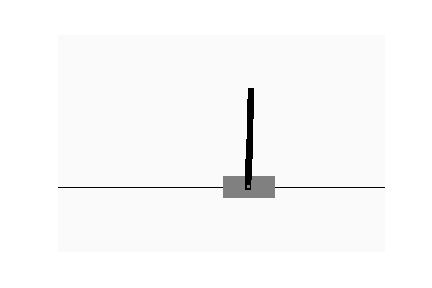
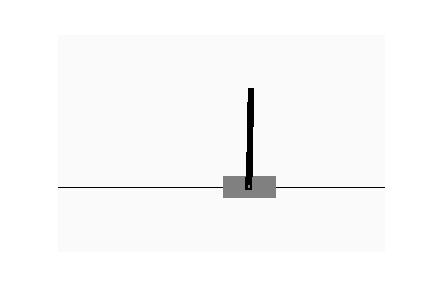
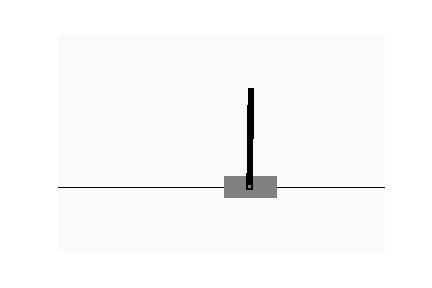
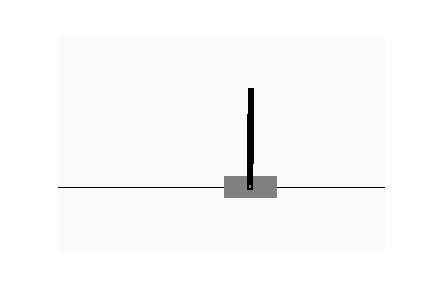
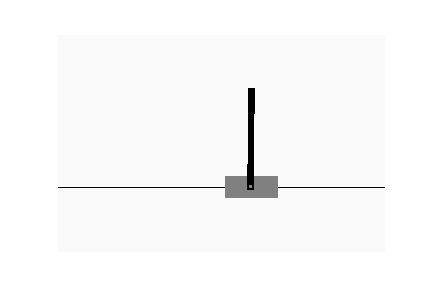
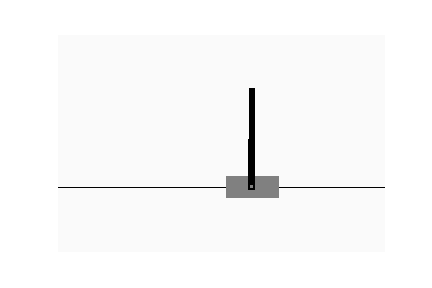
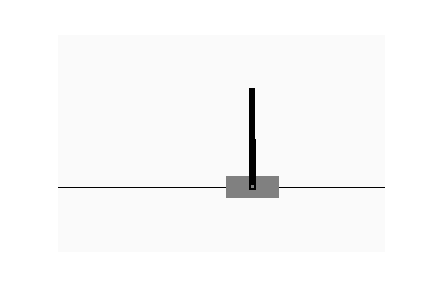
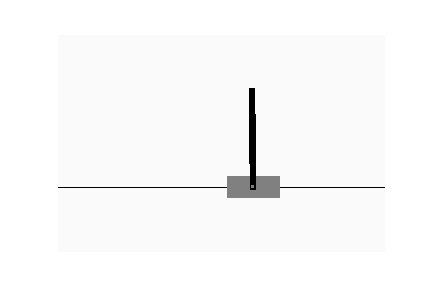
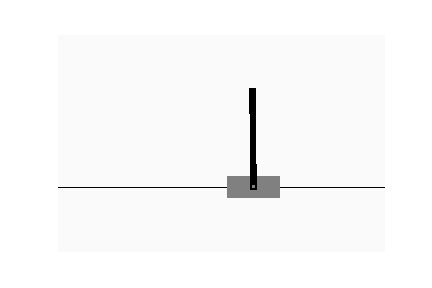
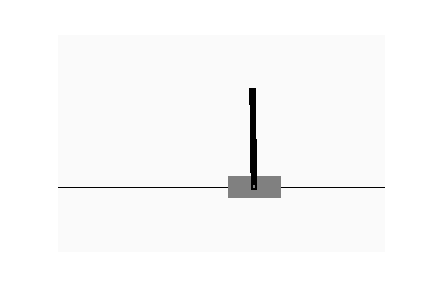
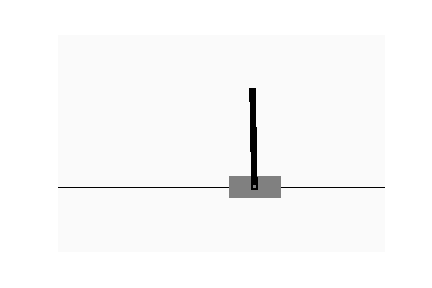
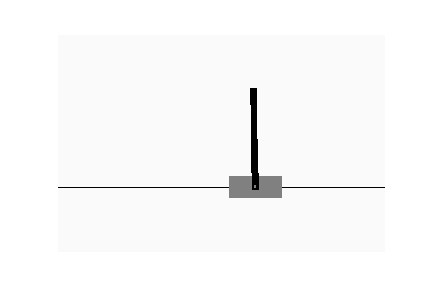
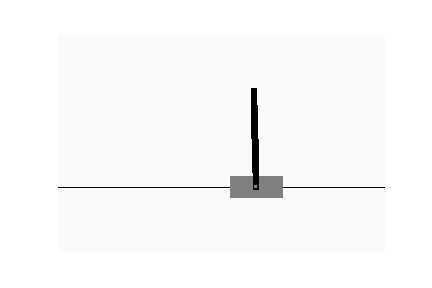
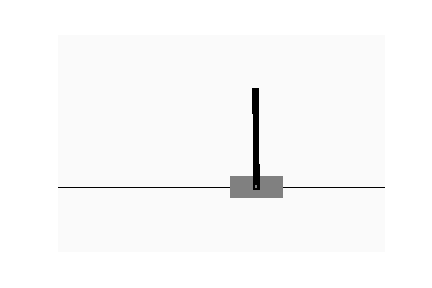
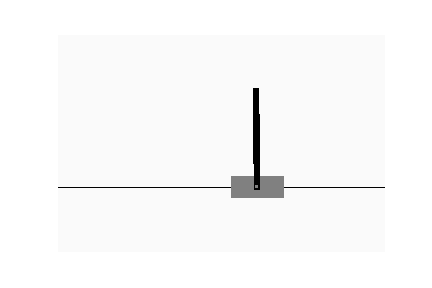
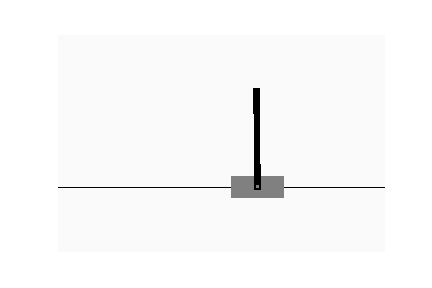
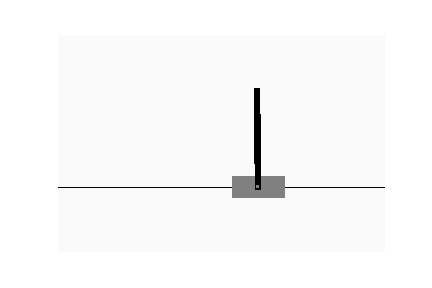
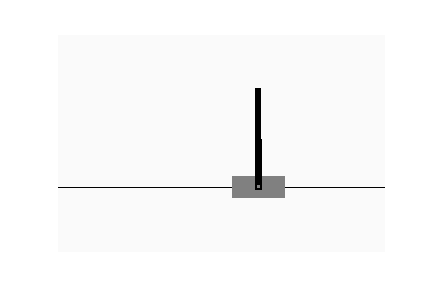
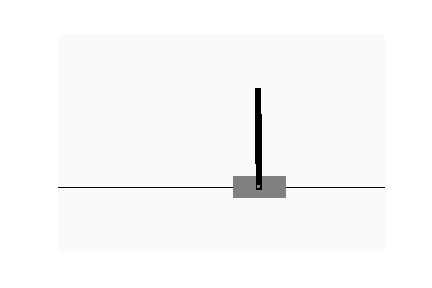
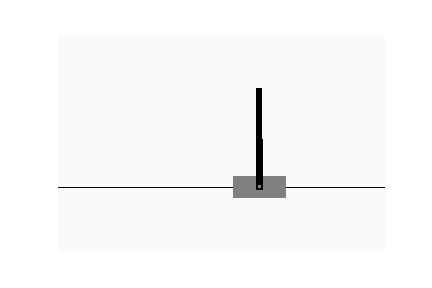
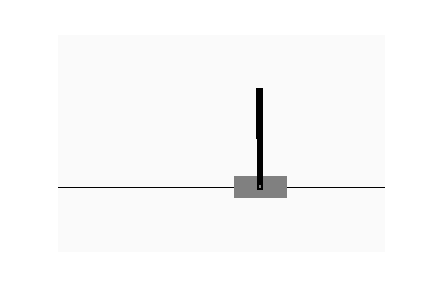
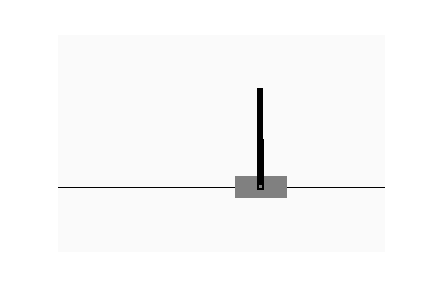
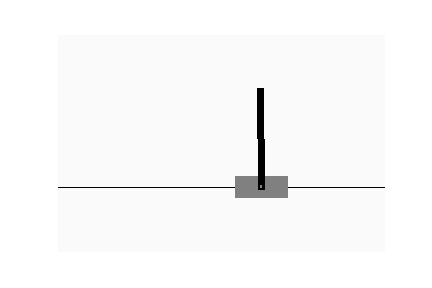
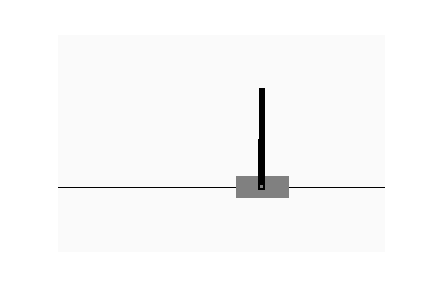
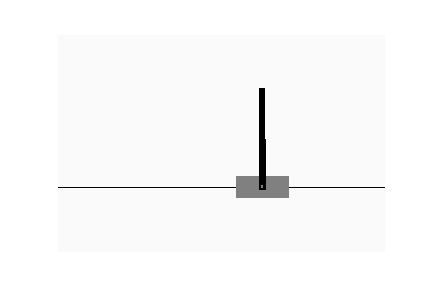
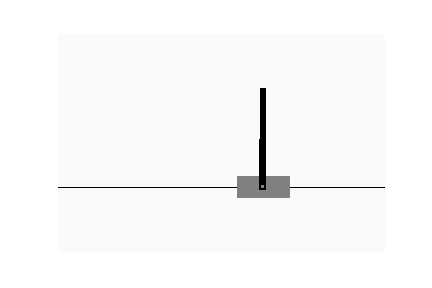
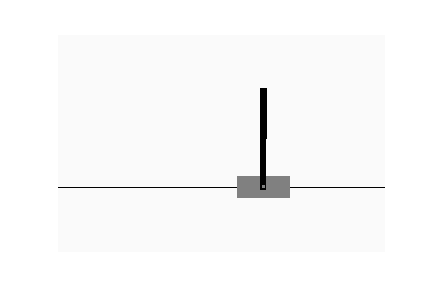
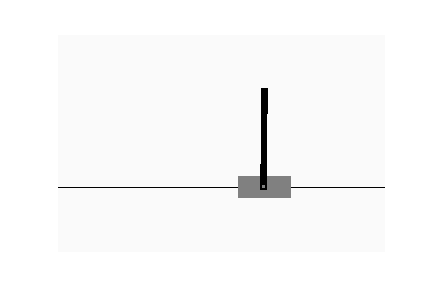
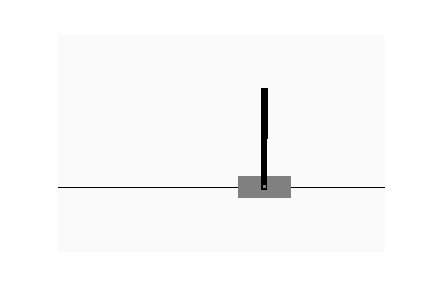
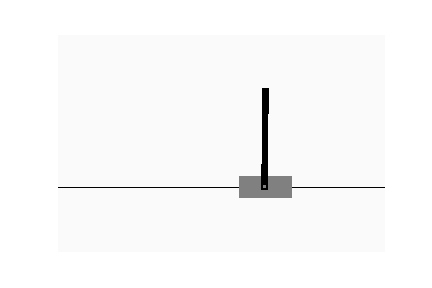
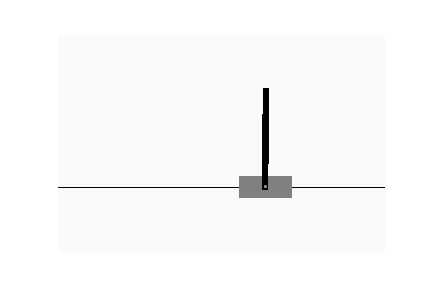
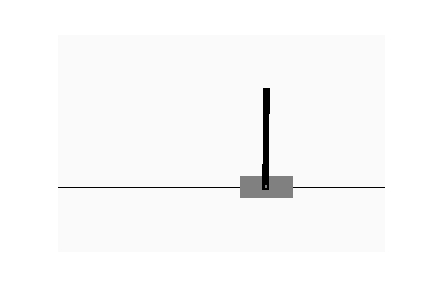
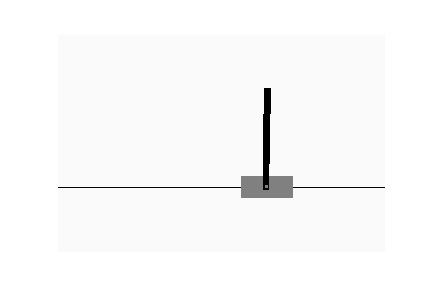
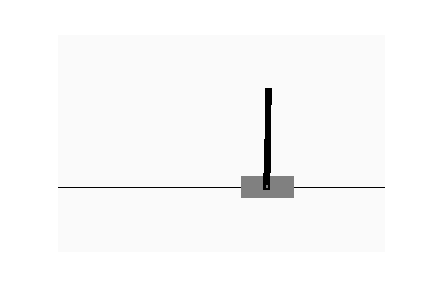
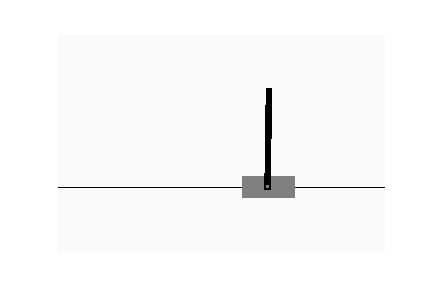
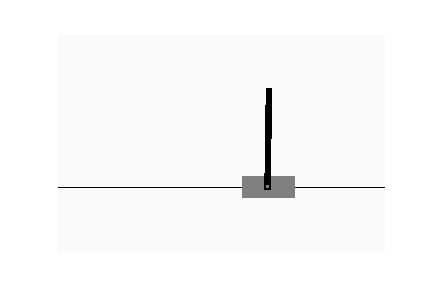
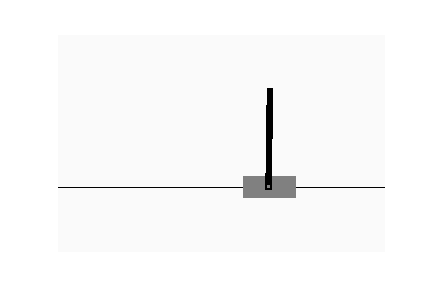
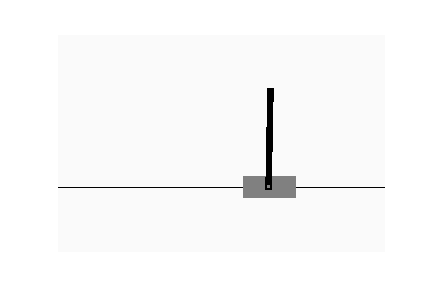
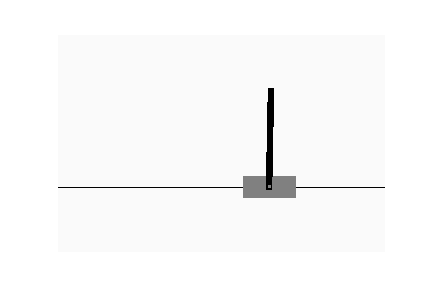
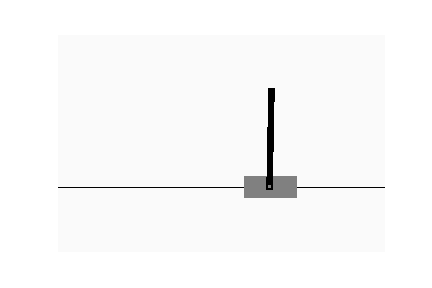
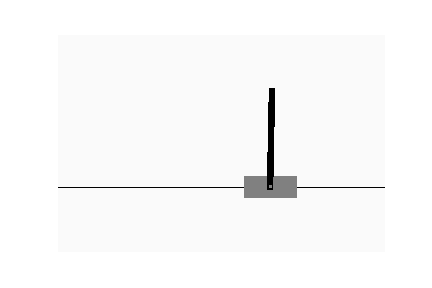
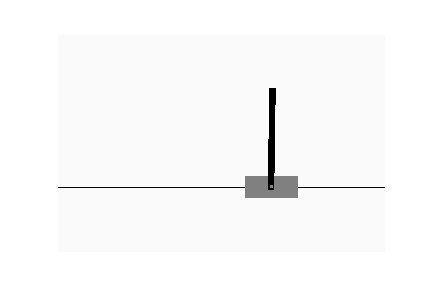
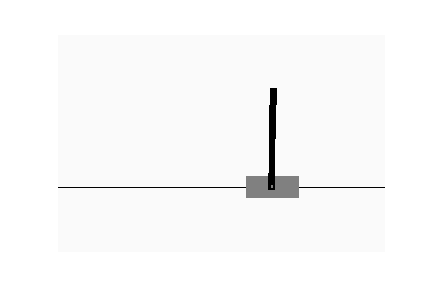
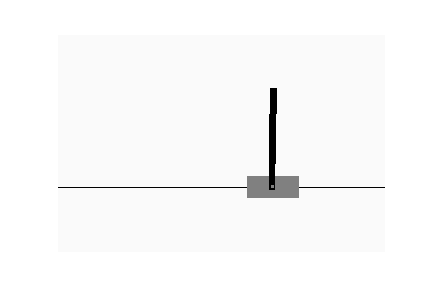
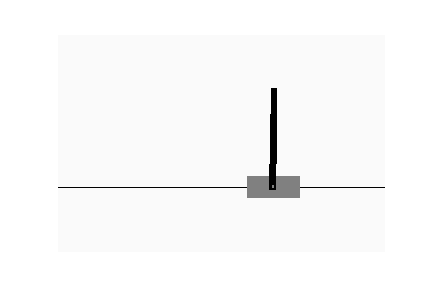
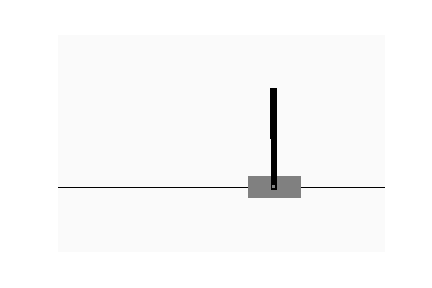
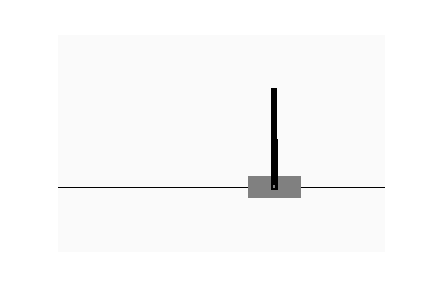
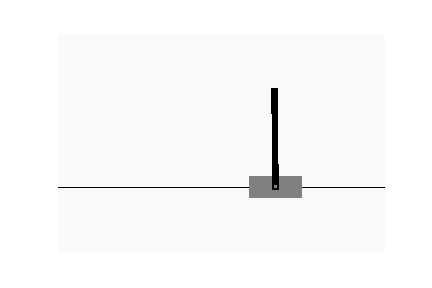
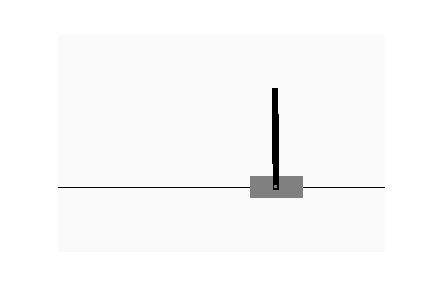
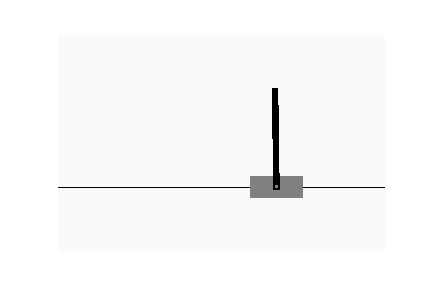
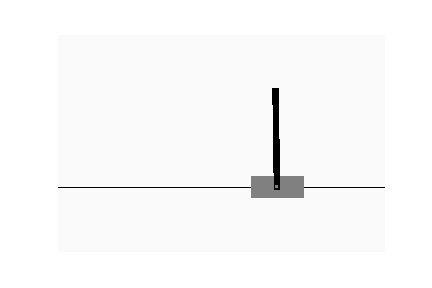
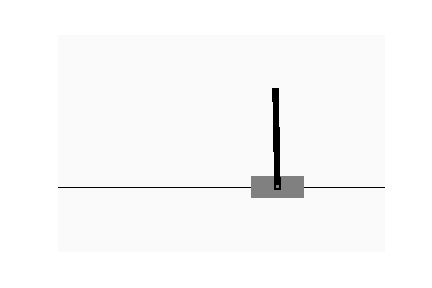
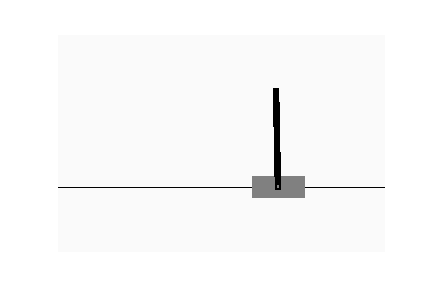
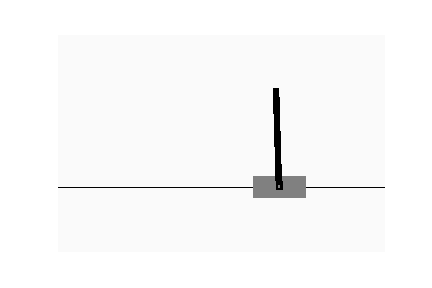
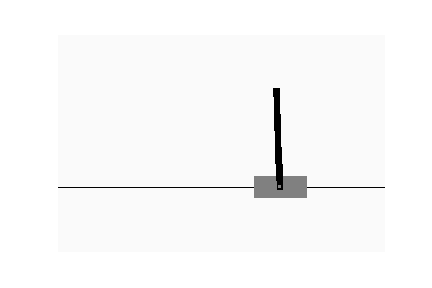
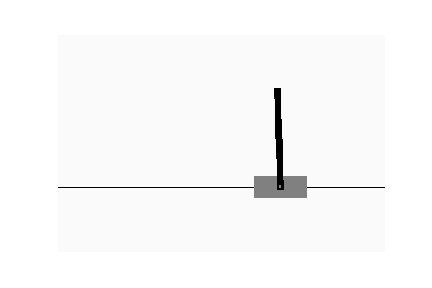
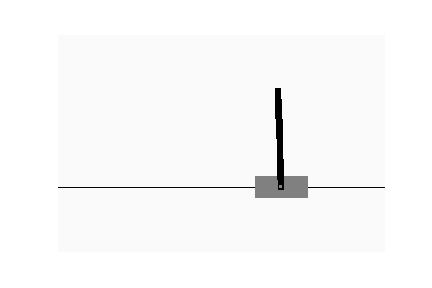
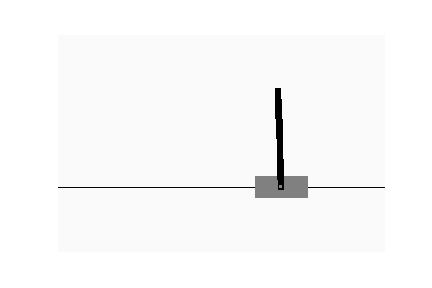
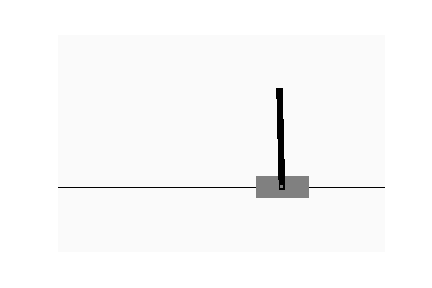
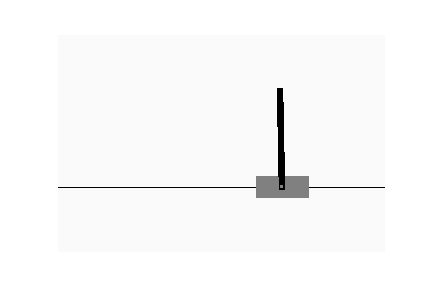
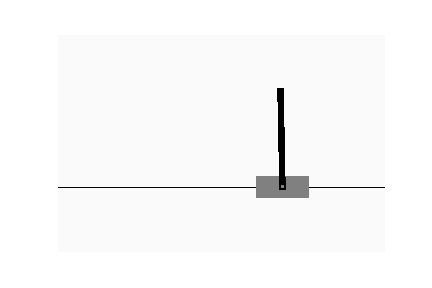
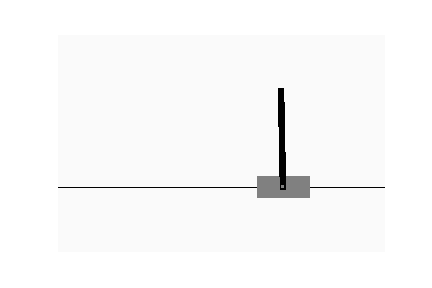
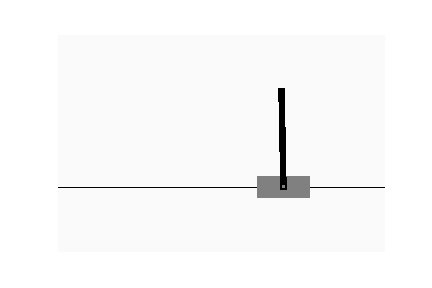
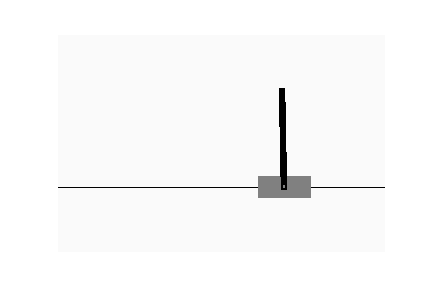
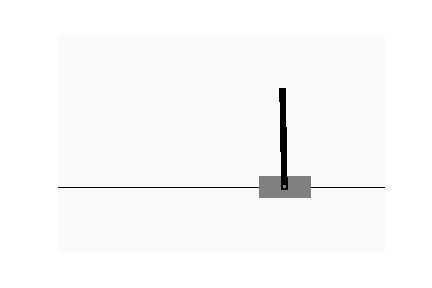
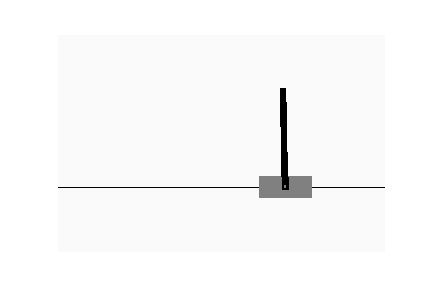
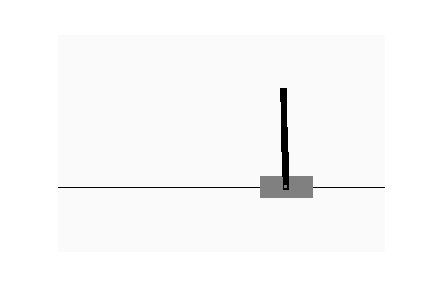
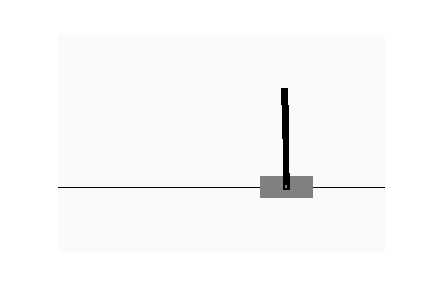
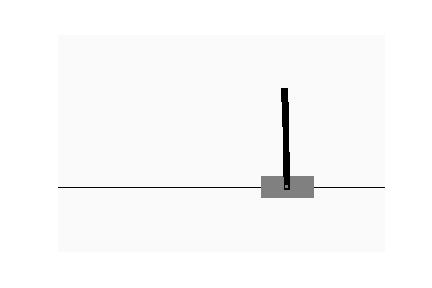
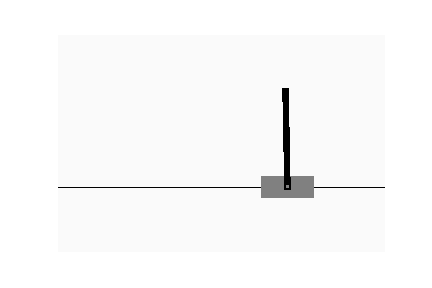
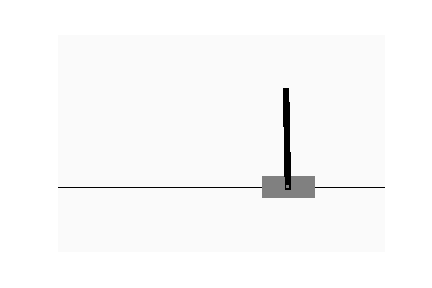
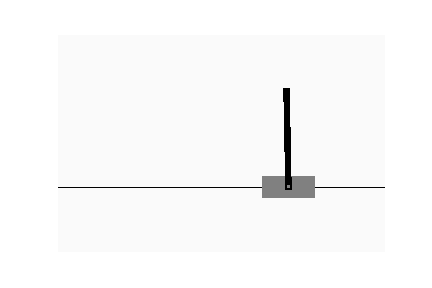
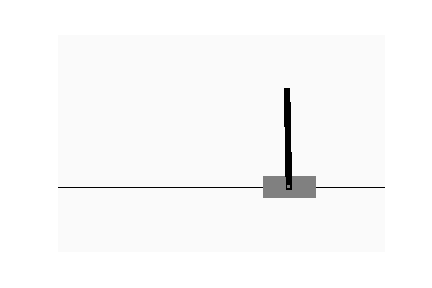
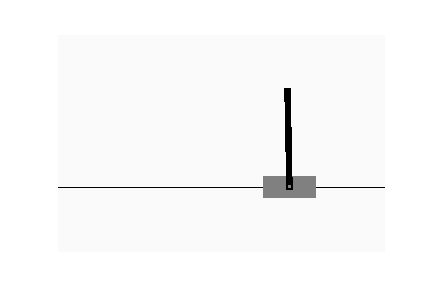
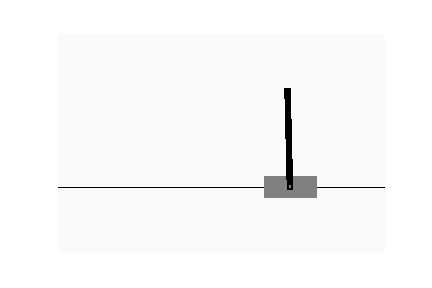
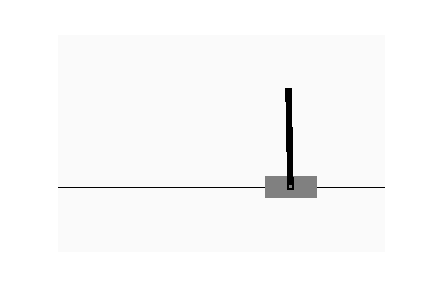
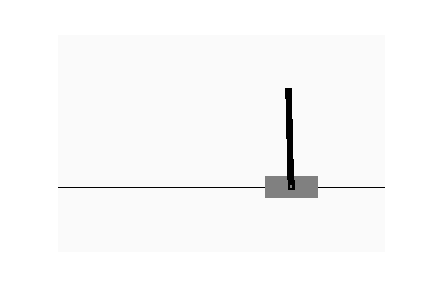
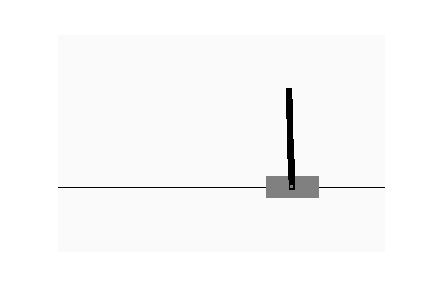
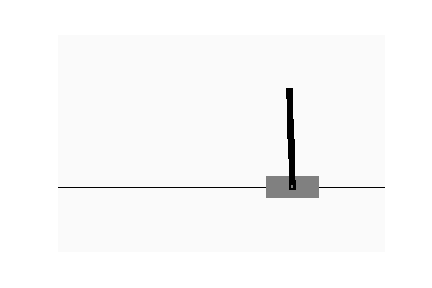
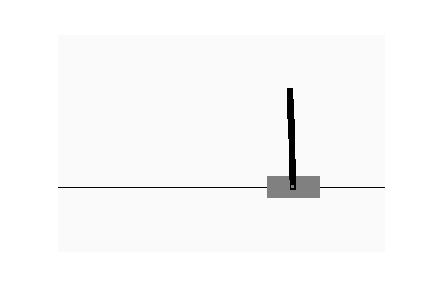
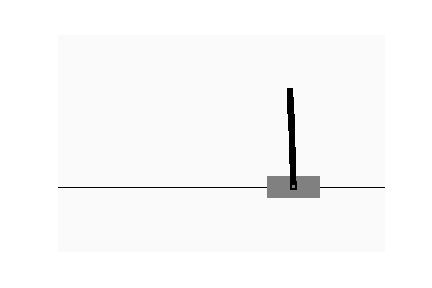
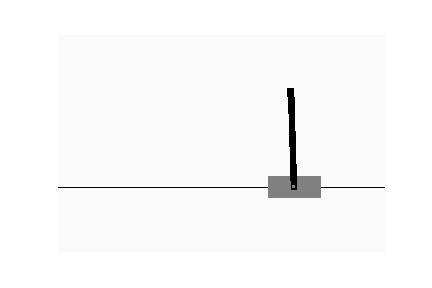
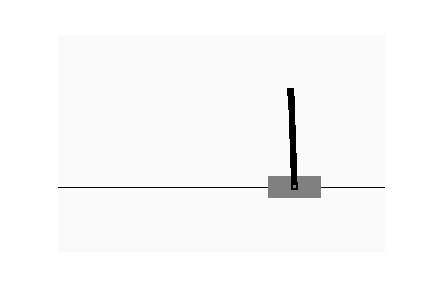
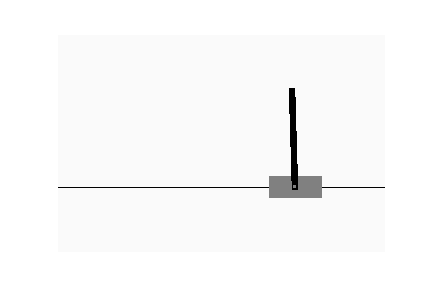
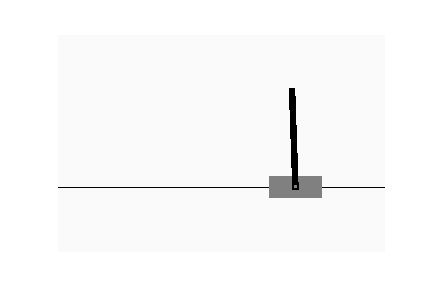
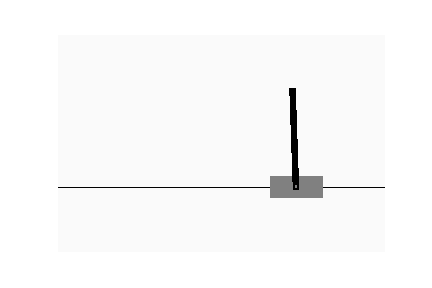
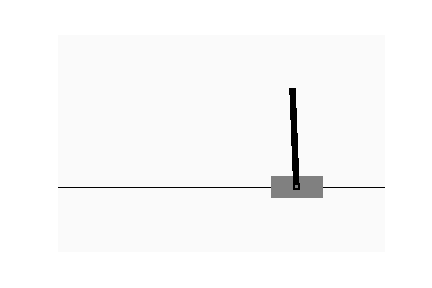
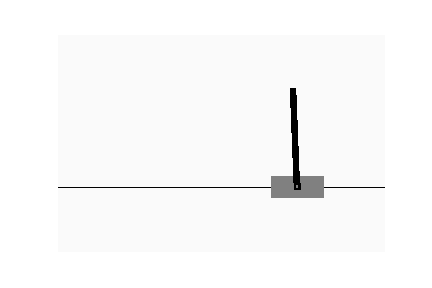
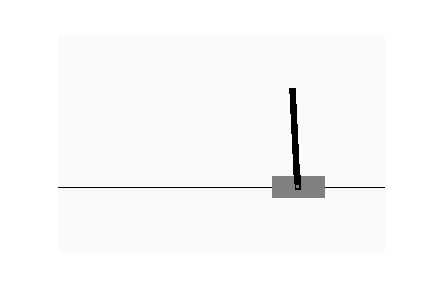
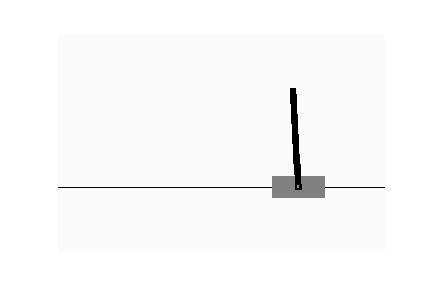
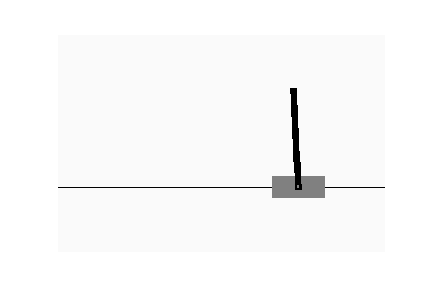
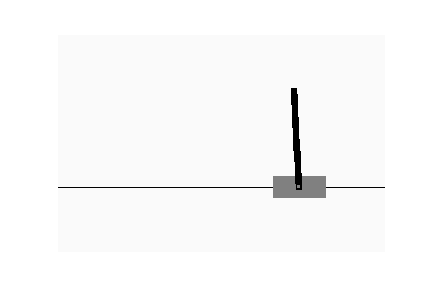
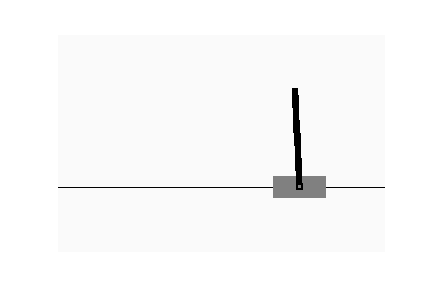
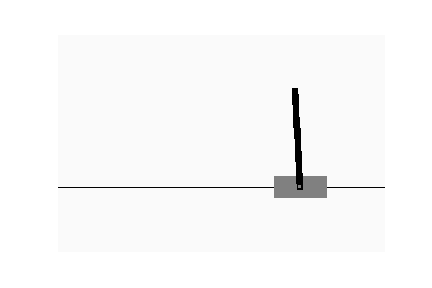
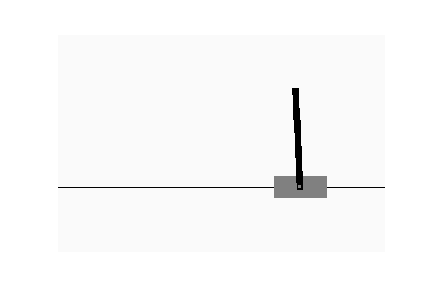
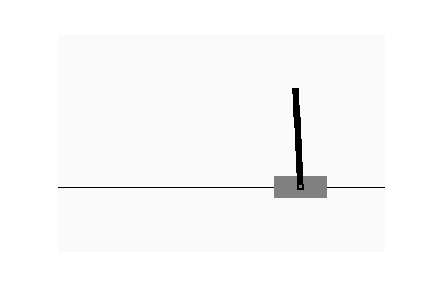
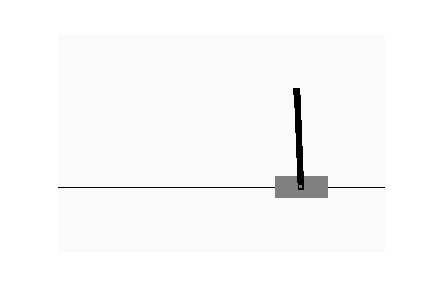
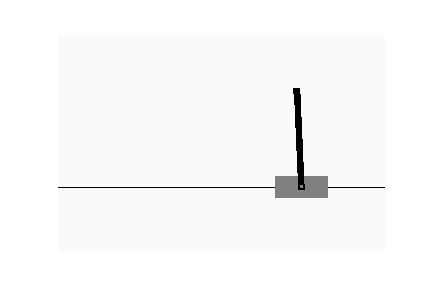
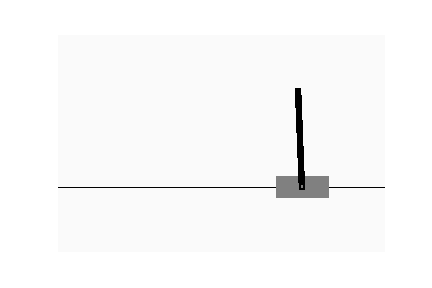
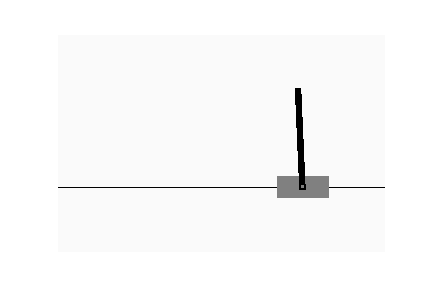
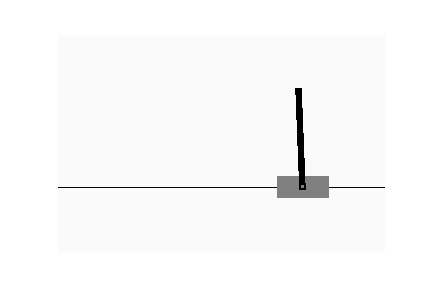
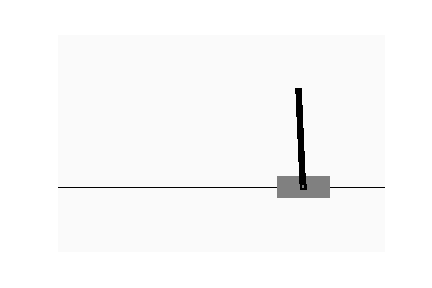
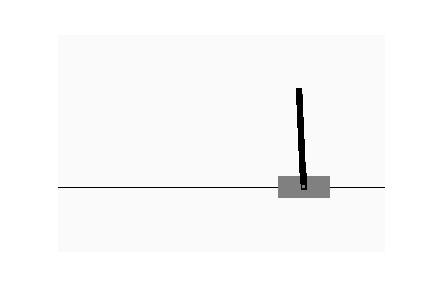
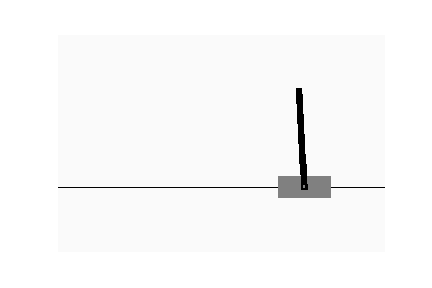
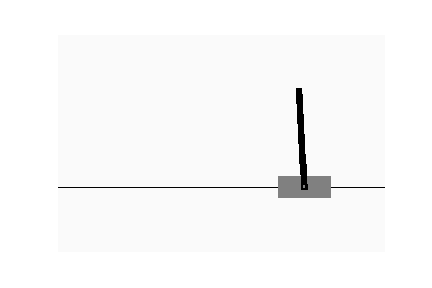
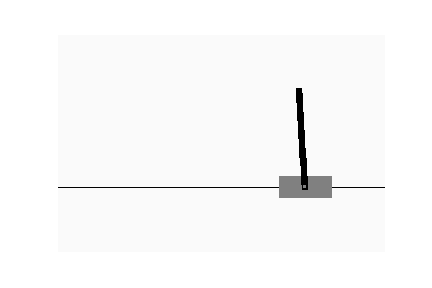
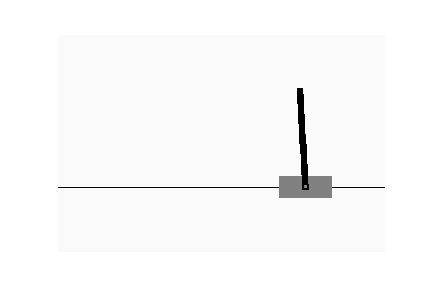
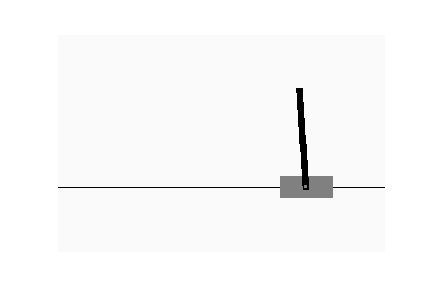
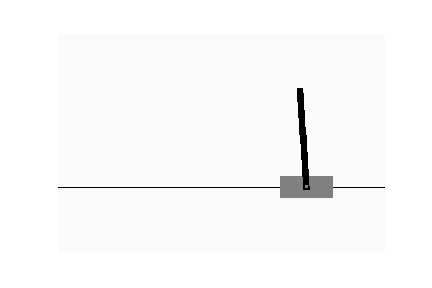
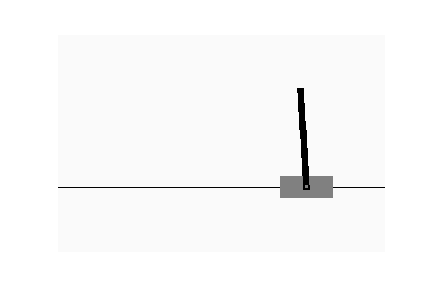
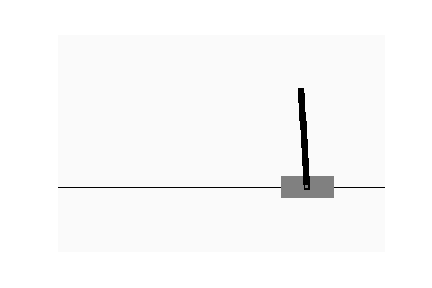
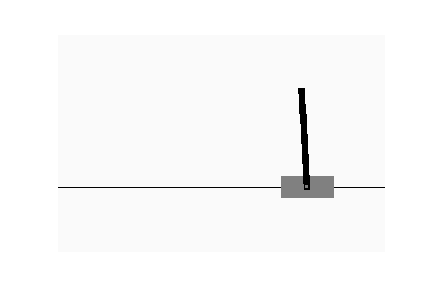
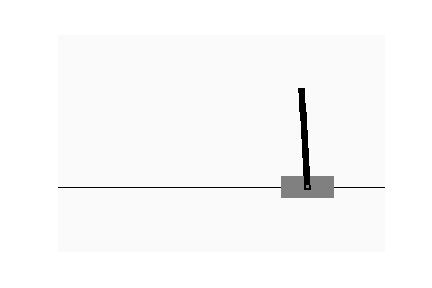
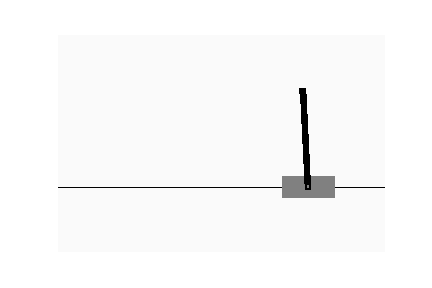
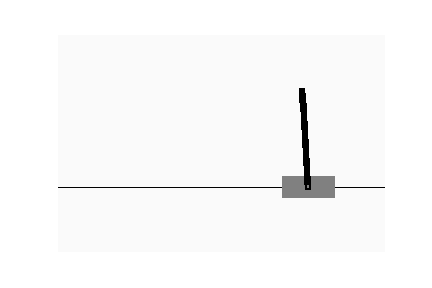
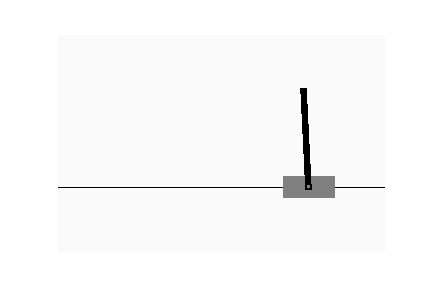
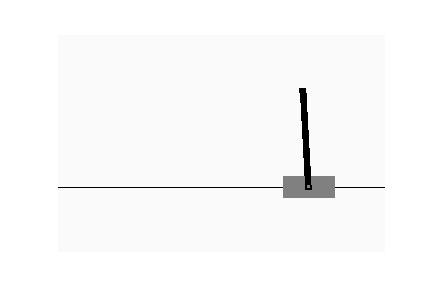
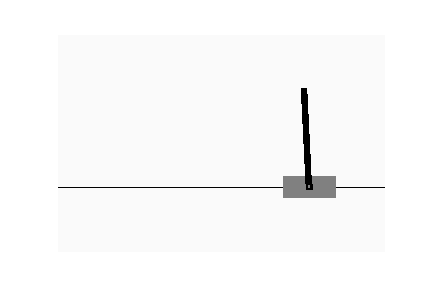
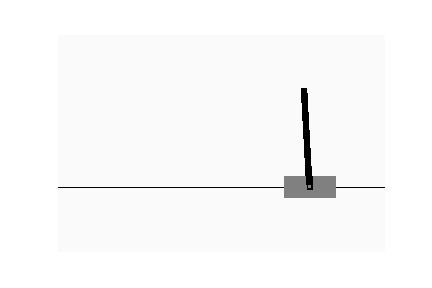
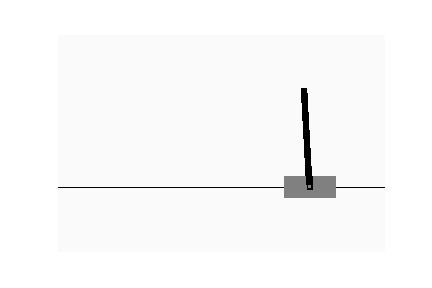
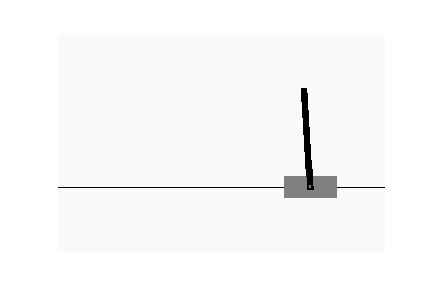
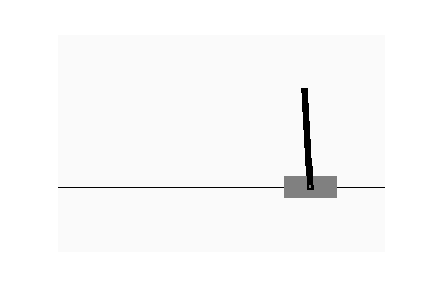
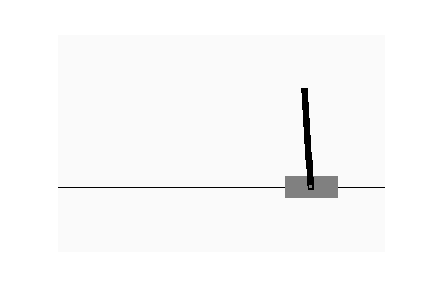
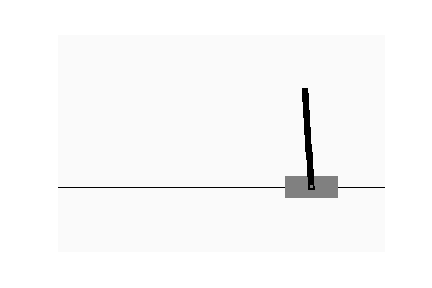
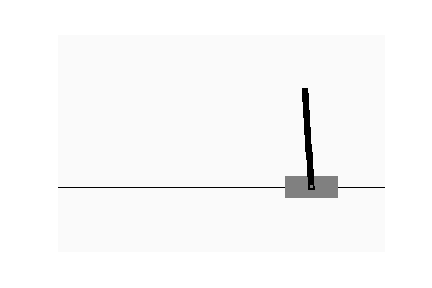
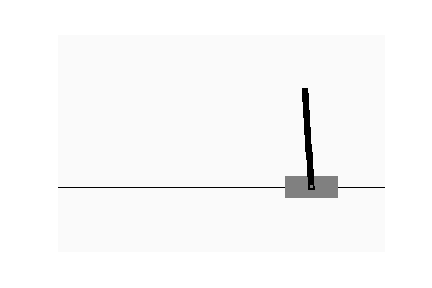
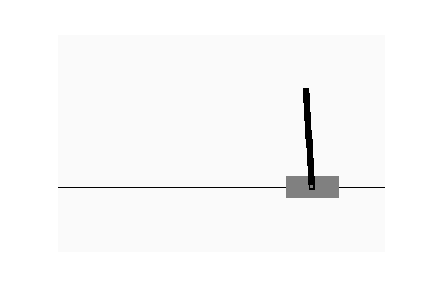
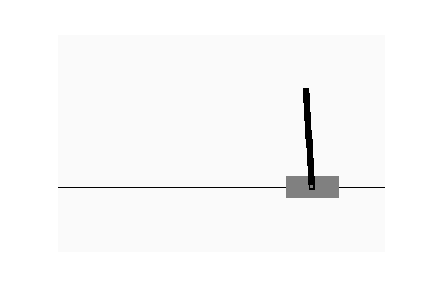
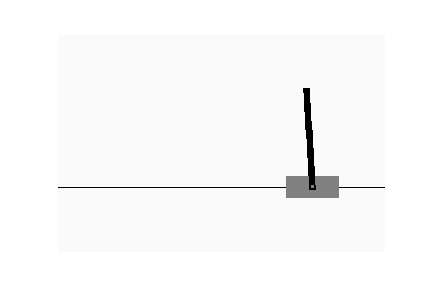
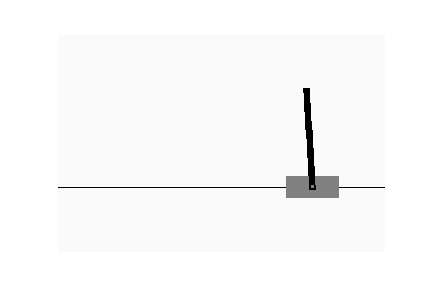
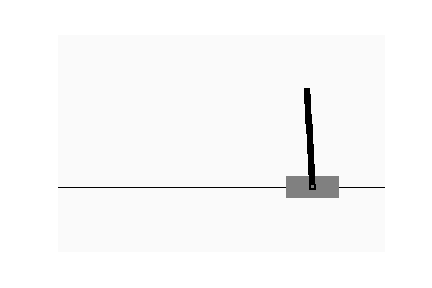
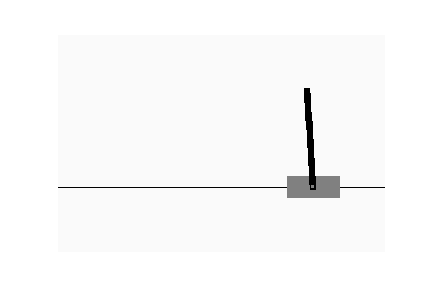
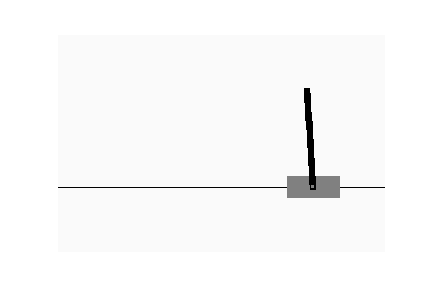
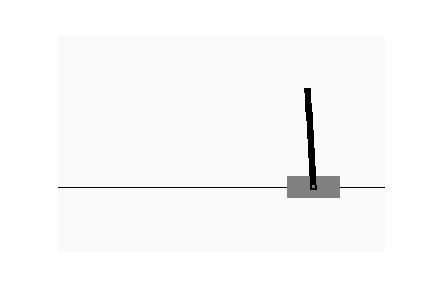
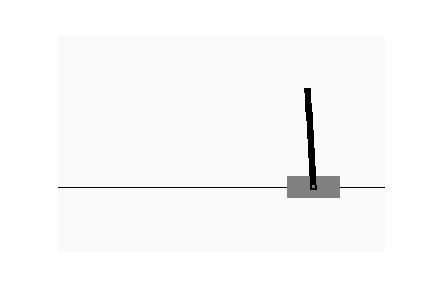
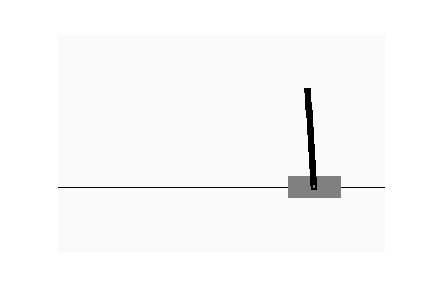
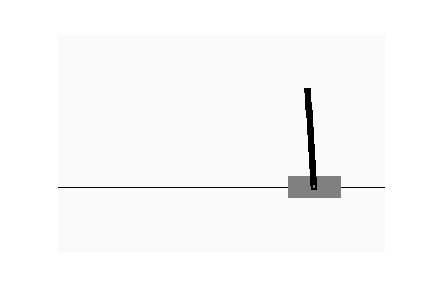
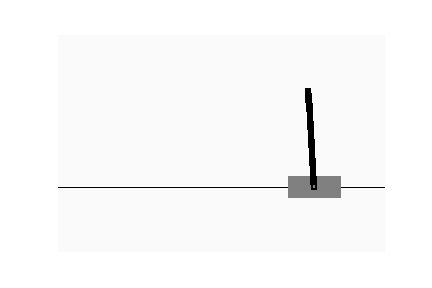
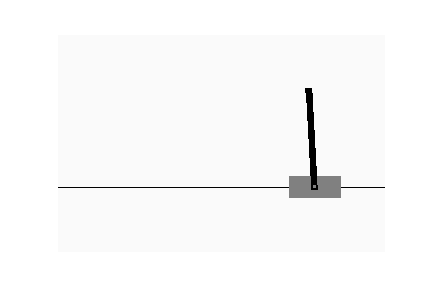
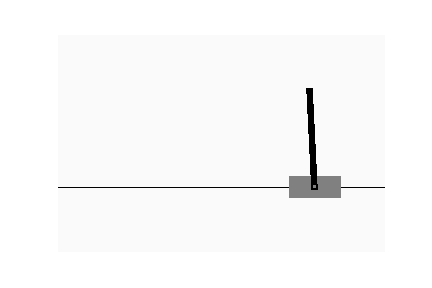
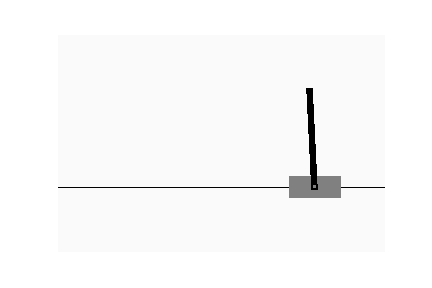
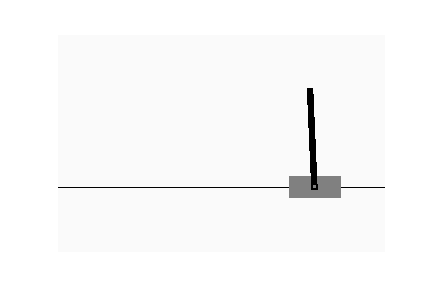
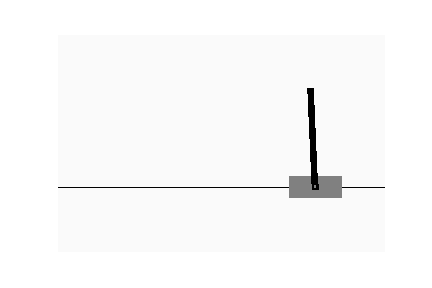
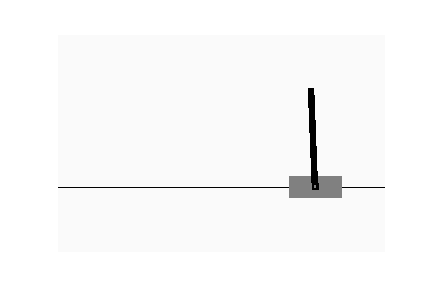
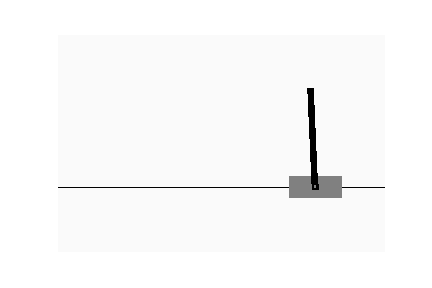
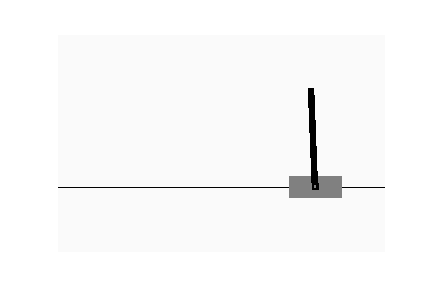
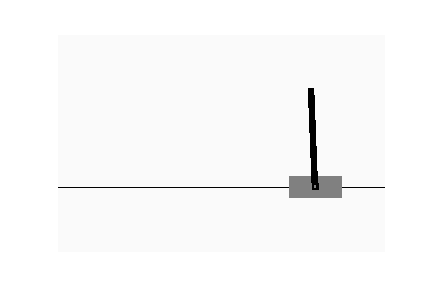
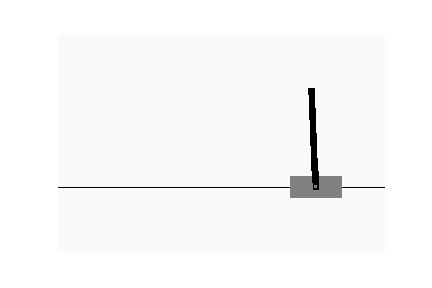
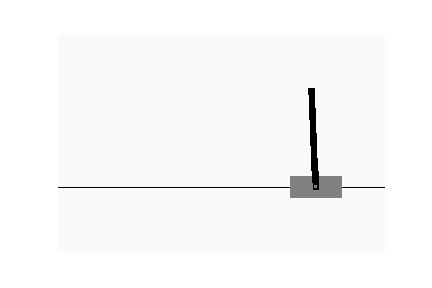
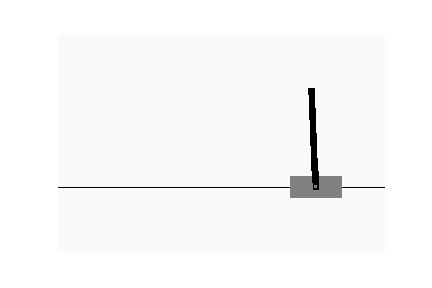
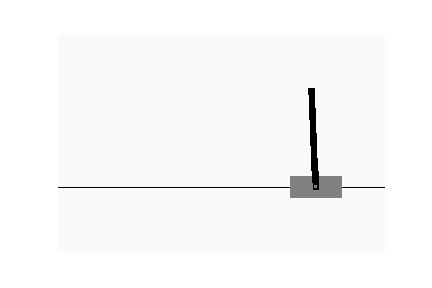
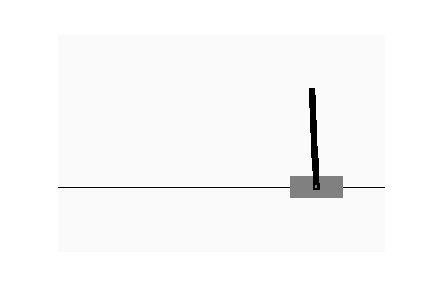
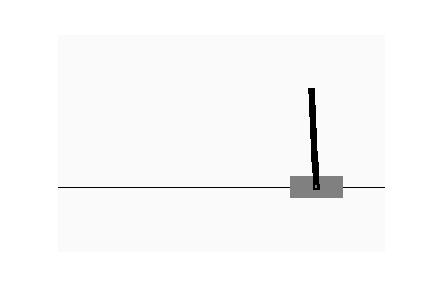
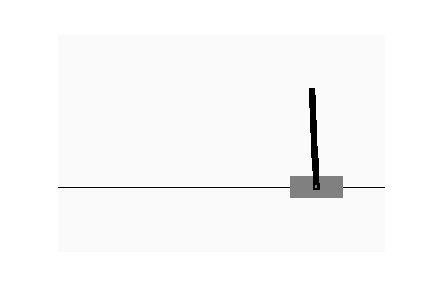
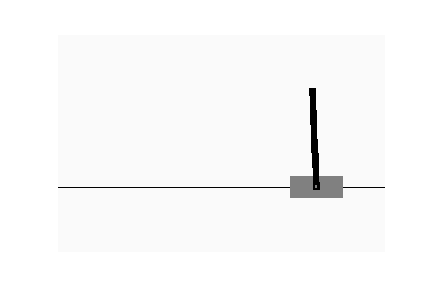
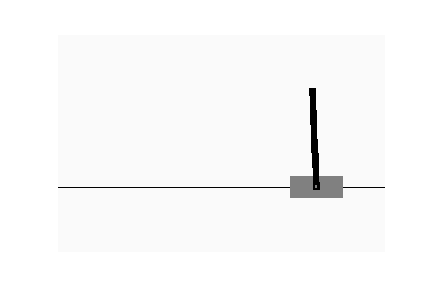
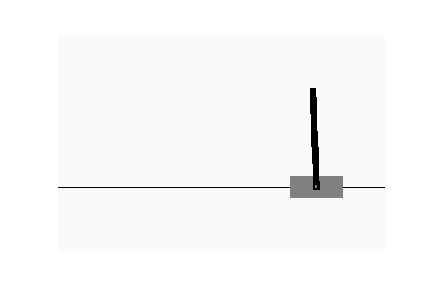
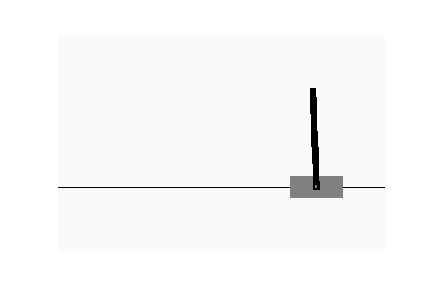
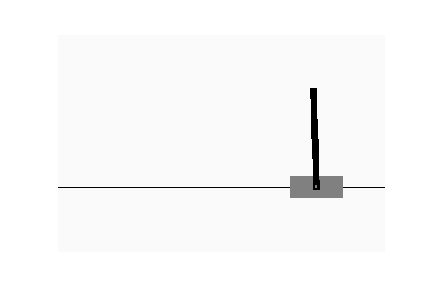
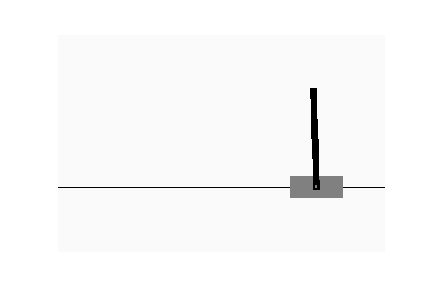
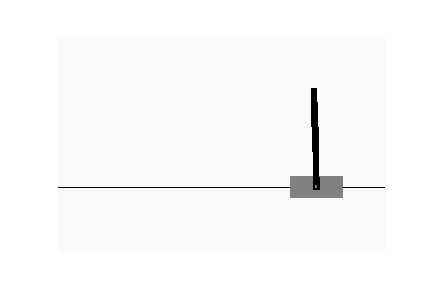
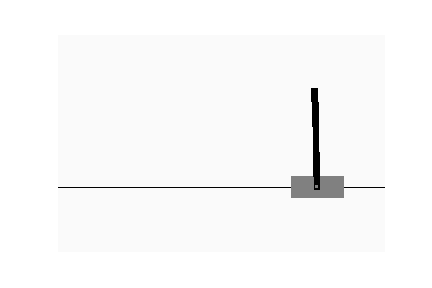
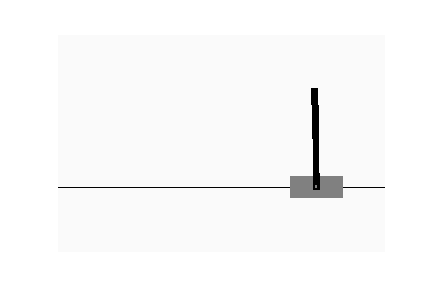
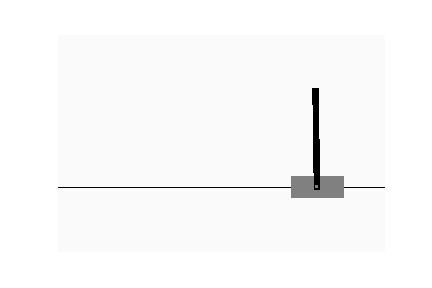
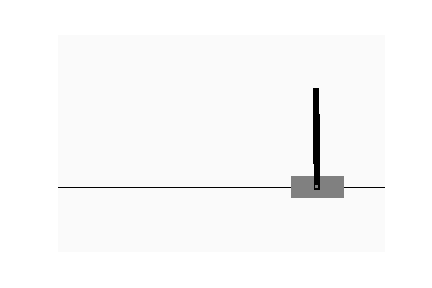
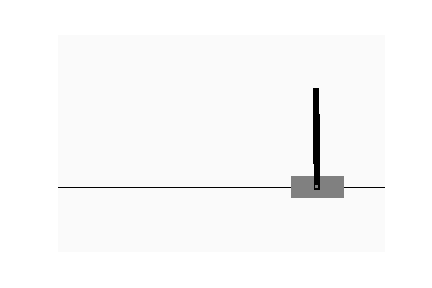
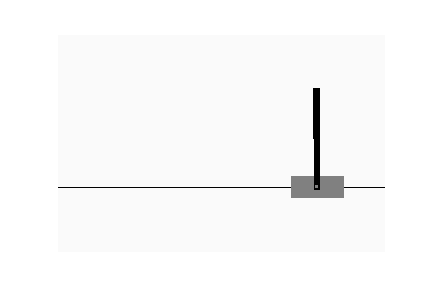
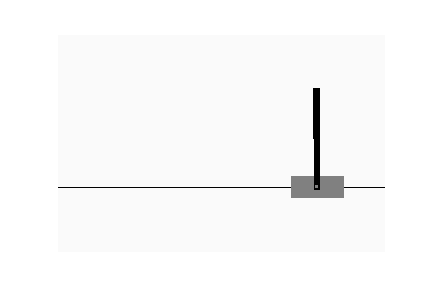
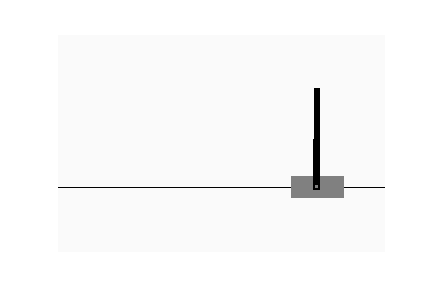
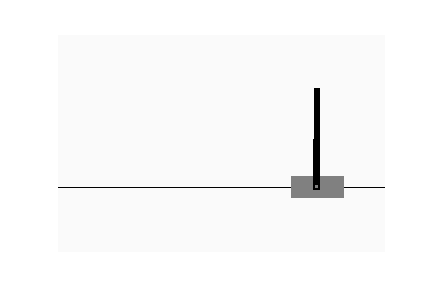
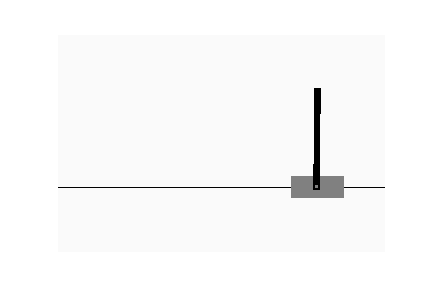
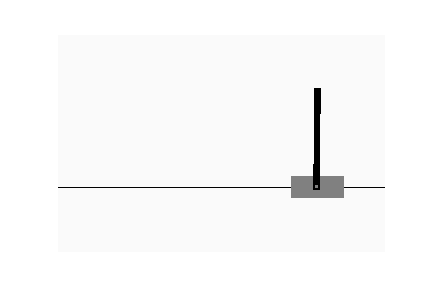
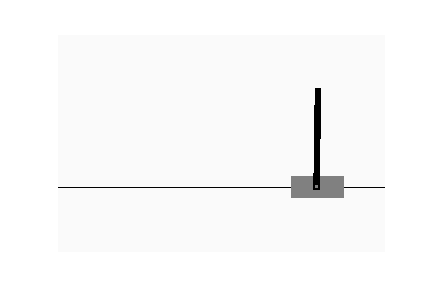
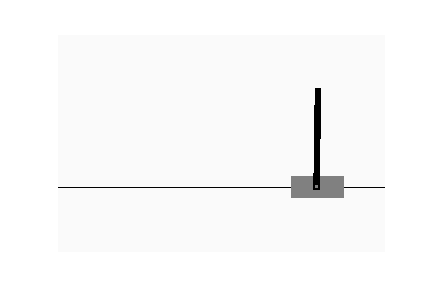
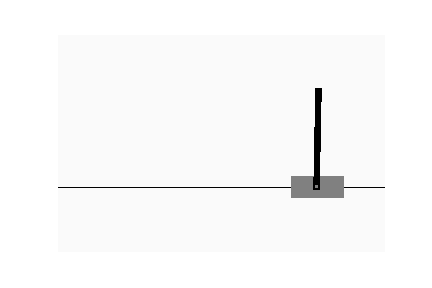
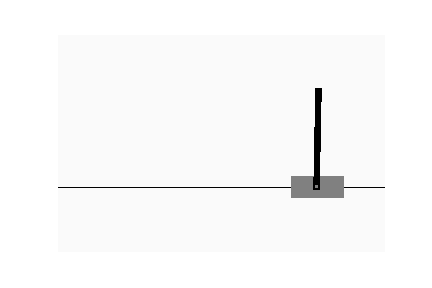
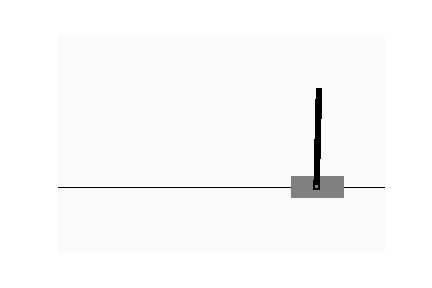
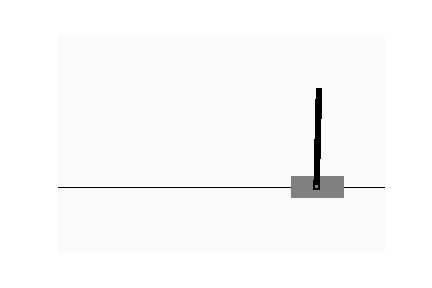
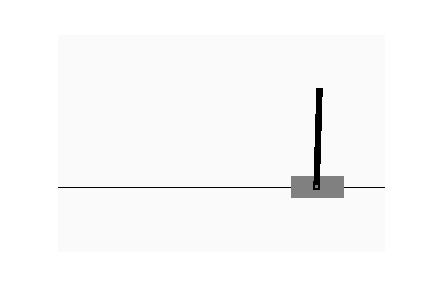
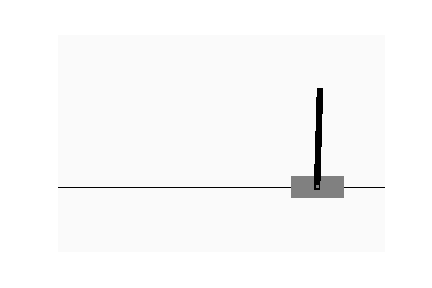
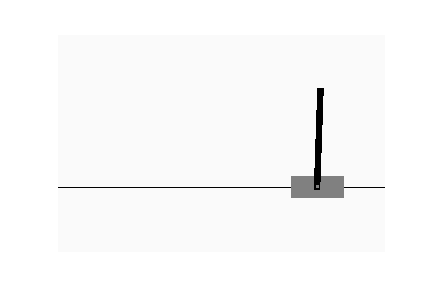
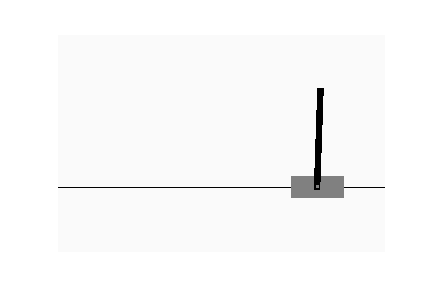
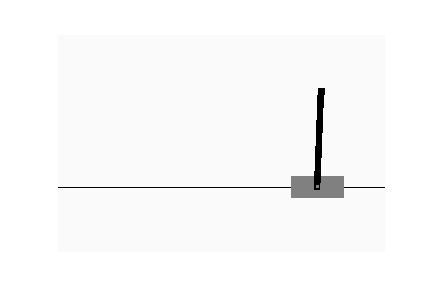
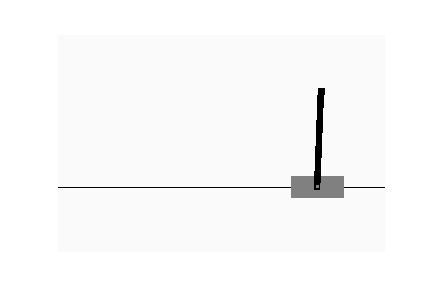
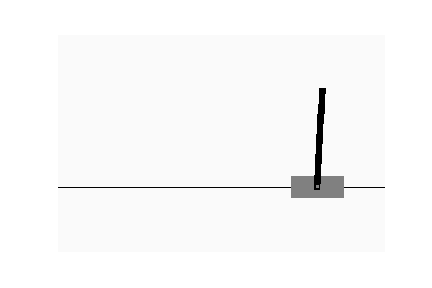
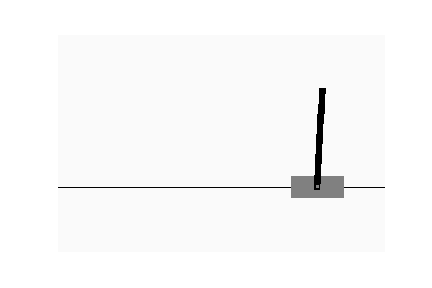
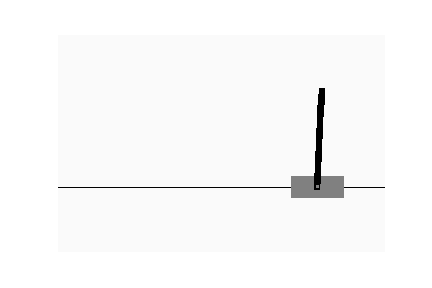
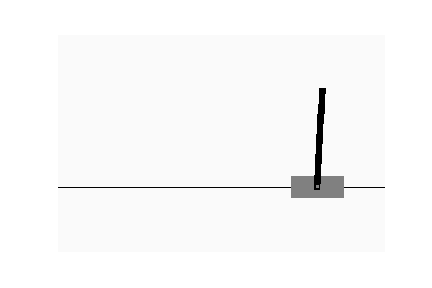
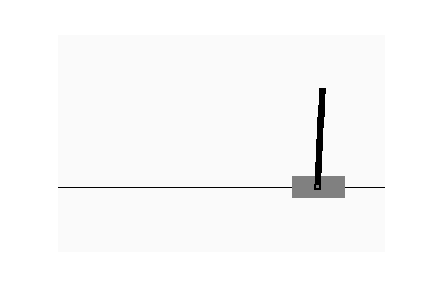
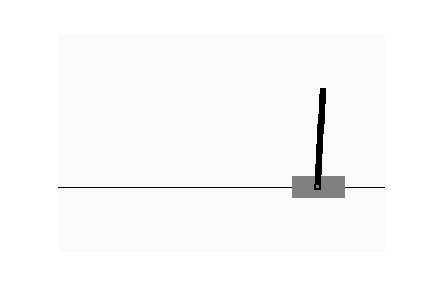
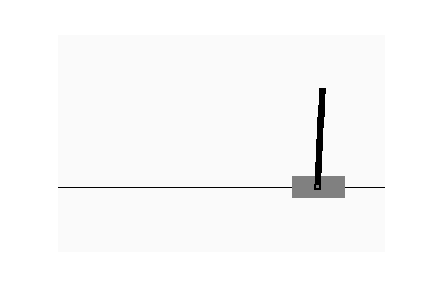
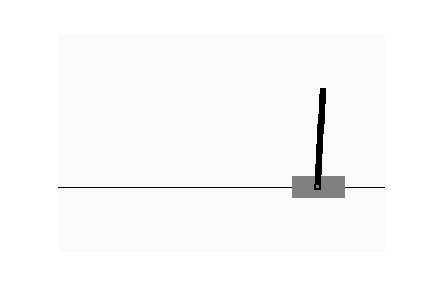
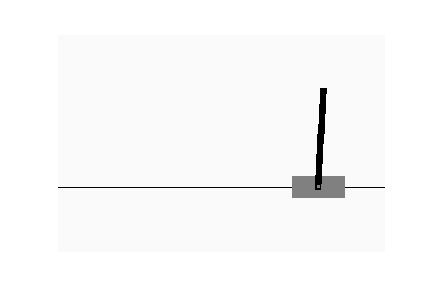
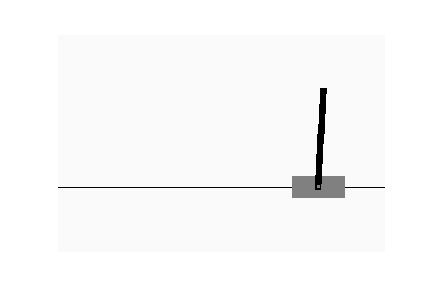
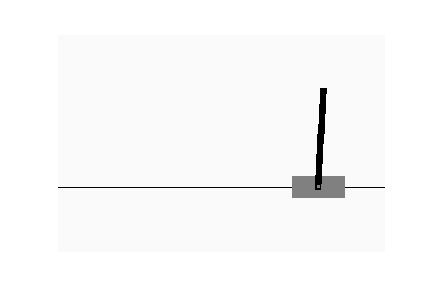
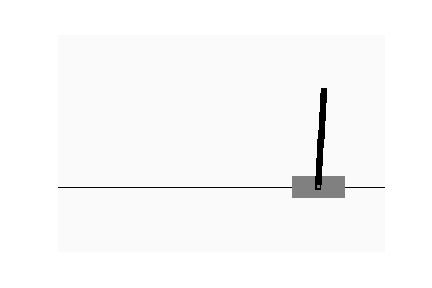
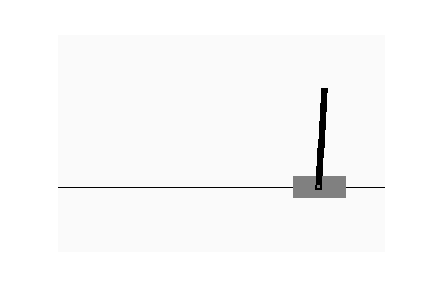
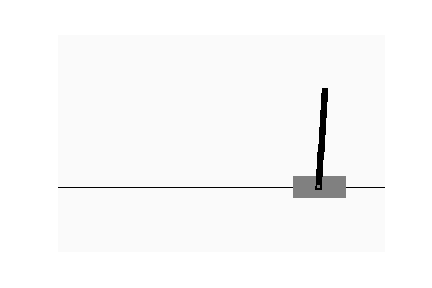
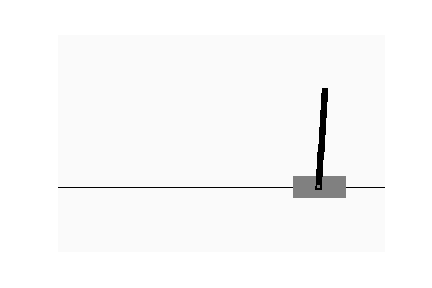
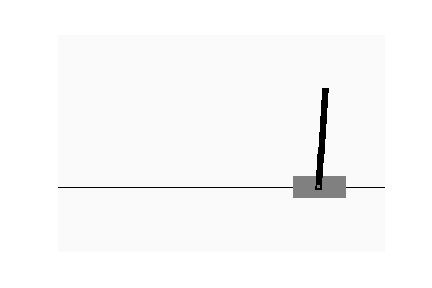
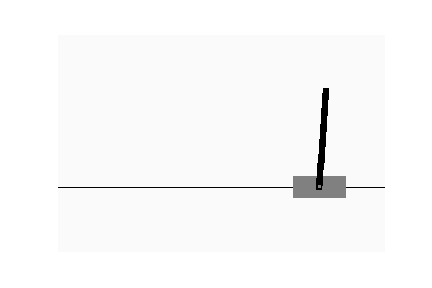
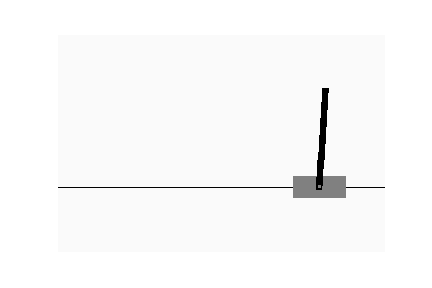
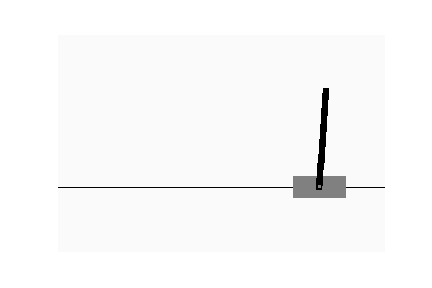
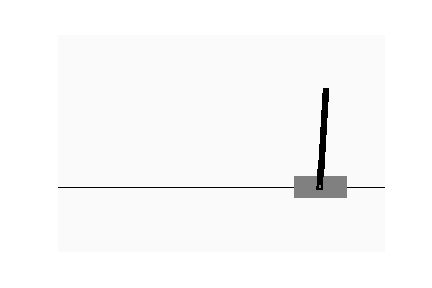
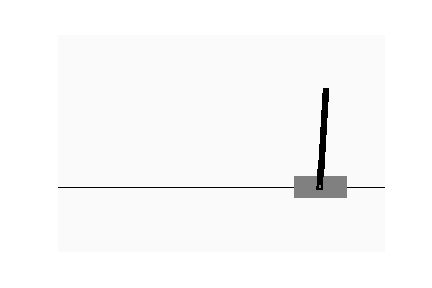
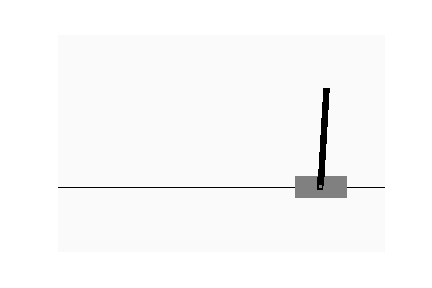
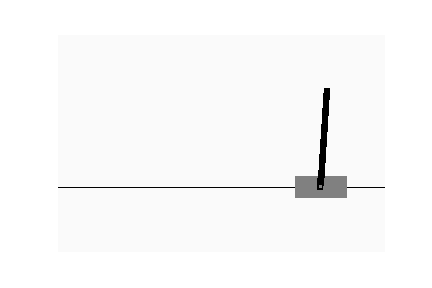
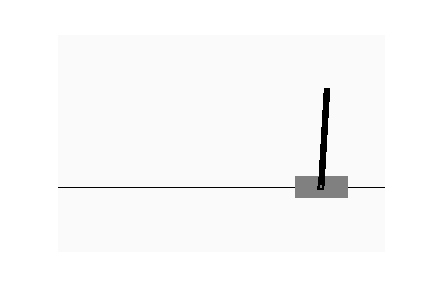
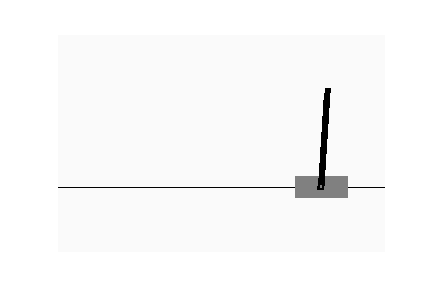
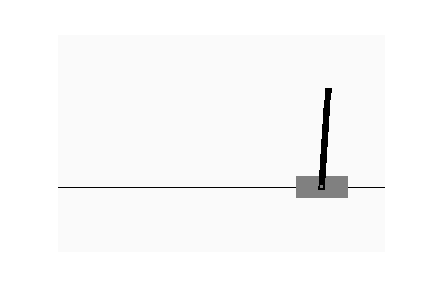
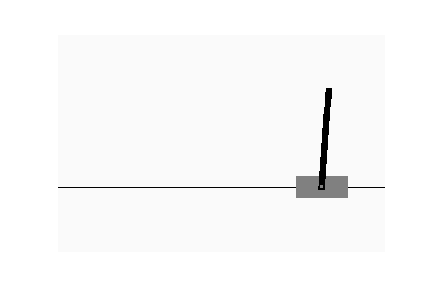
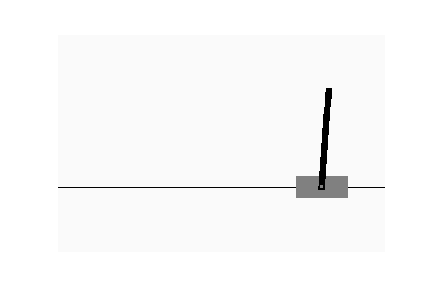
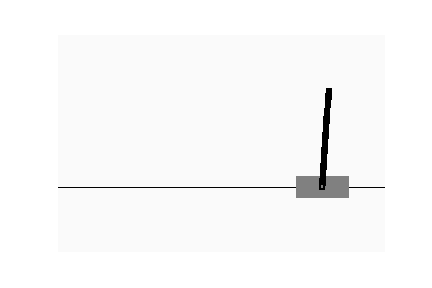
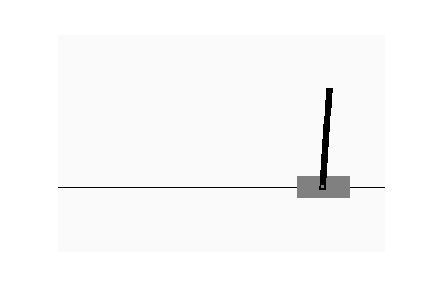
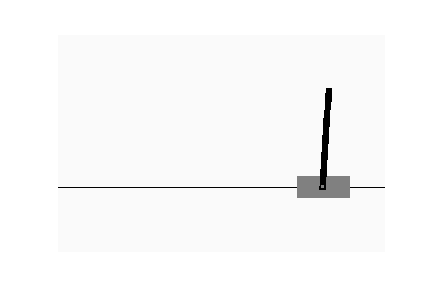
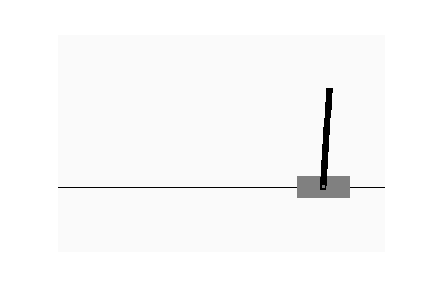
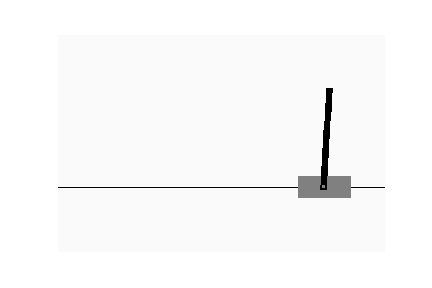
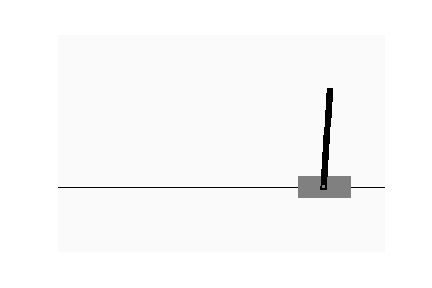
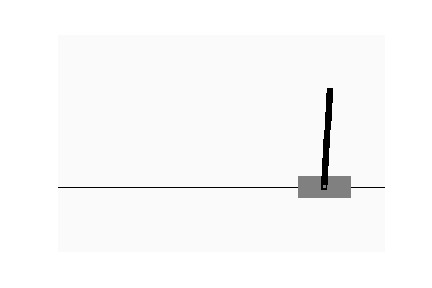
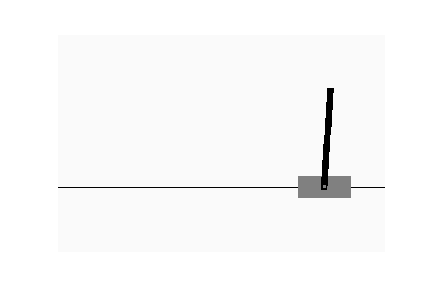
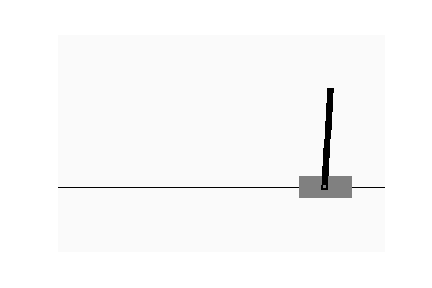
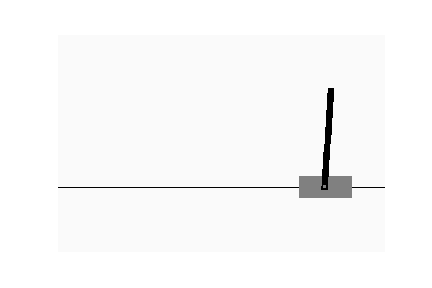
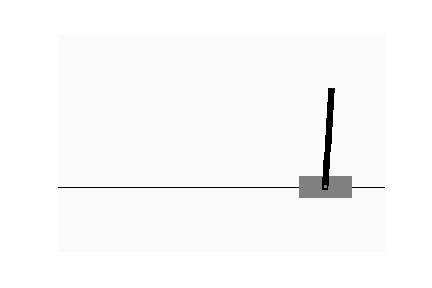
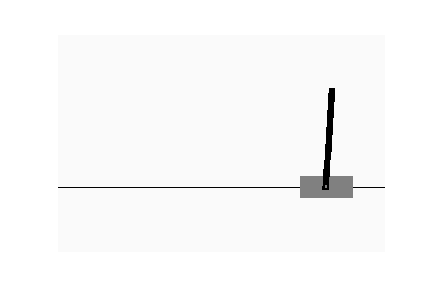
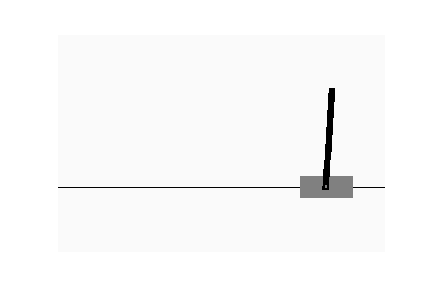
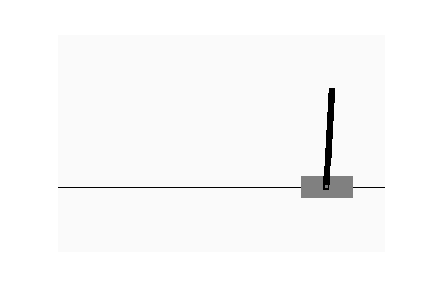
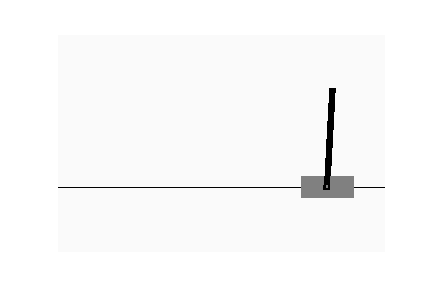
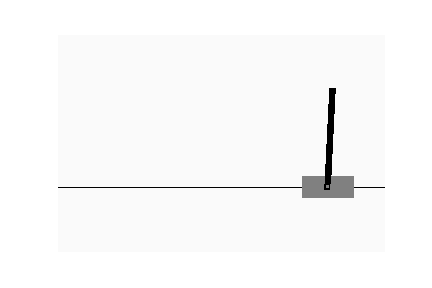
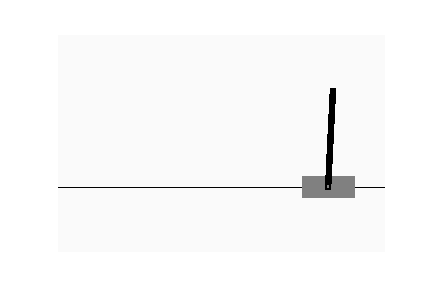
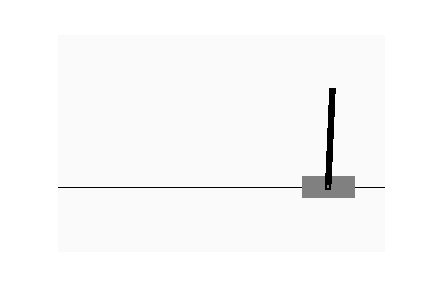
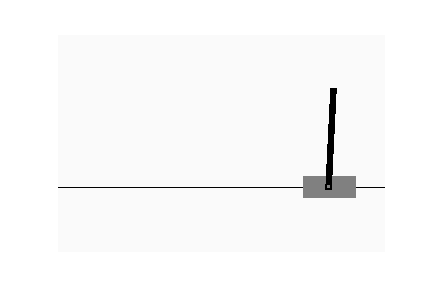
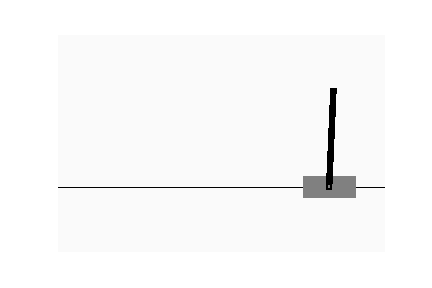
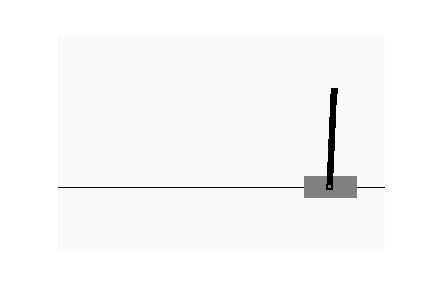
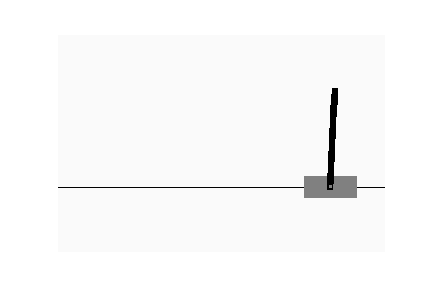
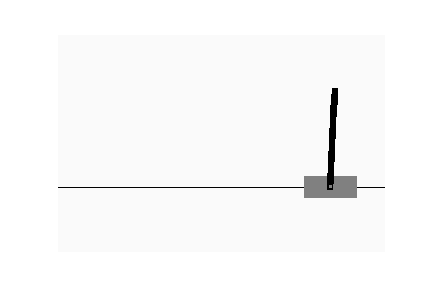
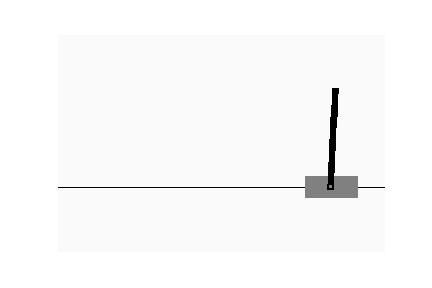
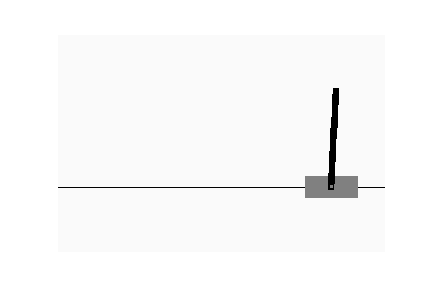
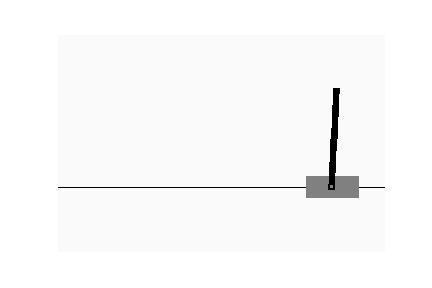
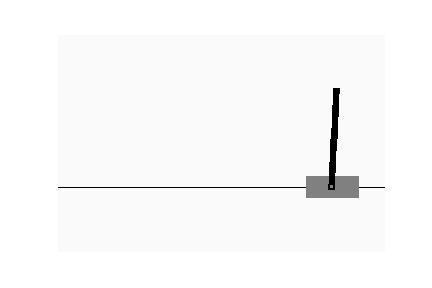
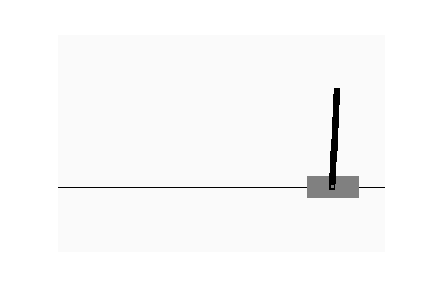
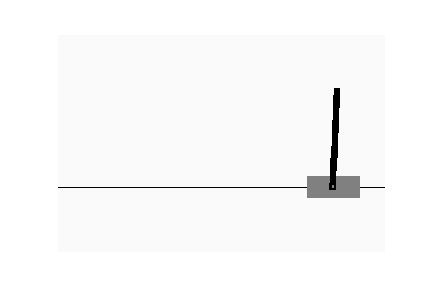
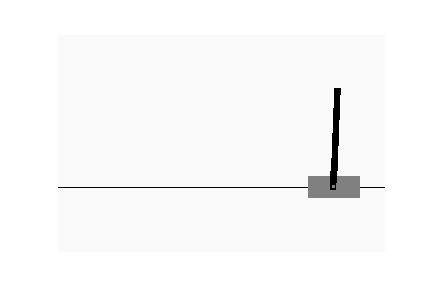
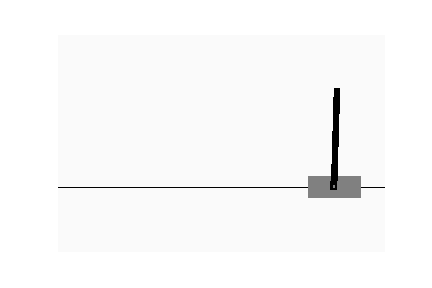
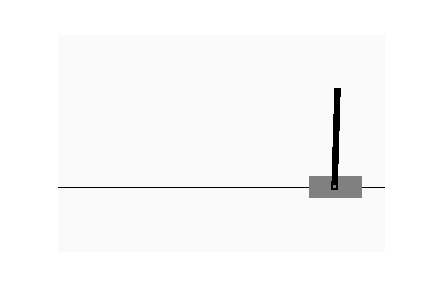
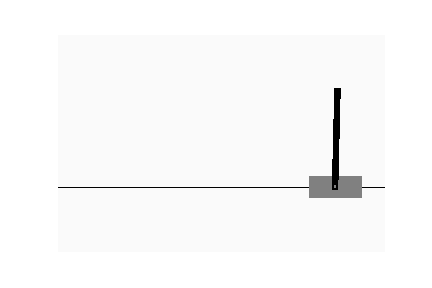
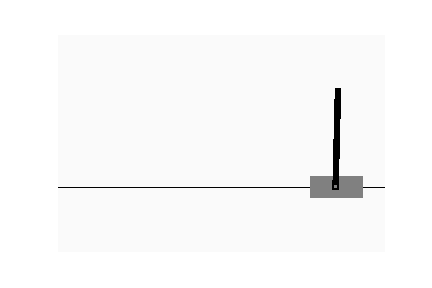
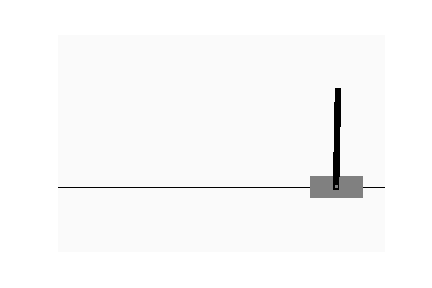
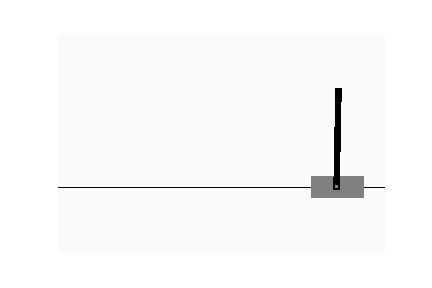
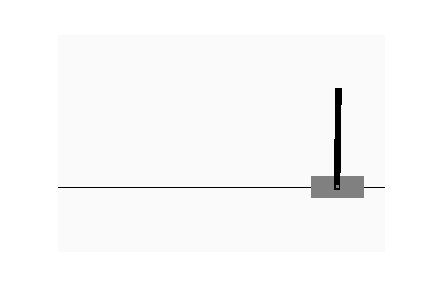
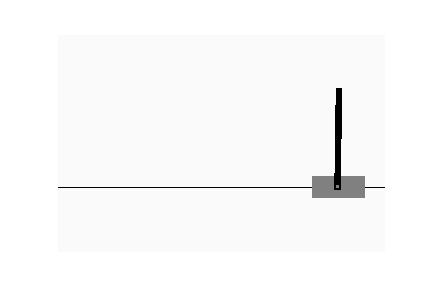
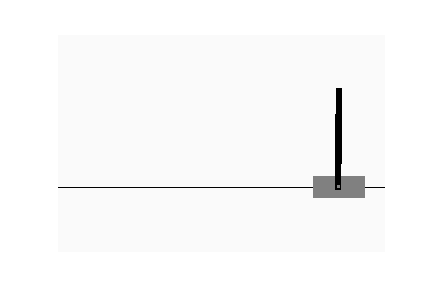
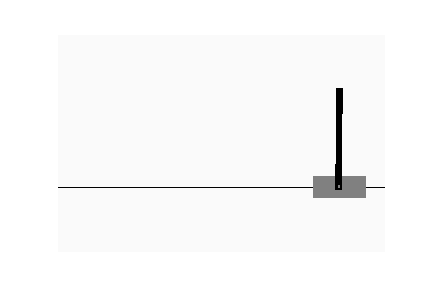
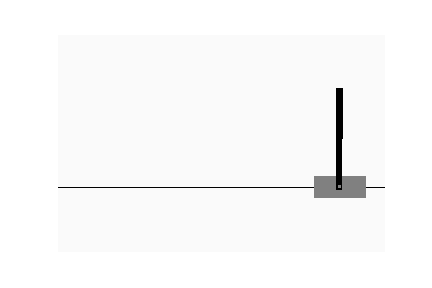
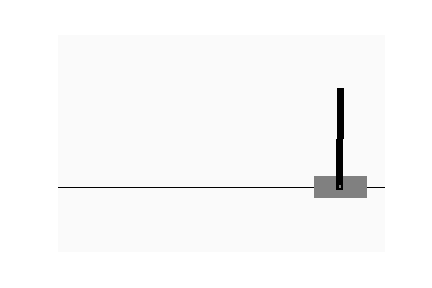
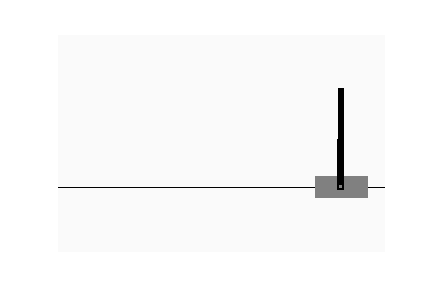
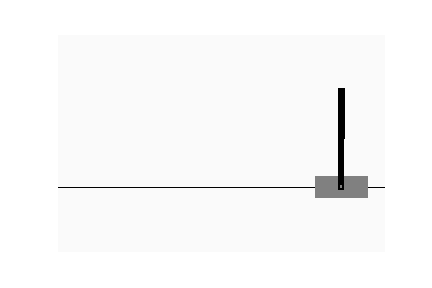
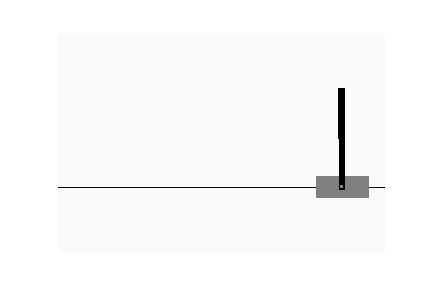
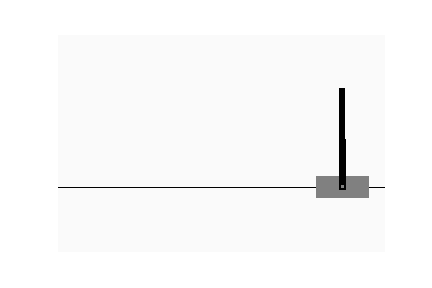
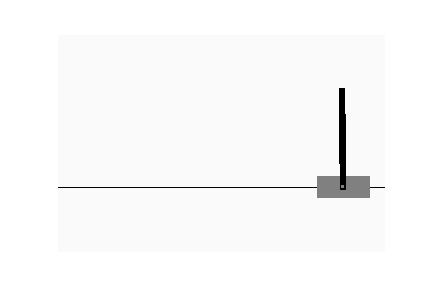
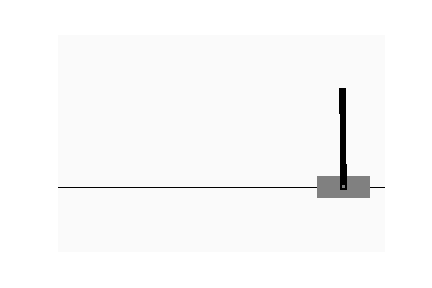
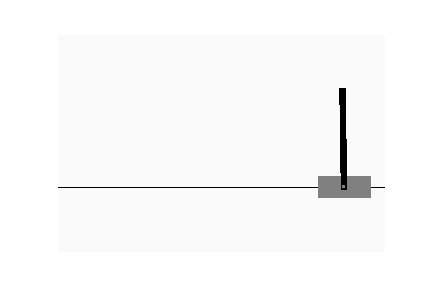
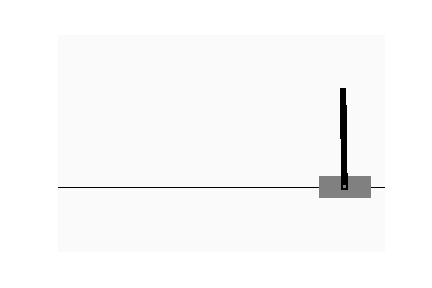
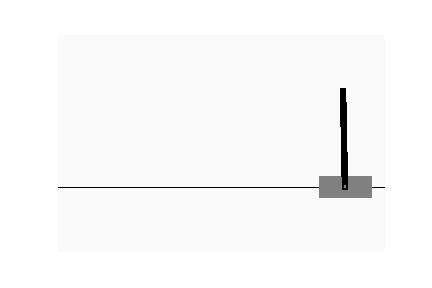
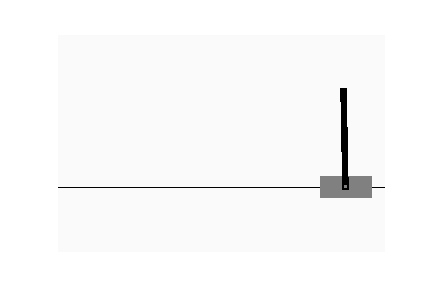
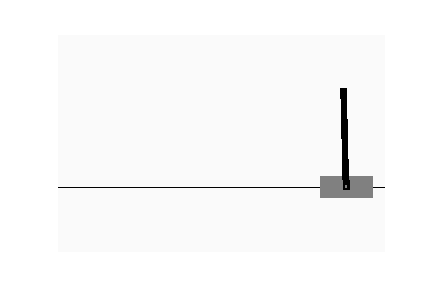
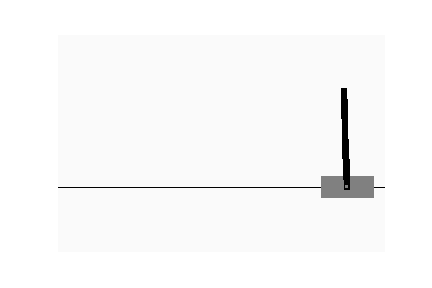
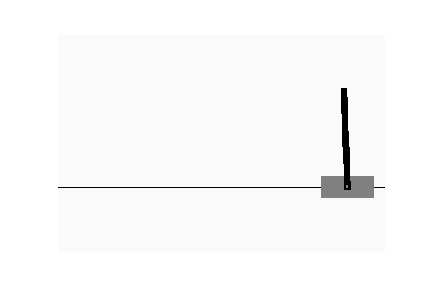
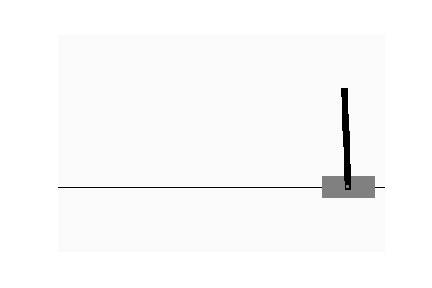
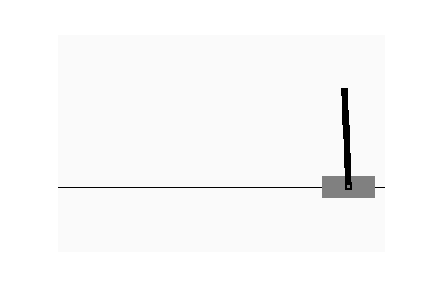
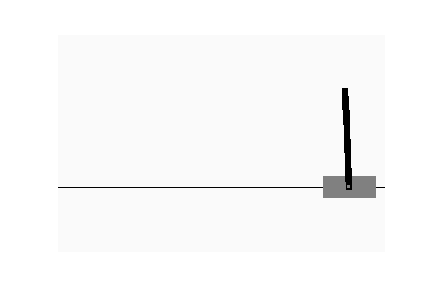
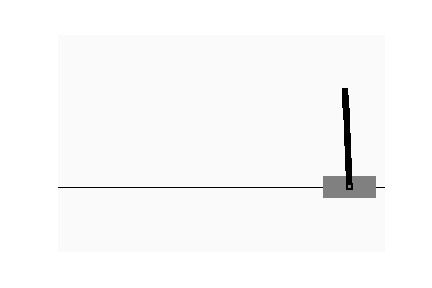
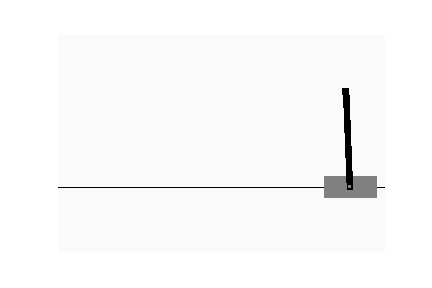
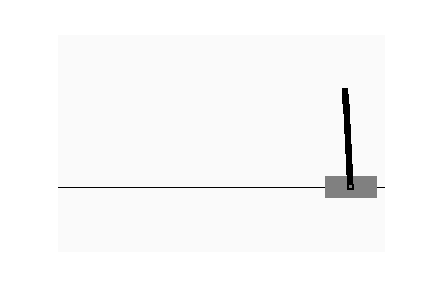
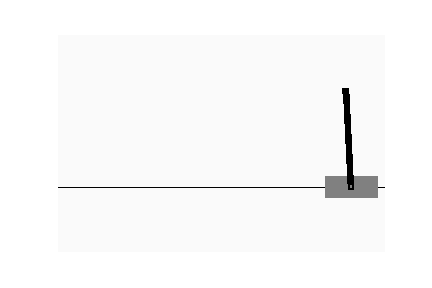
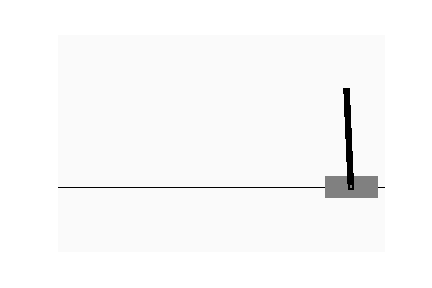
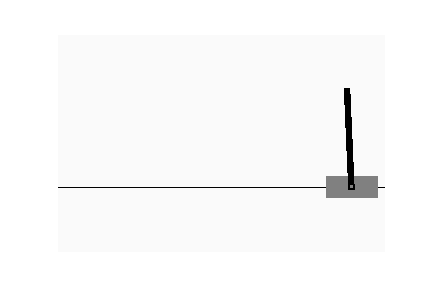
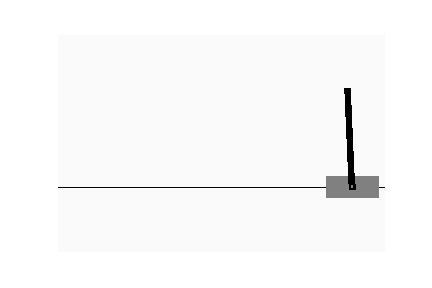
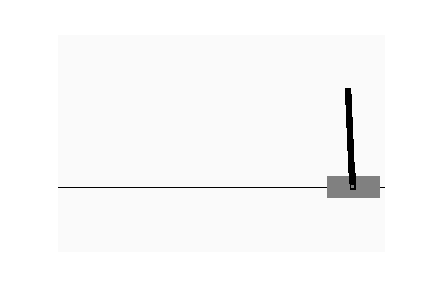
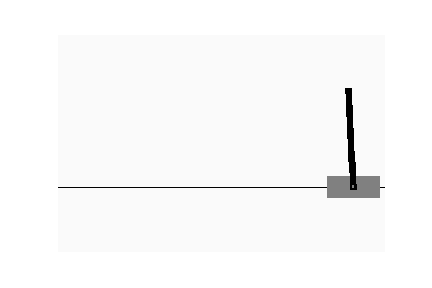
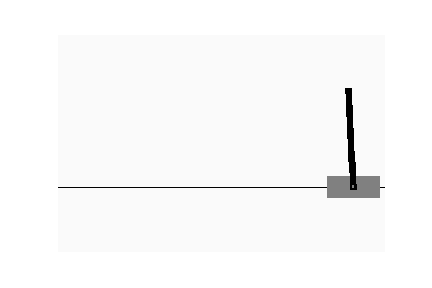
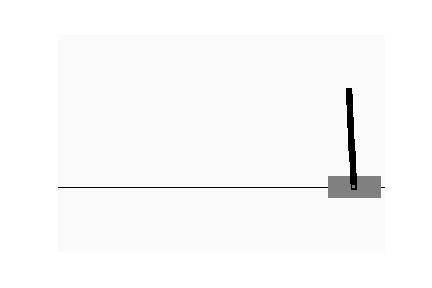
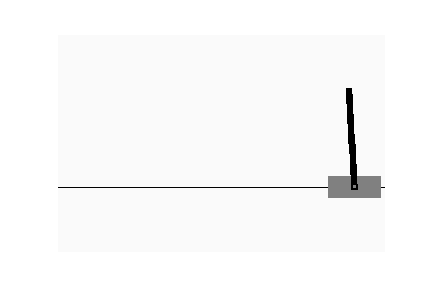
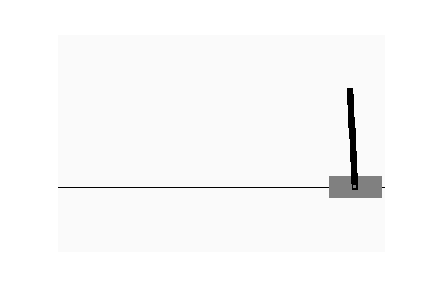
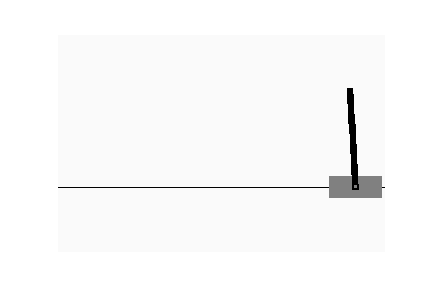
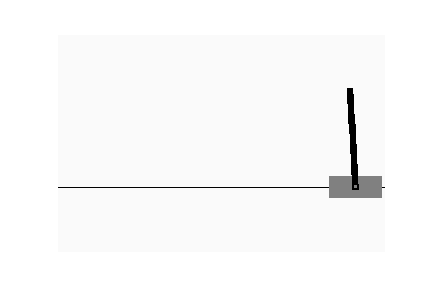
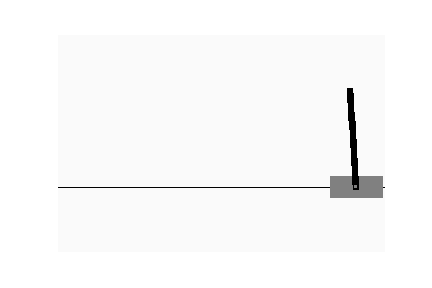
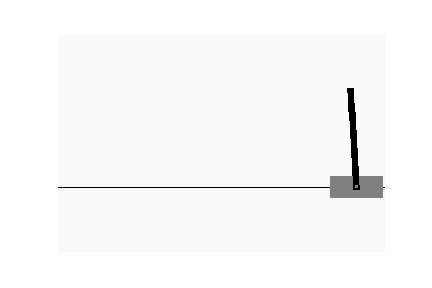
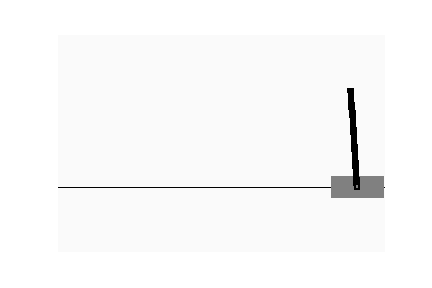
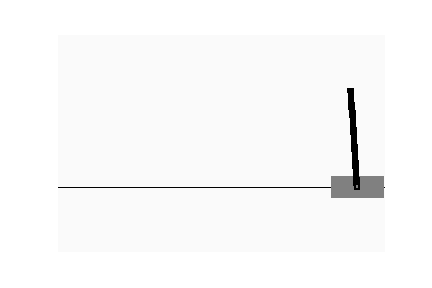
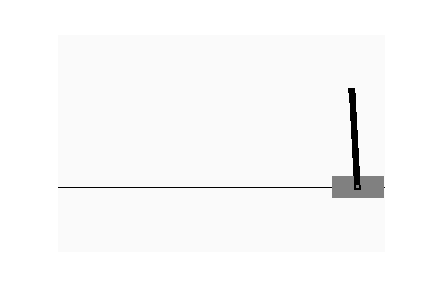
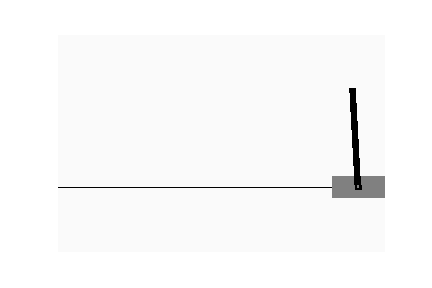
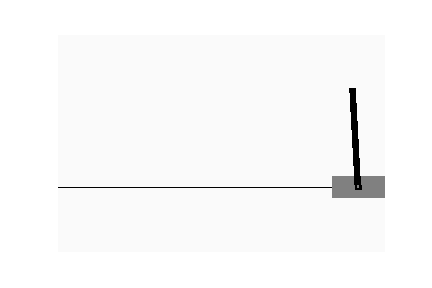
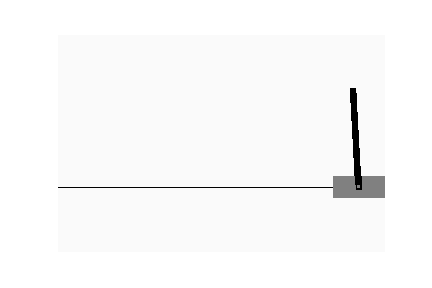
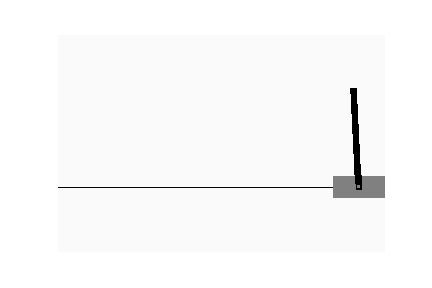
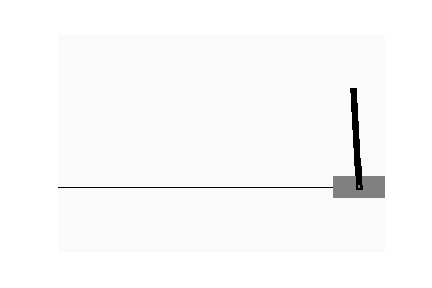
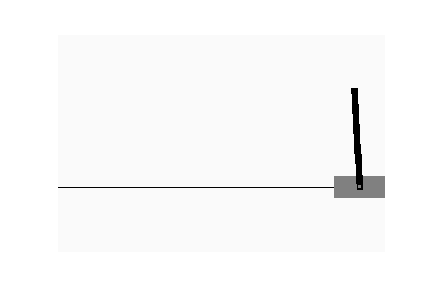
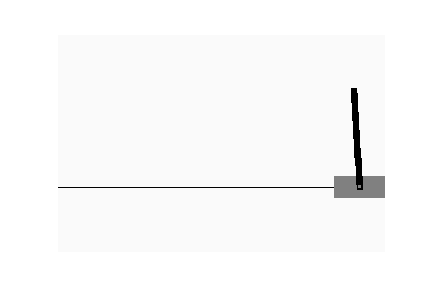
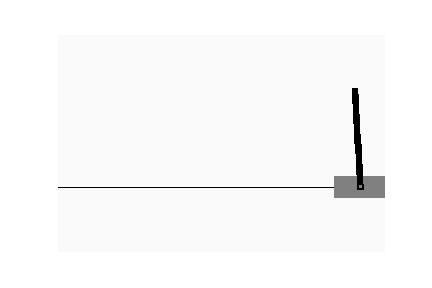
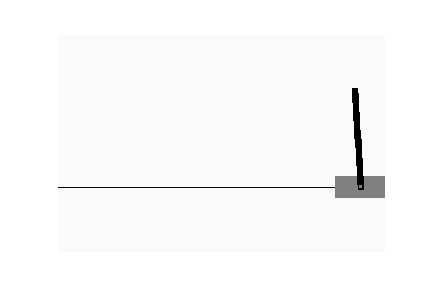
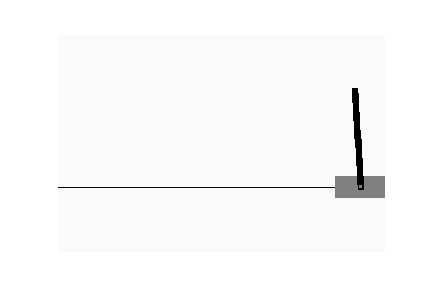
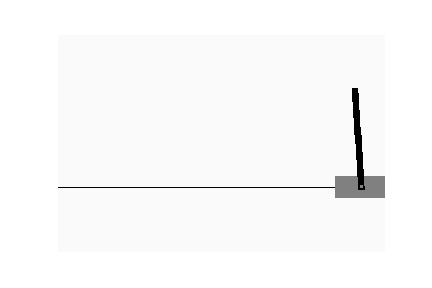
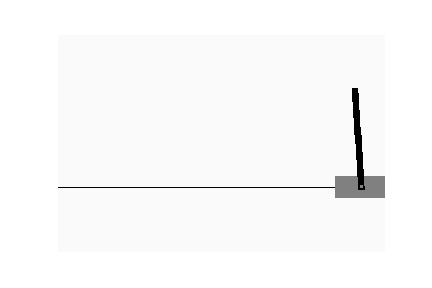
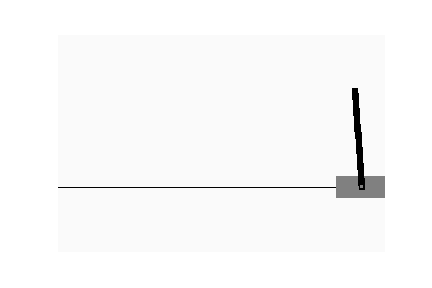
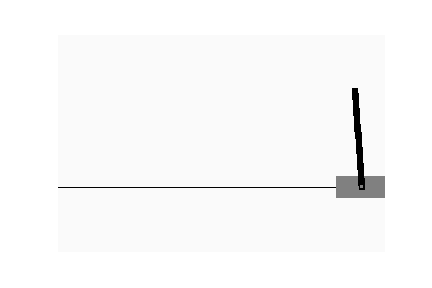
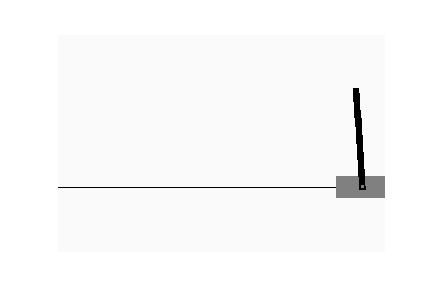
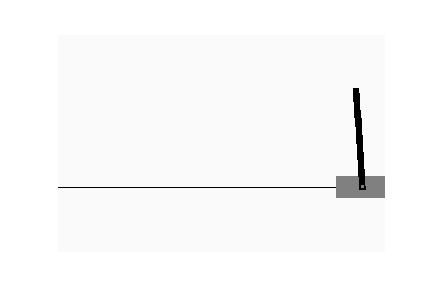
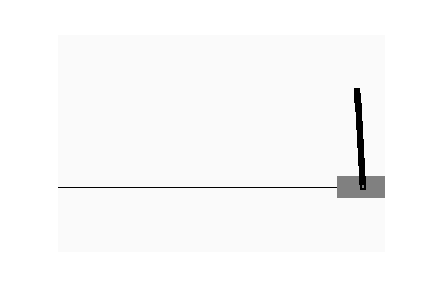
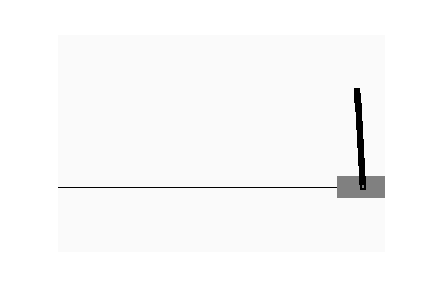
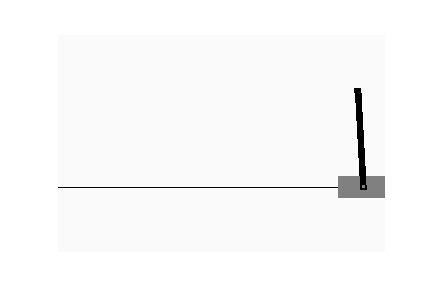
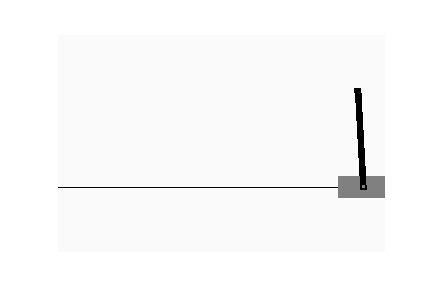
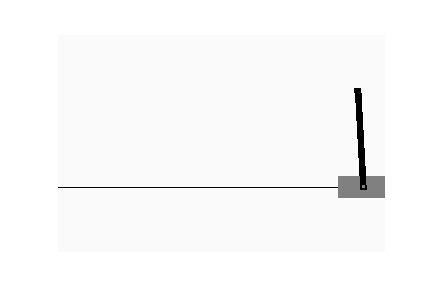
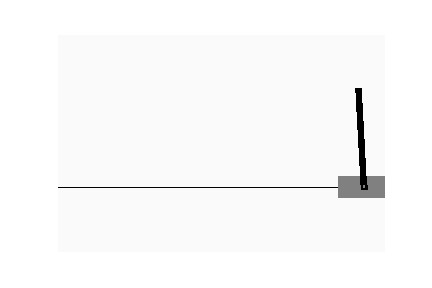
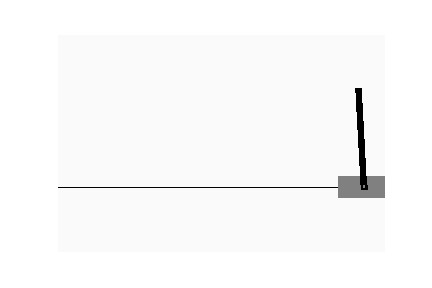
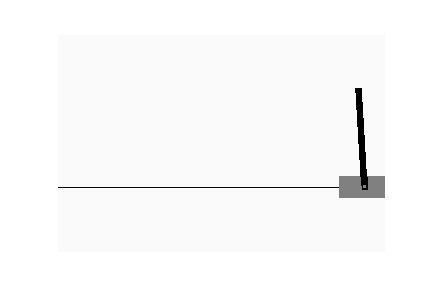
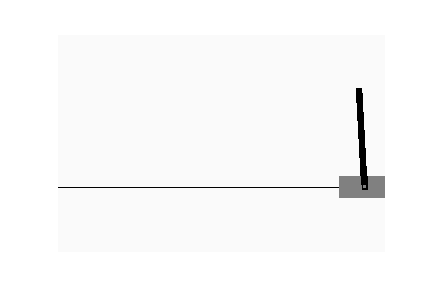

In [10]:
# review solution
s = env.reset()
view = Viewer(env, custom_render=True)
for _ in range(500):
    view.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
view.render(close=True, display_gif=True)

# Exercises

Now it is your turn! Play around the code above and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* number of hidden layers and units


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

*Fİrst I changed the discount factor but since the reward decreases exponentially when factor is smaller than 1, the network did not have a satisfactory result. Then I increased the number of layers with 4-5 hidden layers. However, this led to a too much complexity so the amount of training epochs had to increase as well. Finally I tried different learning rates and found that the 0.001 is the best one for me with a satisfactory result.*

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*[Hint: See introdution notebook.]*

**Answer:**

* * When th discount factor is 1, the total reward is 5. 
* * [ 5, 4, 3, 2, 2, 1, 0, 0 ,0 ,0 ] 
* * [ 1x0.9⁶ + 1x0.9⁵ + 1x0.9³ + 1x0.9²+ 1x0.9¹,
1x0.9⁵ + 1x0.9⁴ + 1x0.9² + 1x0.9¹+ 1 ,
1x0.9⁴ + 1x0.9³ + 1x0.9¹ + 1,
1x0.9³ + 1x0.9² + 1, 1x0.9² + 1x0.9, 1x0.9, 1, 0, 0, 0]

### Exercise 3

*You will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross. How can you explain this behavior?*

*[Hint: Do we use the policy network in the same way during training and validation?]*

**Answer:**

*In validation we do not compare our network's output with a random number instead we take the maximum probability action. This means that we always choose the most logical action. However, in training we compare the network's output with a random number. In other words we are discovering instead of exploiting.*

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma (see the introduction notebook for definition)?*

**Answer:**

*As stated in exercise 3, the exploration is done by having a randomness in our final action of the network's output. There we dont necessarily take the highest probability action into account. We rather give a chance to the second best option. We do this by taking a random number and comparing that with both of our probabilities. *

*EXERCISE from the book* 
** http://neuralnetworksanddeeplearning.com/chap3.html#exercises_824189**

**Answer: ** When y = 0, log(0) is not defined. So this cannot be the case. In the other case a cannot be 0 since it is an output of the network so it is safe. 